<a href="https://colab.research.google.com/github/lowxuan215-lab/AmsterdamUMCdb/blob/master/bigquery/getting_started_____sunday_night.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_c4i_square.png?raw=1" alt="Logo C4I" width=128px/>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo AMDS" width=128px/>

# AmsterdamUMCdb with Google BigQuery and Colaboratory
## AmsterdamUMCdb - Freely Accessible ICU Database

AmsterdamUMCdb version 1.5.0 May 2024  
Copyright &copy; 2003-2024 Amsterdam UMC - Amsterdam Medical Data Science

# Introduction
To encourage rapid data exploration and model development, access to AmsterdamUMCdb is also available using Google BigQuery with Google Colaboratory ('Colab') as the main coding environment. This removes the necessity of downloading the AmsterdamUMCdb csv files, setting up a database system and installing a coding environment.

Recently, AmsterdamUMCdb has been [converted](https://github.com/AmsterdamUMC/AMSTEL) to the [Observational Medical Outcomes Partnership Common Data Model version 5.4](https://ohdsi.github.io/CommonDataModel/cdm54.html) (OMOP CDM 5.4) maintained by the [Observational Health Data Sciences and Informatics](https://www.ohdsi.org/) (OHDSI) community. The transition from the original ('classic') AmsterdamUMCdb data format to the OMOP CDM should improve the reusability of both the data and analyses on the current and future version of database by closely adhering to the [FAIR](https://doi.org/10.1038/sdata.2016.18) (Findable, Accessible, Interoperable and Reusable) principles.

This tutorial for using AmsterdamUMCdb on BigQuery was based on the original Google BigQuery tutorial on [Colab](https://colab.research.google.com/notebooks/bigquery.ipynb).

# Running Colab
If not done already, please open Colab with this **getting_started** notebook from the official AmsterdamUMCdb GitHub repository: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/bigquery/getting_started.ipynb)

**Important**: when following this tutorial, make sure to follow *all* steps and to run the **code cells** using the **Play** button or by pressing `Ctrl-Enter`

# Before you Begin
Ensure you have a working Google account and verify that the e-mail address used when applying for access has been associated with this account. If you already have a Google account, you can add secondary e-mail addresses [here](https://myaccount.google.com/alternateemail), or alternatively create another Google account using the e-mail address used in the application form.

If you don't have any experience in using Jupyter notebooks and/or Python, it is recommended to familiarize yourself with the [basics](https://colab.research.google.com/notebooks/intro.ipynb).

# Accessing the database
Provided you have signed the end user license agreement, you will have free access to the data from AmsterdamUMCdb through the Google Cloud Platform.

To explore and query the database you need to create a Google Cloud Platform project. For new users, Google offers a free tier of 1 TB (2<sup>40</sup> bytes) per month for queries and in addition \$300 credit for free for use on the Google Cloud Platform (currently: \$6.00 per TB). In the unlikely event, this amount is not sufficient during a datathon or course, please contact us and we will work with you to find a solution.

# Signing up for Google Cloud Platform
- To sign up for the free tier and free credits, please visit the Google Cloud Platform: https://cloud.google.com/.
- Click **Get started for free**.
- Log in with the Google account you used when registering for the datathon.
- In Step 1 of 2: agree to the **Terms of Service** and select **Continue**.
- In Step 2 of 2: You will be required to add some additional information, including a payment method to make sure you are not a robot. Don't worry you won't be charged unless you manually upgrade to a paid account. Depending on your payment provider, you may have an additional step to verify the payment method.
- Finally press **Start my free trial**. You are good to go.



<a name="cell-project-id"></a>
# Retrieving your Google Cloud Project ID
- At the top of the screen, select **My First Project** or [create a new one](https://console.cloud.google.com/projectcreate). Please write down the Project ID in the cell below ("Insert text here") and **Run** the cell to store the value.

In [8]:
# sets *your* project id
PROJECT_ID = "project-b94b02e0-ce53-4cd7-9a8" #@param {type:"string"}

# Sets the default BigQuery dataset for accessing AmsterdamUMCdb

If you have received instructions to use a specific BigQuery instance, change the default settings here. Otherwise use these default values.

In [9]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'van_gogh_2026_datathon' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

# Provide your credentials to access the AmsterdamUMCdb dataset on Google BigQuery
Authenticate your credentials with Google Cloud Platform and set your default Google Cloud Project ID as an environment variable for running query jobs.

1. Run the cell. The `Allow this notebook to access your Google credentials?` prompt appears. Select `Allow`.
2. In the `Sign in - Google Accounts` dialog, use the account you registered during the AmsterdamUMCdb application process and select `Allow` again.

In [10]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


# Google BigQuery costs
Since BiqQuery uses a [columnar data structure](https://en.wikipedia.org/wiki/Column-oriented_DBMS), Google will charge you according to the columns selected and the size of the data in those columns. Especially in the data exploration phase, it is prudent to query only the columns you will be actually needing for the analysis.

To help reduce costs, the largest tables that contain device generated data, have been [partitioned](https://cloud.google.com/bigquery/docs/partitioned-tables) by `provider_id`. Unvalidated data (`provider_id IS NULL`) that has been filed up to every minute throughout the ICU stay has been stored in a separate partition. To protect against excessive costs, you are required to specifiy a `WHERE provider_id` clause when accessing these tables.

In addition, the tables have also been [clustered](https://cloud.google.com/bigquery/docs/clustered-tables) on `<domain>_concept_id`, `person_id`, and `<domain>_datetime`. By filtering using WHERE on these columns (in the above order), you can reduce the processing costs as well.

Some examples:

`SELECT * FROM measurements WHERE NOT provider_id IS NULL` will process about 11 GiB data, whereas

`SELECT person_id, visit_occurrence_id, measurement_concept_id, measurement_datetime, value_as_number, unit_concept_id FROM measurement WHERE NOT provider_id IS NULL` will process around 5.5 GiB.

**Important**: `LIMIT` or `WHERE` clauses on columns that have not been used in partitioning or clustering of the data do not have **any** effect on reducing the amount of data processed, and thus charged. These clauses will only limit the number of records returned by the query.

# Available documentation for AmsterdamUMCdb tables.
Since the migration to the OMOP Common Data Model, the official documentation for all tables can be found [here](https://ohdsi.github.io/CommonDataModel/cdm54.html).

# Enable data table display

Colab includes the `google.colab.data_table` package that can be used to display Pandas dataframes as an interactive data table (default limits: `max_rows = 20000`, `max_columns = 20`). This is especially useful when exploring the  tables or dictionary from AmsterdamUMCdb. It can be enabled with:

In [12]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


# Running your first query on AmsterdamUMCdb
BigQuery provides different ways to query the dataset:
- **magics**: the `bigquery_magics` library includes a `%%bigquery` *magic* command which runs a query and either displays the result or saves it to a Pandas DataFrame. The main advantage of this technique is that it improves readability of SQL code by syntax highlighting. Its main limitation: it requires a separate cell for the query, so cannot be combined with other Python code in the same code cell.

Let's query the `person` table using magics.



## Set the default query job configuration for magics

In [14]:
%load_ext bigquery_magics
from bigquery_magics import bigquery_magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
bigquery_magics.context.default_query_job_config = def_config

The bigquery_magics extension is already loaded. To reload it, use:
  %reload_ext bigquery_magics


## Query the `person` table and copy the data to the `persons` Pandas dataframe:

The `person` table contains a record for each patient in AmsterdamUMCdb.

Since this is a relatively small table, it is acceptable to use `SELECT *`.

**Note**: Should an error occur while running the query, please see
the AmsterdamUMCdb BigQuery [Frequently Asked Questions](https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/bigquery#faq).

In [25]:
%%bigquery person
SELECT * FROM person

Query is running:   0%|          |

Downloading:   0%|          |

In [27]:
%%bigquery cardiac_proxies
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(DISTINCT m.person_id) as unique_patients,
    ROUND(AVG(m.value_as_number), 1) as avg_value
FROM
    `measurement` m
JOIN
    `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    -- Search for CVP, Cardiac Output, or BNP (Lab test for heart failure)
    REGEXP_CONTAINS(LOWER(c.concept_name), r'central venous pressure|cvp|cardiac output|ci |cardiac index|bnp|pro-bnp')
GROUP BY
    1, 2
ORDER BY
    unique_patients DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [28]:
cardiac_proxies

concept_id                                       concept_name  \
0    21490675                      Central venous pressure (CVP)   
1     3000333                 Central venous pressure (CVP) Mean   
2     3005555                    Left ventricular Cardiac output   
3    21490712                     Left ventricular Cardiac index   
4    21492228      Left ventricular Cardiac output by Continuous   
5     3002309  Left ventricular Cardiac output by Indicator d...   

   unique_patients  avg_value  
0            28596       10.1  
1            15401       15.2  
2             8923        5.3  
3             2580        2.8  
4             2195        5.5  
5              130        6.2

In [29]:
%%bigquery scores_df
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(DISTINCT m.person_id) as unique_patients
FROM
    `measurement` m
JOIN
    `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    -- Search for common ICU scores
    REGEXP_CONTAINS(LOWER(c.concept_name), r'glasgow|gcs|rass|sedation|pain|vas|cpot|delirium|cam-icu')
GROUP BY
    1, 2
ORDER BY
    unique_patients DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
scores_df

concept_id                                concept_name  unique_patients
0     21490853            Invasive Systolic blood pressure            47720
1     21490852                Invasive Mean blood pressure            43458
2     21490851           Invasive Diastolic blood pressure            36773
3     21492241          Mean blood pressure by Noninvasive            32776
4      3037253         Fluid intake intravascular Measured            24957
5   2000000013                    Pain score (unspecified)            23677
6      3016335              Glasgow coma score eye opening            21367
7      3008223                    Glasgow coma score motor            21339
8      3009094                   Glasgow coma score verbal            21333
9      3007194                    Glasgow coma score total            21318
10  2000000009        Delirium observation screening total            18001
11  2000000016     Richmond agitation-sedation scale score            17191
12    21492239      Systolic blood pressure by Noninvasive            11031
13  2000000006          Delirium observation screening day            10237
14    21492240     Diastolic blood pressure by Noninvasive             9727
15    21492238               Blood pressure by Noninvasive             5057
16  2000000012                      Behavioural Pain Scale             4340
17    21490850                     Invasive Blood pressure             2494
18     3035146                Systemic vascular Resistance             1765
19     3008047          Systemic vascular Resistance index             1758
20  2000000107      Extravascular lung water index - PICCO              924
21  2000000106            extravascular lung water - PICCO              862
22  2000000015                       Ramsay sedation scale               90
23  2000000203                         fio2 --non-invasive               77
24  2000000634  non-invasive ventilator - leakage fraction               49
25    21490670  Heart rate Intra arterial line by Invasive               45
26  2000000250     Ventilation mode Ventilator noninvasive               19

In [31]:
%%bigquery sepsis_proxy
SELECT
    c.concept_name,
    COUNT(DISTINCT d.person_id) as unique_patients
FROM
    `drug_exposure` d
JOIN
    `concept` c ON d.drug_concept_id = c.concept_id
WHERE
    -- Search for common IV antibiotics
    REGEXP_CONTAINS(LOWER(c.concept_name), r'ceftriaxone|meropenem|piperacillin|vancomycin|ciprofloxacin|metronidazole')
GROUP BY
    1
ORDER BY
    unique_patients DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
sepsis_proxy

concept_name  unique_patients
0                ceftriaxone            11624
1                 vancomycin             5601
2              ciprofloxacin             4853
3              metronidazole             4765
4                  meropenem             1957
5               piperacillin              330
6  piperacillin / tazobactam               36

In [36]:
%%bigquery sepsis_by_proxy
WITH infection_evidence AS (
    -- Find patients who received a major IV antibiotic in the first 24h
    SELECT DISTINCT v.visit_occurrence_id
    FROM `visit_occurrence` v
    JOIN `drug_exposure` d ON v.person_id = d.person_id
    WHERE
        d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)
        -- Common broad-spectrum IV antibiotics
        AND d.drug_concept_id IN (1734104, 1713332, 1742425, 1310101, 1777042) -- (Ceftriaxone, Meropenem, Pip/Tazo, Vanco, Cipro)
),

organ_dysfunction AS (
    -- Find patients with high lactate OR on vasopressors in the first 24h
    SELECT DISTINCT v.visit_occurrence_id
    FROM `visit_occurrence` v
    LEFT JOIN `measurement` m ON v.person_id = m.person_id
    LEFT JOIN `drug_exposure` d ON v.person_id = d.person_id
    WHERE
        -- High Lactate (ID 3007293)
        (m.measurement_concept_id = 3007293 AND m.value_as_number > 2.0 AND m.measurement_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR))
        OR
        -- On Norepinephrine (ID 1321341)
        (d.drug_concept_id = 1321341 AND d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR))
)

SELECT
    i.visit_occurrence_id
FROM infection_evidence i
JOIN organ_dysfunction o ON i.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [37]:
sepsis_by_proxy

visit_occurrence_id
0                  33330
1                     86
2                   2105
3                  10729
4                    961
..                   ...
586                77840
587                17669
588                61318
589                40582
590                19226

[591 rows x 1 columns]

In [38]:
# 1. Count the patients found
sepsis_proxy_count = len(sepsis_by_proxy['visit_occurrence_id'].unique())
print(f"Found {sepsis_proxy_count} patients meeting the Sepsis-3 clinical definition.")

# 2. Run the mortality comparison using this new cohort
# (This re-uses the sepsis_outcomes query, but points it to our new proxy table)

# First, we need to make the list of IDs available to the next SQL cell
# This is a special command for BigQuery Magics
%gcs store sepsis_by_proxy --destination_format parquet

# Now run the comparison

Found 591 patients meeting the Sepsis-3 clinical definition.


UsageError: Line magic function `%gcs` not found.


In [41]:
%%bigquery sepsis_outcomes
-- =================================================================
-- Part 1: Define the Sepsis Cohort using the Clinical Proxy (Sepsis-3)
-- This entire block becomes our temporary table, called "sepsis_admissions"
-- =================================================================
WITH sepsis_admissions AS (
    WITH infection_evidence AS (
        -- Find patients who received a major IV antibiotic in the first 24h
        SELECT DISTINCT v.visit_occurrence_id
        FROM `visit_occurrence` v
        JOIN `drug_exposure` d ON v.person_id = d.person_id
        WHERE
            d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)
            AND d.drug_concept_id IN (1734104, 1713332, 1742425, 1310101, 1777042) -- (Ceftriaxone, Meropenem, Pip/Tazo, Vanco, Cipro)
    ),

    organ_dysfunction AS (
        -- Find patients with high lactate OR on vasopressors in the first 24h
        SELECT DISTINCT v.visit_occurrence_id
        FROM `visit_occurrence` v
        LEFT JOIN `measurement` m ON v.person_id = m.person_id
        LEFT JOIN `drug_exposure` d ON v.person_id = d.person_id
        WHERE
            (m.measurement_concept_id = 3007293 AND m.value_as_number > 2.0 AND m.measurement_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR))
            OR
            (d.drug_concept_id = 1321341 AND d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR))
    )

    SELECT
        i.visit_occurrence_id
    FROM infection_evidence i
    JOIN organ_dysfunction o ON i.visit_occurrence_id = o.visit_occurrence_id
)

-- =================================================================
-- Part 2: Calculate the Outcomes using the Sepsis Cohort we just defined
-- =================================================================
SELECT
    CASE
        WHEN v.visit_occurrence_id IN (SELECT visit_occurrence_id FROM sepsis_admissions) THEN 'Sepsis (Clinical Proxy)'
        ELSE 'Non-Sepsis'
    END as cohort,

    COUNT(DISTINCT v.visit_occurrence_id) as total_admissions,

    -- Mortality Rate
    ROUND(AVG(CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) as mortality_rate_pct

FROM `visit_occurrence` v
LEFT JOIN `person` p ON v.person_id = p.person_id
LEFT JOIN `death` d ON p.person_id = d.person_id
GROUP BY 1

Query is running:   0%|          |

Downloading:   0%|          |

--- Mortality Comparison ---
                    cohort  total_admissions  mortality_rate_pct
0               Non-Sepsis             79247               21.24
1  Sepsis (Clinical Proxy)               591               40.94


/tmp/ipython-input-411689489.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


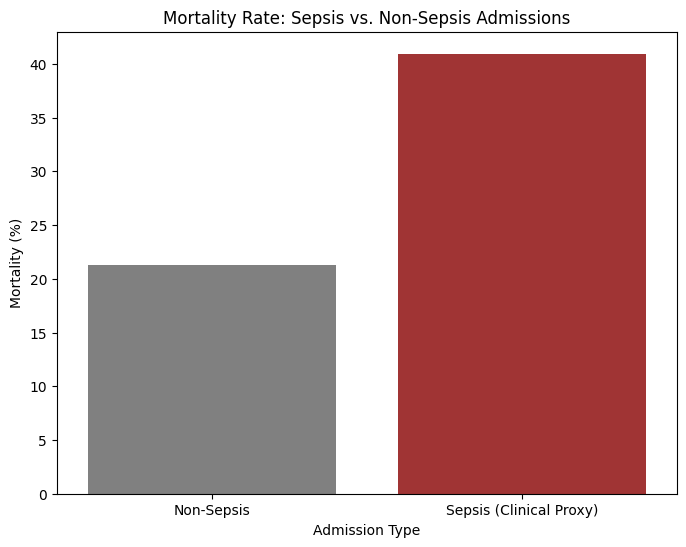

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Mortality Comparison ---")
print(sepsis_outcomes)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=sepsis_outcomes,
    x='cohort',
    y='mortality_rate_pct',
    palette={'Sepsis (Clinical Proxy)': 'firebrick', 'Non-Sepsis': 'gray'}
)
plt.title("Mortality Rate: Sepsis vs. Non-Sepsis Admissions")
plt.ylabel("Mortality (%)")
plt.xlabel("Admission Type")
plt.show()

In [43]:
%%bigquery sofa_concepts
SELECT
    c.concept_name,
    c.concept_id,
    COUNT(DISTINCT m.person_id) as patient_count
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    REGEXP_CONTAINS(LOWER(c.concept_name), r'pao2|fio2|platelet|bilirubin|creatinine|glasgow|gcs|urine output')
GROUP BY 1, 2
ORDER BY patient_count DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [44]:
sofa_concepts

concept_name  concept_id  \
0        Creatinine [Moles/volume] in Serum or Plasma     3020564   
1                       Platelets [#/volume] in Blood     3007461   
2   aPTT in Platelet poor plasma by Coagulation assay     3018677   
3                                        fio2 setting  2000000204   
4    INR in Platelet poor plasma by Coagulation assay     3022217   
5                                        Urine output     3014315   
6                      Glasgow coma score eye opening     3016335   
7                            Glasgow coma score motor     3008223   
8                           Glasgow coma score verbal     3009094   
9                            Glasgow coma score total     3007194   
10  Glomerular filtration rate [Volume Rate/Area] ...    40764999   
11  Bilirubin.conjugated+indirect [Moles/volume] i...     3043995   
12  Glomerular filtration rate [Volume Rate/Area] ...    46236952   
13  Bilirubin.conjugated [Moles/volume] in Serum o...     3005772   
14  Fibrinogen [Mass/volume] in Platelet poor plas...     3016407   
15                 Creatinine [Moles/volume] in Urine     3009508   
16  Fibrin D-dimer FEU [Mass/volume] in Platelet p...     3051714   
17                                 fio2 --placeholder  2000000205   
18  Antithrombin Ag actual/normal in Platelet poor...     3003771   
19           Creatinine [Moles/time] in 24 hour Urine     3014724   

    patient_count  
0           49923  
1           47350  
2           42933  
3           37457  
4           27484  
5           24933  
6           21367  
7           21339  
8           21333  
9           21318  
10          17623  
11          17460  
12          16890  
13          12506  
14           8429  
15           4414  
16           3897  
17           2654  
18           1135  
19            492

In [45]:
%%bigquery pao2_id
SELECT
    c.concept_name,
    c.concept_id,
    COUNT(DISTINCT m.person_id) as patient_count
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    LOWER(c.concept_name) LIKE '%oxygen [partial pressure] in arterial blood%'
GROUP BY 1, 2
ORDER BY patient_count DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [46]:
pao2_id

concept_name  concept_id  patient_count
0  Oxygen [Partial pressure] in Arterial blood     3027801          35379

In [48]:
%%bigquery sofa_scores
WITH first_day_vitals AS (
    -- 1. Extract the worst value for each component in the first 24 hours
    SELECT
        v.visit_occurrence_id,

        -- RESPIRATORY
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as fio2,
        MIN(CASE WHEN m.measurement_concept_id = 3027801 THEN m.value_as_number END) as pao2,

        -- COAGULATION
        MIN(CASE WHEN m.measurement_concept_id = 3007461 THEN m.value_as_number END) as platelets,

        -- LIVER
        MAX(CASE WHEN m.measurement_concept_id = 3043995 THEN m.value_as_number END) as bilirubin,

        -- CARDIOVASCULAR
        MIN(CASE WHEN m.measurement_concept_id = 21490852 THEN m.value_as_number END) as map,

        -- CNS
        MIN(CASE WHEN m.measurement_concept_id = 3007194 THEN m.value_as_number END) as gcs,

        -- RENAL
        MAX(CASE WHEN m.measurement_concept_id = 3020564 THEN m.value_as_number END) as creatinine,
        SUM(CASE WHEN m.measurement_concept_id = 3014315 THEN m.value_as_number END) as urine_output_24h

    FROM `visit_occurrence` v
    JOIN `measurement` m ON v.person_id = m.person_id
    WHERE
        m.measurement_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY v.visit_occurrence_id
),

first_day_vaso AS (
    -- 2. Check for vasopressor use in the first 24 hours
    SELECT
        v.visit_occurrence_id,
        MAX(CASE WHEN d.drug_concept_id IN (1321341, 1337860, 1343916) THEN 1 ELSE 0 END) as on_vasopressor
    FROM `visit_occurrence` v
    JOIN `drug_exposure` d ON v.person_id = d.person_id
    WHERE
        d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY v.visit_occurrence_id
),

sofa_points AS (
    -- 3. Calculate points for each organ system, with correct unit conversions
    SELECT
        v.visit_occurrence_id,

        CASE
            WHEN SAFE_DIVIDE(v.pao2, v.fio2 / 100) < 100 THEN 4
            WHEN SAFE_DIVIDE(v.pao2, v.fio2 / 100) < 200 THEN 3
            WHEN SAFE_DIVIDE(v.pao2, v.fio2 / 100) < 300 THEN 2
            WHEN SAFE_DIVIDE(v.pao2, v.fio2 / 100) < 400 THEN 1
            ELSE 0
        END as respiration_sofa,

        CASE
            WHEN v.platelets < 20 THEN 4
            WHEN v.platelets < 50 THEN 3
            WHEN v.platelets < 100 THEN 2
            WHEN v.platelets < 150 THEN 1
            ELSE 0
        END as coagulation_sofa,

        CASE
            WHEN v.bilirubin > 204 THEN 4
            WHEN v.bilirubin > 102 THEN 3
            WHEN v.bilirubin > 33 THEN 2
            WHEN v.bilirubin > 19 THEN 1
            ELSE 0
        END as liver_sofa,

        CASE
            WHEN d.on_vasopressor = 1 THEN 4
            WHEN v.map < 70 THEN 1
            ELSE 0
        END as cardiovascular_sofa,

        CASE
            WHEN v.gcs < 6 THEN 4
            WHEN v.gcs < 10 THEN 3
            WHEN v.gcs < 13 THEN 2
            WHEN v.gcs < 15 THEN 1
            ELSE 0
        END as cns_sofa,

        CASE
            WHEN v.creatinine > 440 OR v.urine_output_24h < 200 THEN 4
            WHEN v.creatinine > 300 OR v.urine_output_24h < 500 THEN 3
            WHEN v.creatinine > 171 THEN 2
            WHEN v.creatinine > 110 THEN 1
            ELSE 0
        END as renal_sofa -- <<< FIX: ADDED A COMMA HERE

    FROM first_day_vitals v
    LEFT JOIN first_day_vaso d ON v.visit_occurrence_id = d.visit_occurrence_id
)

-- 4. Sum the points for the final score
SELECT
    s.visit_occurrence_id,
    (s.respiration_sofa + s.coagulation_sofa + s.liver_sofa + s.cardiovascular_sofa + s.cns_sofa + s.renal_sofa) as sofa_score
FROM sofa_points s

Query is running:   0%|          |

Downloading:   0%|          |

In [55]:
%%bigquery demographics_df
SELECT
    p.person_id,
    v.visit_occurrence_id,

    -- Gender
    c.concept_name as gender,

    -- Age (Approximate based on year)
    (EXTRACT(YEAR FROM v.visit_start_date) - p.year_of_birth) as age,

    -- Length of Stay (Days)
    TIMESTAMP_DIFF(v.visit_end_datetime, v.visit_start_datetime, HOUR) / 24.0 as los_days,

    -- Outcome
    CASE WHEN d.death_date IS NOT NULL THEN 'Expired' ELSE 'Survived' END as outcome

FROM `visit_occurrence` v
JOIN `person` p ON v.person_id = p.person_id
LEFT JOIN `concept` c ON p.gender_concept_id = c.concept_id
LEFT JOIN `death` d ON p.person_id = d.person_id
WHERE
    -- Filter reasonable ages and stays > 24h
    (EXTRACT(YEAR FROM v.visit_start_date) - p.year_of_birth) BETWEEN 18 AND 100
    AND TIMESTAMP_DIFF(v.visit_end_datetime, v.visit_start_datetime, HOUR) > 24

Query is running:   0%|          |

Downloading:   0%|          |

/tmp/ipython-input-702290553.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


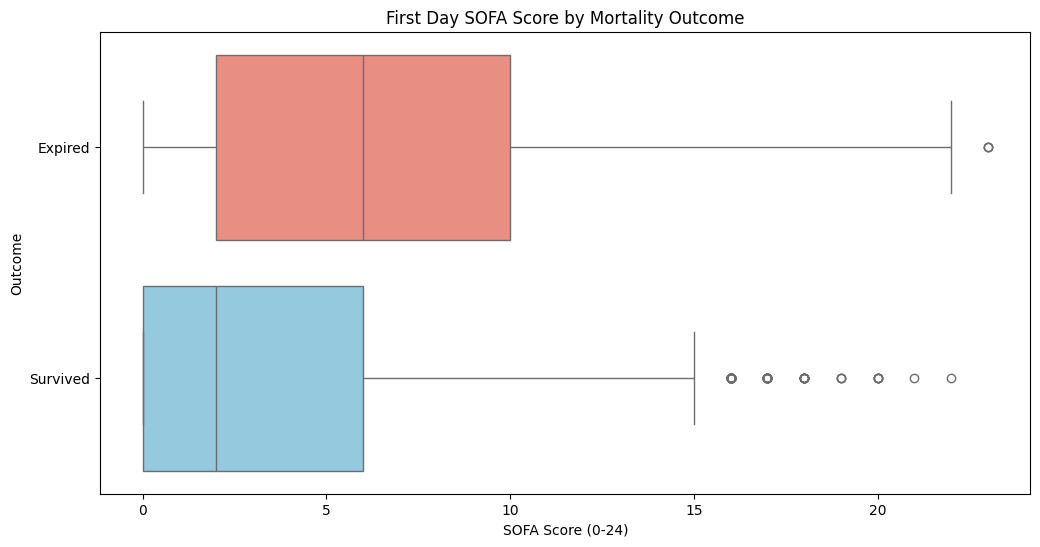

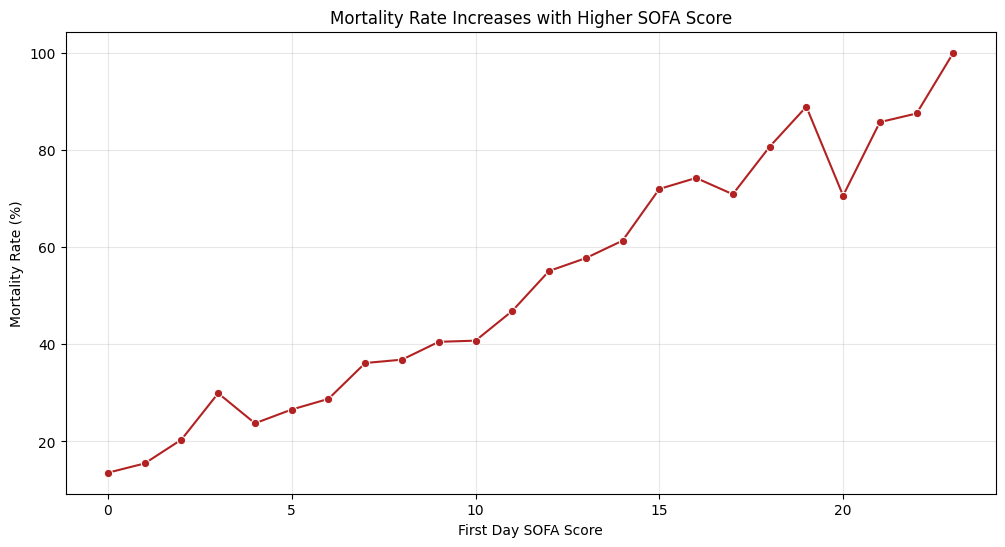

In [56]:
# --- FIX: Add the necessary imports at the top ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Merge SOFA scores with outcomes
# (Assuming you have the 'demographics_df' from previous steps)
sofa_with_outcomes = pd.merge(
    sofa_scores,
    demographics_df[['visit_occurrence_id', 'outcome']],
    on='visit_occurrence_id',
    how='inner'
)

# 2. Visualize the distribution
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=sofa_with_outcomes,
    x='sofa_score',
    y='outcome',
    orient='h',
    palette={'Survived': 'skyblue', 'Expired': 'salmon'}
)
plt.title("First Day SOFA Score by Mortality Outcome")
plt.xlabel("SOFA Score (0-24)")
plt.ylabel("Outcome")
plt.show()

# 3. Calculate Mortality Rate per SOFA score
mortality_by_sofa = sofa_with_outcomes.groupby('sofa_score')['outcome'].apply(lambda x: (x == 'Expired').mean() * 100).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=mortality_by_sofa, x='sofa_score', y='outcome', marker='o', color='firebrick')
plt.title("Mortality Rate Increases with Higher SOFA Score")
plt.xlabel("First Day SOFA Score")
plt.ylabel("Mortality Rate (%)")
plt.grid(True, alpha=0.3)
plt.show()

In [57]:
%%bigquery pneumonia_by_code
WITH pneumonia_concepts AS (
    -- 1. Find all diagnosis codes that are descendants of "Pneumonia"
    SELECT descendant_concept_id
    FROM `concept_ancestor`
    WHERE ancestor_concept_id = 255848 -- This is the OMOP parent concept for Pneumonia
)

SELECT
    v.visit_occurrence_id,
    v.person_id,
    c.concept_name as pneumonia_diagnosis,
    co.condition_start_datetime
FROM `visit_occurrence` v
JOIN `condition_occurrence` co ON v.person_id = co.person_id
JOIN `concept` c ON co.condition_concept_id = c.concept_id
WHERE
    -- Only look for conditions recorded during the visit
    co.condition_start_datetime BETWEEN v.visit_start_datetime AND v.visit_end_datetime
    -- Filter for conditions recorded in the first 24 hours (Admission Diagnosis)
    AND TIMESTAMP_DIFF(co.condition_start_datetime, v.visit_start_datetime, HOUR) <= 24
    -- Check if the diagnosis is one of the pneumonia codes
    AND co.condition_concept_id IN (SELECT descendant_concept_id FROM pneumonia_concepts)

Query is running:   0%|          |

Downloading: |          |

In [72]:
%%bigquery antibiotics_df
SELECT
    c.concept_name AS drug_name,
    COUNT(*) AS number_of_administrations
FROM
    `drug_exposure` d
JOIN
    `concept` c ON d.drug_concept_id = c.concept_id
WHERE
    -- Use REGEXP to search for a list of common IV antibiotics
    REGEXP_CONTAINS(LOWER(c.concept_name), r'ceftriaxone|meropenem|piperacillin|vancomycin|ciprofloxacin|metronidazole|cefepime|ceftazidime|amikacin|gentamicin|flucloxacillin')
GROUP BY
    c.concept_name
ORDER BY
    number_of_administrations DESC
LIMIT 50

Query is running:   0%|          |

Downloading:   0%|          |

In [73]:
antibiotics_df

drug_name  number_of_administrations
0                metronidazole                      66012
1                   vancomycin                      65044
2                  ceftriaxone                      54675
3                ciprofloxacin                      48382
4                  ceftazidime                      39673
5                    meropenem                      38039
6                 piperacillin                       5463
7                   gentamicin                       5148
8      avibactam / ceftazidime                        404
9    piperacillin / tazobactam                        325
10                    amikacin                        178
11  dexamethasone / gentamicin                         41

       drug_name  number_of_administrations
0  metronidazole                      66012
1     vancomycin                      65044
2    ceftriaxone                      54675
3  ciprofloxacin                      48382
4    ceftazidime                      39673


/tmp/ipython-input-4126013912.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


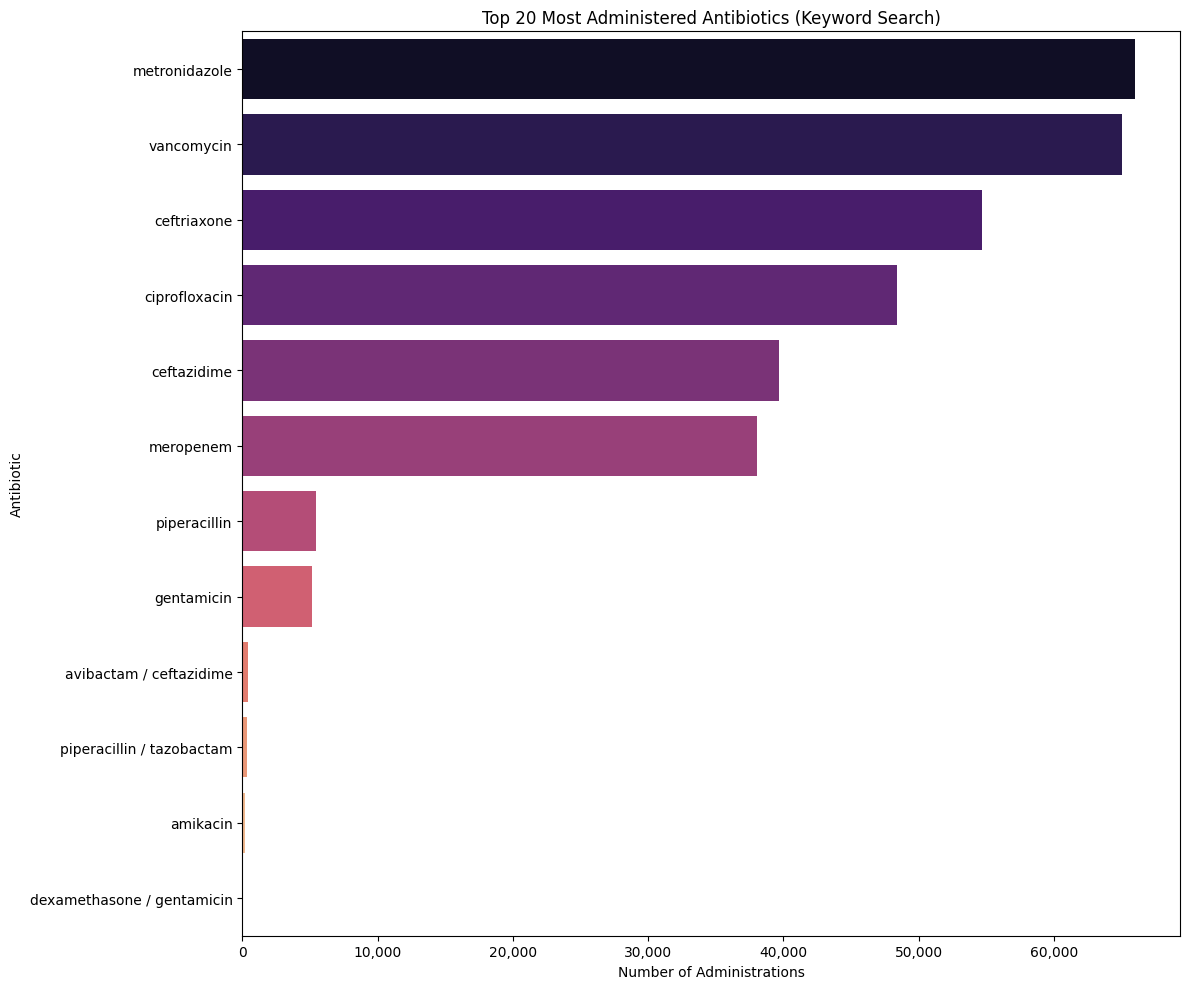

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Check if the new query found anything
if antibiotics_df.empty:
    print("Still no antibiotics found. This is highly unusual and may indicate a problem with the drug_exposure table itself.")
else:
    print(antibiotics_df.head())

    # Create the plot
    plt.figure(figsize=(12, 10))

    ax = sns.barplot(
        data=antibiotics_df.head(20),
        y="drug_name",
        x="number_of_administrations",
        palette="magma"
    )

    ax.set_title("Top 20 Most Administered Antibiotics (Keyword Search)")
    ax.set_xlabel("Number of Administrations")
    ax.set_ylabel("Antibiotic")

    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    plt.tight_layout()
    plt.show()

In [75]:
%%bigquery antibiotic_escalation_df
WITH antibiotic_tiers AS (
    -- 1. Assign a tier to each antibiotic administration
    SELECT
        d.person_id,
        d.drug_exposure_start_datetime,
        CASE
            WHEN d.drug_concept_id = 1734104 THEN 1 -- Ceftriaxone
            WHEN d.drug_concept_id IN (1742425, 1310101) THEN 2 -- Pip/Tazo, Cipro
            WHEN d.drug_concept_id = 1713332 THEN 3 -- Meropenem
            WHEN d.drug_concept_id = 1310101 THEN 4 -- Vancomycin
            ELSE 0
        END as antibiotic_tier
    FROM `drug_exposure` d
    WHERE d.drug_concept_id IN (1734104, 1742425, 1310101, 1713332, 1310101)
),

daily_max_tier AS (
    -- 2. Find the highest tier antibiotic for each patient on each day
    SELECT
        person_id,
        EXTRACT(DATE FROM drug_exposure_start_datetime) as treatment_date,
        MAX(antibiotic_tier) as max_tier
    FROM antibiotic_tiers
    GROUP BY 1, 2
),

escalations AS (
    -- 3. Use LAG() to see if the tier increased from the previous day
    SELECT
        person_id,
        treatment_date,
        max_tier,
        LAG(max_tier, 1, 0) OVER (PARTITION BY person_id ORDER BY treatment_date) as previous_day_tier
    FROM daily_max_tier
)

-- 4. Final result: Flag the escalations
SELECT
    person_id,
    treatment_date,
    previous_day_tier,
    max_tier,
    CASE
        WHEN max_tier > previous_day_tier THEN 1
        ELSE 0
    END as escalation_flag
FROM escalations
WHERE max_tier > previous_day_tier -- Only show the days where escalation occurred
ORDER BY person_id, treatment_date

Query is running:   0%|          |

Downloading:   0%|          |

In [77]:
# How many patients had their antibiotics escalated?
escalation_count = len(antibiotic_escalation_df['person_id'].unique())
print(f"Found {escalation_count} patients who required antibiotic escalation.")

# You can now merge this `escalation_flag` into your main time-series dataframe.
# A value of 1 for this feature will be a very strong predictor of deterioration in the next 24-48 hours.

Found 3633 patients who required antibiotic escalation.


In [78]:
%%bigquery ecmo_concepts
SELECT
    'Measurement' as source_table,
    c.concept_id,
    c.concept_name,
    COUNT(DISTINCT m.person_id) as unique_patients
FROM
    `measurement` m
JOIN
    `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    REGEXP_CONTAINS(LOWER(c.concept_name), r'ecmo|ecls|extracorporeal|flow rate ecmo|circuit flow|oxygenator')
GROUP BY 1, 2, 3

UNION ALL

SELECT
    'Drug' as source_table,
    c.concept_id,
    c.concept_name,
    COUNT(DISTINCT d.person_id) as unique_patients
FROM
    `drug_exposure` d
JOIN
    `concept` c ON d.drug_concept_id = c.concept_id
WHERE
    REGEXP_CONTAINS(LOWER(c.concept_name), r'ecmo|ecls|heparin|protamine') -- Heparin for anticoagulation, protamine for reversal
GROUP BY 1, 2, 3
ORDER BY unique_patients DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [79]:
%%bigquery ecmo_population
WITH ecmo_patients AS (
    -- Patients with ECMO Measurements (Machine Settings)
    SELECT DISTINCT person_id
    FROM `measurement` m
    JOIN `concept` c ON m.measurement_concept_id = c.concept_id
    WHERE REGEXP_CONTAINS(LOWER(c.concept_name), r'ecmo|ecls|extracorporeal|flow rate ecmo|circuit flow|oxygenator')

    UNION DISTINCT

    -- Patients receiving ECMO-related drugs (e.g., high dose heparin for circuit)
    SELECT DISTINCT person_id
    FROM `drug_exposure` d
    JOIN `concept` c ON d.drug_concept_id = c.concept_id
    WHERE REGEXP_CONTAINS(LOWER(c.concept_name), r'ecmo|ecls|heparin') -- Broad heparin search, might need to filter for high doses
)

SELECT
    COUNT(*) as ecmo_patient_count,
    (SELECT COUNT(DISTINCT person_id) FROM `person`) as total_population,
    ROUND(COUNT(*) / (SELECT COUNT(DISTINCT person_id) FROM `person`) * 100, 3) as prevalence_pct
FROM ecmo_patients

Query is running:   0%|          |

Downloading:   0%|          |

--- ECMO Indicators Found ---
   source_table  concept_id  \
0          Drug     1367571   
1   Measurement  2000000419   
2          Drug    35884360   
3          Drug    19054245   
4   Measurement  2000000102   
5   Measurement  2000000103   
6   Measurement  2000000104   
7   Measurement  2000000101   
8          Drug    36027314   
9   Measurement  2000000400   
10  Measurement  2000000099   
11         Drug    19091621   
12  Measurement  2000000105   
13         Drug    19113045   
14  Measurement  2000000100   

                                         concept_name  unique_patients  
0                                             heparin             9256  
1                           ecmo arterial temperature             2457  
2                                      Heparin Sodium             1673  
3                                          protamines             1025  
4                              ECMO pressure arterial              304  
5                                EC

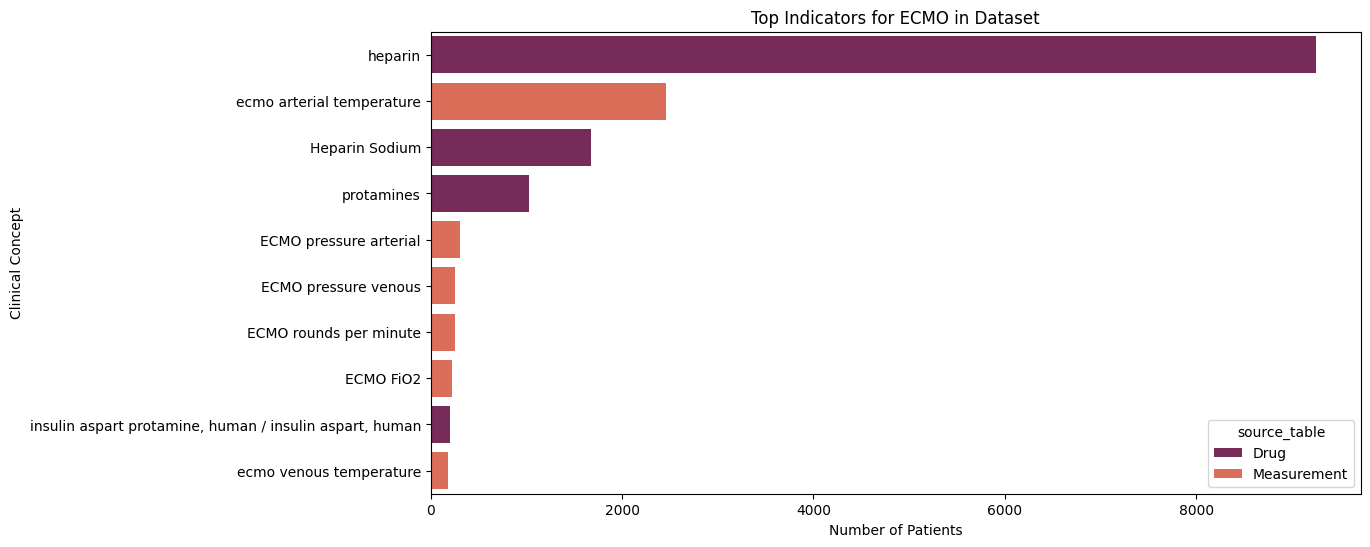

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display the concepts found for ECMO
print("--- ECMO Indicators Found ---")
print(ecmo_concepts)

# Display the total count
print("\n--- ECMO Population Stats ---")
print(ecmo_population)

# If we found concepts, visualize the top ones
if not ecmo_concepts.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=ecmo_concepts.head(10),
        x='unique_patients',
        y='concept_name',
        hue='source_table',
        dodge=False,
        palette='rocket'
    )
    plt.title("Top Indicators for ECMO in Dataset")
    plt.xlabel("Number of Patients")
    plt.ylabel("Clinical Concept")
    plt.show()

In [18]:
from google.cloud import bigquery
client = bigquery.Client()

query = """
SELECT column_name, data_type
FROM `amsterdamumcdb.van_gogh_2026_datathon.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'condition_occurrence'
"""

df = client.query(query).to_dataframe()
print(df)

                 column_name  data_type
0                  person_id      INT64
1       condition_concept_id      INT64
2       condition_start_date       DATE
3   condition_start_datetime  TIMESTAMP
4         condition_end_date       DATE
5     condition_end_datetime  TIMESTAMP
6  condition_type_concept_id      INT64
7     condition_source_value     STRING


In [19]:
from google.cloud import bigquery
client = bigquery.Client()

query = """
SELECT
    c_o.condition_type_concept_id,
    c.concept_name as type_name,
    COUNT(*) as record_count
FROM `amsterdamumcdb.van_gogh_2026_datathon.condition_occurrence` c_o
LEFT JOIN `amsterdamumcdb.van_gogh_2026_datathon.concept` c
    ON c_o.condition_type_concept_id = c.concept_id
GROUP BY 1, 2
ORDER BY 3 DESC
"""

df = client.query(query).to_dataframe()
print("--- Diagnosis Types Available ---")
print(df)

--- Diagnosis Types Available ---
   condition_type_concept_id type_name  record_count
0                      32879  Registry        277103


In [23]:
from google.cloud import bigquery
client = bigquery.Client()

query = """
SELECT column_name, data_type
FROM `amsterdamumcdb.van_gogh_2026_datathon.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'observation'
"""

df = client.query(query).to_dataframe()
print(df)

                   column_name  data_type
0                    person_id      INT64
1       observation_concept_id      INT64
2             observation_date       DATE
3         observation_datetime  TIMESTAMP
4  observation_type_concept_id      INT64
5              value_as_number    FLOAT64
6     observation_source_value     STRING
7            unit_source_value     STRING
8           value_source_value     STRING


In [28]:
%%bigquery master_matrix
WITH cohort AS (
    SELECT visit_occurrence_id, person_id, visit_start_datetime
    FROM `visit_occurrence`
    WHERE TIMESTAMP_DIFF(visit_end_datetime, visit_start_datetime, HOUR) > 24
),

features AS (
    SELECT
        c.visit_occurrence_id,

        -- 1. PHYSIOLOGY (Mean in first 24h)
        AVG(CASE WHEN m.measurement_concept_id IN (3001376, 21490872) THEN m.value_as_number END) as HR,
        AVG(CASE WHEN m.measurement_concept_id = 21490852 THEN m.value_as_number END) as MAP,
        AVG(CASE WHEN m.measurement_concept_id = 3020891 THEN m.value_as_number END) as Temp,

        -- 2. LABS (Worst value in first 24h usually defines severity)
        MAX(CASE WHEN m.measurement_concept_id = 3007293 THEN m.value_as_number END) as Lactate,
        MIN(CASE WHEN m.measurement_concept_id = 3024561 THEN m.value_as_number END) as pH,
        MAX(CASE WHEN m.measurement_concept_id IN (3020564, 3009508) THEN m.value_as_number END) as Creatinine,
        AVG(CASE WHEN m.measurement_concept_id IN (3020491, 3044242, 3040151) THEN m.value_as_number END) as Glucose,

        -- 3. INTERVENTIONS
        -- Max FiO2 (Respiratory Support)
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as Max_FiO2,
        -- RRT (Renal Support) - Binary
        MAX(CASE WHEN m.measurement_concept_id = 2000000021 THEN 1 ELSE 0 END) as RRT_Flag,

        -- 4. NEURO
        MIN(CASE WHEN m.measurement_concept_id = 3007194 THEN m.value_as_number END) as Min_GCS

    FROM cohort c
    JOIN `measurement` m ON c.person_id = m.person_id
    WHERE m.measurement_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

drugs AS (
    SELECT
        c.visit_occurrence_id,
        -- Total Vasopressor Load (Norepinephrine)
        SUM(CASE WHEN d.drug_concept_id = 1321341 THEN d.quantity ELSE 0 END) as Norepi_Total_Dose
    FROM cohort c
    JOIN `drug_exposure` d ON c.person_id = d.person_id
    WHERE d.drug_exposure_start_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

outcomes AS (
    SELECT
        v.visit_occurrence_id,
        CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as Died
    FROM `visit_occurrence` v
    LEFT JOIN `death` d ON v.person_id = d.person_id
)

SELECT
    f.*,
    COALESCE(dr.Norepi_Total_Dose, 0) as Norepi_Dose,
    o.Died
FROM features f
LEFT JOIN drugs dr ON f.visit_occurrence_id = dr.visit_occurrence_id
LEFT JOIN outcomes o ON f.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [29]:
%%bigquery pct_check
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(DISTINCT m.person_id) as unique_patients
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    REGEXP_CONTAINS(LOWER(c.concept_name), r'procalciton|pct')
GROUP BY 1, 2
ORDER BY unique_patients DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
pct_check

concept_id                                    concept_name  unique_patients
0     3046279  Procalcitonin [Mass/volume] in Serum or Plasma              967

In [33]:
%%bigquery vasopressor_ids
SELECT
    c.concept_id,
    c.concept_name,
    c.vocabulary_id,
    COUNT(*) as usage_count
FROM
    `drug_exposure` d
JOIN
    `concept` c ON d.drug_concept_id = c.concept_id
WHERE
    -- Search for all three drugs using broad keywords
    REGEXP_CONTAINS(LOWER(c.concept_name), r'norepinephrine|noradrenaline|epinephrine|adrenaline|vasopressin')
GROUP BY
    1, 2, 3
ORDER BY
    usage_count DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [34]:
vasopressor_ids

concept_id                concept_name vocabulary_id  usage_count
0     1321341              norepinephrine        RxNorm       547514
1     1343916                 epinephrine        RxNorm         4938
2    36030108     articaine / epinephrine        RxNorm          114
3    36028719  lidocaine / norepinephrine        RxNorm          112
4    36029293   bupivacaine / epinephrine        RxNorm            1

In [35]:
%%bigquery master_matrix
WITH cohort AS (
    SELECT visit_occurrence_id, person_id, visit_start_datetime
    FROM `visit_occurrence`
    WHERE TIMESTAMP_DIFF(visit_end_datetime, visit_start_datetime, HOUR) > 24
),

features AS (
    SELECT
        c.visit_occurrence_id,

        -- 1. PHYSIOLOGY
        AVG(CASE WHEN m.measurement_concept_id IN (3001376, 21490872) THEN m.value_as_number END) as HR,
        AVG(CASE WHEN m.measurement_concept_id = 21490852 THEN m.value_as_number END) as MAP,
        AVG(CASE WHEN m.measurement_concept_id = 3020891 THEN m.value_as_number END) as Temp,

        -- 2. LABS
        MAX(CASE WHEN m.measurement_concept_id = 3007293 THEN m.value_as_number END) as Lactate,
        MIN(CASE WHEN m.measurement_concept_id = 3024561 THEN m.value_as_number END) as pH,
        MAX(CASE WHEN m.measurement_concept_id IN (3020564, 3009508) THEN m.value_as_number END) as Creatinine,
        AVG(CASE WHEN m.measurement_concept_id IN (3020491, 3044242, 3040151) THEN m.value_as_number END) as Glucose,

        -- PCT (Using the ID you confirmed: 3046279)
        MAX(CASE WHEN m.measurement_concept_id = 3046279 THEN m.value_as_number END) as PCT,

        -- 3. INTERVENTIONS
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as Max_FiO2,
        MAX(CASE WHEN m.measurement_concept_id = 2000000021 THEN 1 ELSE 0 END) as RRT_Flag,

        -- 4. NEURO
        MIN(CASE WHEN m.measurement_concept_id = 3007194 THEN m.value_as_number END) as Min_GCS

    FROM cohort c
    JOIN `measurement` m ON c.person_id = m.person_id
    WHERE m.measurement_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

drugs AS (
    SELECT
        c.visit_occurrence_id,

        -- Norepinephrine (Confirmed ID: 1321341)
        SUM(CASE WHEN d.drug_concept_id = 1321341 THEN d.quantity ELSE 0 END) as Norepi_Dose,

        -- Epinephrine/Adrenaline (Confirmed ID: 1343916)
        SUM(CASE WHEN d.drug_concept_id = 1343916 THEN d.quantity ELSE 0 END) as Adrenaline_Dose,

        -- Vasopressin (Fallback search since ID was missing)
        SUM(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'vasopressin|argipressin|terlipressin') THEN d.quantity ELSE 0 END) as Vasopressin_Dose

    FROM cohort c
    JOIN `drug_exposure` d ON c.person_id = d.person_id
    JOIN `concept` con ON d.drug_concept_id = con.concept_id
    WHERE d.drug_exposure_start_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

outcomes AS (
    SELECT
        v.visit_occurrence_id,
        CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as Died
    FROM `visit_occurrence` v
    LEFT JOIN `death` d ON v.person_id = d.person_id
)

SELECT
    f.*,
    COALESCE(dr.Norepi_Dose, 0) as Norepi_Dose,
    COALESCE(dr.Adrenaline_Dose, 0) as Adrenaline_Dose,
    COALESCE(dr.Vasopressin_Dose, 0) as Vasopressin_Dose,
    o.Died
FROM features f
LEFT JOIN drugs dr ON f.visit_occurrence_id = dr.visit_occurrence_id
LEFT JOIN outcomes o ON f.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [39]:
%%bigquery lactate_check
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(*) as count
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE REGEXP_CONTAINS(LOWER(c.concept_name), r'lactat|lactic')
GROUP BY 1, 2
ORDER BY count DESC
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

In [40]:
lactate_check

concept_id                                       concept_name   count
0     3018405           Lactate [Moles/volume] in Arterial blood  518880
1     3047181                    Lactate [Moles/volume] in Blood  192007
2     3016436  Lactate dehydrogenase [Enzymatic activity/volu...  125844
3     3008037             Lactate [Moles/volume] in Venous blood   28451
4     3005949       Lactate [Moles/volume] in Mixed venous blood    5953

In [41]:
%%bigquery master_matrix
WITH cohort AS (
    SELECT visit_occurrence_id, person_id, visit_start_datetime
    FROM `visit_occurrence`
    WHERE TIMESTAMP_DIFF(visit_end_datetime, visit_start_datetime, HOUR) > 24
),

features AS (
    SELECT
        c.visit_occurrence_id,

        -- 1. PHYSIOLOGY
        AVG(CASE WHEN m.measurement_concept_id IN (3001376, 21490872) THEN m.value_as_number END) as HR,
        AVG(CASE WHEN m.measurement_concept_id = 21490852 THEN m.value_as_number END) as MAP,
        AVG(CASE WHEN m.measurement_concept_id = 3020891 THEN m.value_as_number END) as Temp,

        -- 2. LABS (FIXED LACTATE)
        -- We take the MAX value to capture the peak severity
        MAX(CASE WHEN m.measurement_concept_id IN (3018405, 3047181, 3008037) THEN m.value_as_number END) as Lactate,

        MIN(CASE WHEN m.measurement_concept_id = 3024561 THEN m.value_as_number END) as pH,
        MAX(CASE WHEN m.measurement_concept_id IN (3020564, 3009508) THEN m.value_as_number END) as Creatinine,
        AVG(CASE WHEN m.measurement_concept_id IN (3020491, 3044242, 3040151) THEN m.value_as_number END) as Glucose,
        MAX(CASE WHEN m.measurement_concept_id = 3046279 THEN m.value_as_number END) as PCT,

        -- 3. INTERVENTIONS
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as Max_FiO2,
        MAX(CASE WHEN m.measurement_concept_id = 2000000021 THEN 1 ELSE 0 END) as RRT_Flag,

        -- 4. NEURO
        MIN(CASE WHEN m.measurement_concept_id = 3007194 THEN m.value_as_number END) as Min_GCS

    FROM cohort c
    JOIN `measurement` m ON c.person_id = m.person_id
    WHERE m.measurement_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

drugs AS (
    SELECT
        c.visit_occurrence_id,
        SUM(CASE WHEN d.drug_concept_id = 1321341 THEN d.quantity ELSE 0 END) as Norepi_Dose,
        SUM(CASE WHEN d.drug_concept_id = 1343916 THEN d.quantity ELSE 0 END) as Adrenaline_Dose,
        SUM(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'vasopressin|argipressin') THEN d.quantity ELSE 0 END) as Vasopressin_Dose
    FROM cohort c
    JOIN `drug_exposure` d ON c.person_id = d.person_id
    JOIN `concept` con ON d.drug_concept_id = con.concept_id
    WHERE d.drug_exposure_start_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

outcomes AS (
    SELECT
        v.visit_occurrence_id,
        CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as Died
    FROM `visit_occurrence` v
    LEFT JOIN `death` d ON v.person_id = d.person_id
)

SELECT
    f.*,
    COALESCE(dr.Norepi_Dose, 0) as Norepi_Dose,
    COALESCE(dr.Adrenaline_Dose, 0) as Adrenaline_Dose,
    COALESCE(dr.Vasopressin_Dose, 0) as Vasopressin_Dose,
    o.Died
FROM features f
LEFT JOIN drugs dr ON f.visit_occurrence_id = dr.visit_occurrence_id
LEFT JOIN outcomes o ON f.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [42]:
master_matrix

visit_occurrence_id         HR        MAP       Temp  Lactate    pH  \
0                     1277  73.405797  82.130435  92.332857      1.0  36.0   
1                    33184  80.983471  68.716049  66.554000      5.4  17.0   
2                    75094  80.882353        NaN        NaN      NaN  33.0   
3                    56573  77.246377        NaN  67.966783      2.0  17.0   
4                    75026  64.212598  71.059829  67.298182      1.9   NaN   
...                    ...        ...        ...        ...      ...   ...   
49267                35316        NaN  75.727267        NaN      NaN   NaN   
49268                29931        NaN        NaN        NaN      NaN   NaN   
49269                 3243        NaN        NaN        NaN      NaN   NaN   
49270                27979        NaN        NaN        NaN      NaN   NaN   
49271                33434        NaN        NaN        NaN      NaN   NaN   

       Creatinine   Glucose  PCT  Max_FiO2  RRT_Flag  Min_GCS   Norepi_Dose  \
0       89.000000  6.600000  NaN      50.0         0      3.0    352.000000   
1      167.000000  9.727273  NaN      98.0         0      NaN  18842.663742   
2      610.000000  8.300000  NaN       NaN         0      NaN    458.425510   
3      116.000000       NaN  NaN       NaN         0      5.0    145.780462   
4       66.000000  6.520000  NaN     100.0         0      3.0   3670.256436   
...           ...       ...  ...       ...       ...      ...           ...   
49267   46.000001  6.050000  NaN       NaN         0      NaN      0.000000   
49268         NaN       NaN  NaN       NaN         0      NaN      0.000000   
49269         NaN       NaN  NaN       NaN         0      NaN      0.000000   
49270         NaN       NaN  NaN       NaN         0      NaN      0.000000   
49271         NaN       NaN  NaN       NaN         0      NaN      0.000000   

       Adrenaline_Dose  Vasopressin_Dose  Died  
0                  0.0               0.0     0  
1                  0.0               0.0     0  
2                  0.0               0.0     0  
3                  0.0               0.0     0  
4                  0.0               0.0     0  
...                ...               ...   ...  
49267              0.0               0.0     0  
49268              0.0               0.0     1  
49269              0.0               0.0     0  
49270              0.0               0.0     0  
49271              0.0               0.0     0  

[49272 rows x 16 columns]

--- Missing Data Report (%) ---
PCT           98.751827
Temp          81.299724
Min_GCS       71.009904
HR            59.049765
pH            55.445283
Max_FiO2      49.328219
Lactate       43.142150
MAP           37.729339
Glucose       37.398522
Creatinine    33.235915
dtype: float64

Good news: No columns are 100% empty.


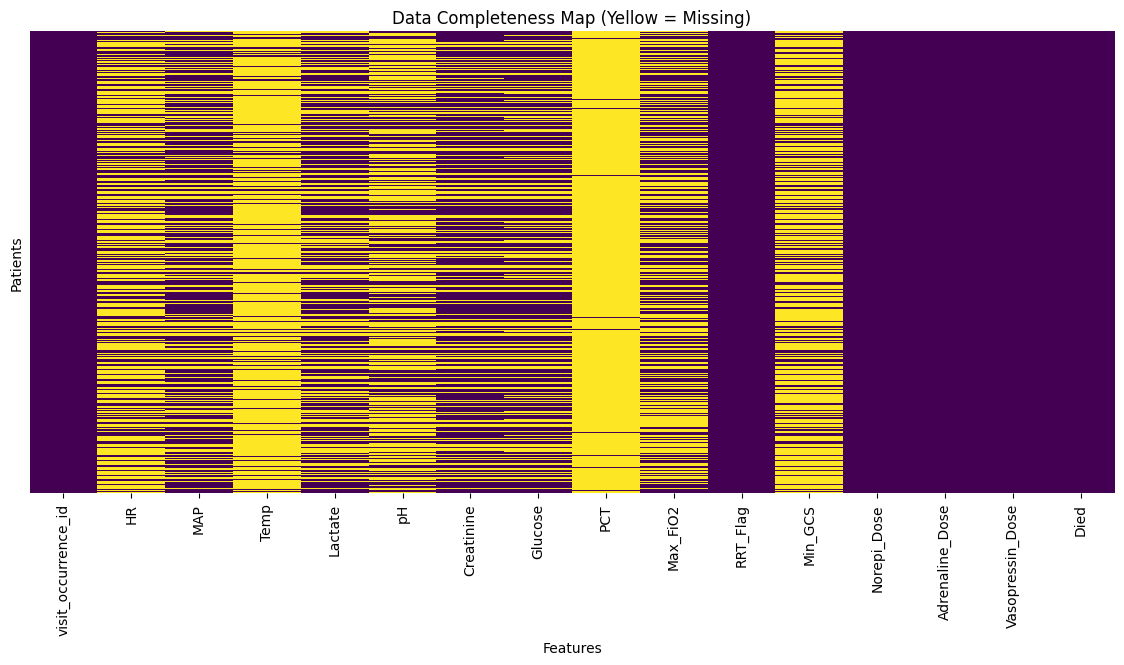

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate Missing Percentage per Column
missing_stats = master_matrix.isnull().mean() * 100
missing_stats = missing_stats.sort_values(ascending=False)

print("--- Missing Data Report (%) ---")
print(missing_stats[missing_stats > 0]) # Only show columns with missing data

# 2. Check for "Dead" Columns (100% Missing)
# These will crash PCA and must be dropped
dead_cols = missing_stats[missing_stats == 100].index.tolist()
if dead_cols:
    print(f"\nCRITICAL WARNING: The following columns are 100% empty: {dead_cols}")
    print("This usually means the Concept ID used in SQL was incorrect for this dataset.")
else:
    print("\nGood news: No columns are 100% empty.")

# 3. Visualize the "Holes" in the Data
plt.figure(figsize=(14, 6))
sns.heatmap(master_matrix.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Data Completeness Map (Yellow = Missing)")
plt.xlabel("Features")
plt.ylabel("Patients")
plt.show()

In [45]:
%%bigquery master_matrix
WITH cohort AS (
    SELECT visit_occurrence_id, person_id, visit_start_datetime
    FROM `visit_occurrence`
    WHERE TIMESTAMP_DIFF(visit_end_datetime, visit_start_datetime, HOUR) > 24
),

features AS (
    SELECT
        c.visit_occurrence_id,

        -- 1. PHYSIOLOGY (Broad Search)
        -- HR: Combine EKG, PulseOx, Pleth, Scope
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'heart rate') THEN m.value_as_number END) as HR,

        -- MAP: Combine Invasive (Arterial) and Non-Invasive (Cuff)
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'mean blood pressure|mean arterial pressure') THEN m.value_as_number END) as MAP,

        -- Temp: Combine Body, Rectal, Axillary, Esophageal, Bladder
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'temperature') THEN m.value_as_number END) as Temp,

        -- 2. LABS (Specific IDs are usually safer for labs, but we add names to be safe)
        MAX(CASE WHEN m.measurement_concept_id IN (3018405, 3047181, 3008037) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'lactate') THEN m.value_as_number END) as Lactate,
        MIN(CASE WHEN m.measurement_concept_id = 3024561 OR REGEXP_CONTAINS(LOWER(con.concept_name), r'ph ') THEN m.value_as_number END) as pH,
        MAX(CASE WHEN m.measurement_concept_id IN (3020564, 3009508) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'creatinine') THEN m.value_as_number END) as Creatinine,
        AVG(CASE WHEN m.measurement_concept_id IN (3020491, 3044242, 3040151) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'glucose') THEN m.value_as_number END) as Glucose,

        -- PCT (Specific ID is best, but adding name search)
        MAX(CASE WHEN m.measurement_concept_id = 3046279 OR REGEXP_CONTAINS(LOWER(con.concept_name), r'procalcitonin') THEN m.value_as_number END) as PCT,

        -- 3. INTERVENTIONS
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as Max_FiO2,
        MAX(CASE WHEN m.measurement_concept_id = 2000000021 THEN 1 ELSE 0 END) as RRT_Flag,

        -- 4. NEURO
        MIN(CASE WHEN m.measurement_concept_id = 3007194 THEN m.value_as_number END) as Min_GCS

    FROM cohort c
    JOIN `measurement` m ON c.person_id = m.person_id
    JOIN `concept` con ON m.measurement_concept_id = con.concept_id
    WHERE m.measurement_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

drugs AS (
    SELECT
        c.visit_occurrence_id,
        SUM(CASE WHEN d.drug_concept_id = 1321341 THEN d.quantity ELSE 0 END) as Norepi_Dose,
        SUM(CASE WHEN d.drug_concept_id = 1343916 THEN d.quantity ELSE 0 END) as Adrenaline_Dose,
        SUM(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'vasopressin|argipressin') THEN d.quantity ELSE 0 END) as Vasopressin_Dose
    FROM cohort c
    JOIN `drug_exposure` d ON c.person_id = d.person_id
    JOIN `concept` con ON d.drug_concept_id = con.concept_id
    WHERE d.drug_exposure_start_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

outcomes AS (
    SELECT
        v.visit_occurrence_id,
        CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as Died
    FROM `visit_occurrence` v
    LEFT JOIN `death` d ON v.person_id = d.person_id
)

SELECT
    f.*,
    COALESCE(dr.Norepi_Dose, 0) as Norepi_Dose,
    COALESCE(dr.Adrenaline_Dose, 0) as Adrenaline_Dose,
    COALESCE(dr.Vasopressin_Dose, 0) as Vasopressin_Dose,
    o.Died
FROM features f
LEFT JOIN drugs dr ON f.visit_occurrence_id = dr.visit_occurrence_id
LEFT JOIN outcomes o ON f.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate Missing Percentage per Column
missing_stats = master_matrix.isnull().mean() * 100
missing_stats = missing_stats.sort_values(ascending=False)

print("--- Missing Data Report (After Fix) ---")
print(missing_stats[missing_stats > 0])

--- Missing Data Report (After Fix) ---
PCT           98.751827
Min_GCS       71.009904
Max_FiO2      49.328219
Lactate       40.150593
pH            36.722682
Glucose       36.393895
MAP           33.885371
Creatinine    33.221708
Temp          23.013070
HR             0.107566
dtype: float64


In [47]:
%%bigquery nibp_check
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(*) as count
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    REGEXP_CONTAINS(LOWER(c.concept_name), r'non-invasive mean|cuff mean|nibp mean')
GROUP BY 1, 2
ORDER BY count DESC
LIMIT 5

Query is running:   0%|          |

Downloading: |          |

In [48]:
nibp_check

Empty DataFrame
Columns: [concept_id, concept_name, count]
Index: []

In [49]:
%%bigquery o2_flow_check
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(*) as count,
    ROUND(AVG(m.value_as_number), 1) as avg_val,
    m.unit_source_value
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    -- Search for Flow, Liters, or Administration
    REGEXP_CONTAINS(LOWER(c.concept_name), r'o2 flow|oxygen flow|l/min|liters|toediening')
    -- Exclude the ventilator concepts we already know (which are usually %)
    AND NOT REGEXP_CONTAINS(LOWER(c.concept_name), r'fio2|fraction')
GROUP BY 1, 2, 5
ORDER BY count DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [50]:
o2_flow_check

concept_id              concept_name    count  avg_val unit_source_value
0     3005629  Inhaled oxygen flow rate  1374369      5.2             L/min
1     3005629  Inhaled oxygen flow rate   895891      3.4                 l
2     3005629  Inhaled oxygen flow rate   791414     85.1             l/min
3     3005629  Inhaled oxygen flow rate      128      5.8                  
4     3005629  Inhaled oxygen flow rate       98     28.9              Geen
5     3005629  Inhaled oxygen flow rate        3     48.3             cmH2O

In [51]:
%%bigquery resp_support_df
WITH cohort AS (
    SELECT visit_occurrence_id, person_id, visit_start_datetime
    FROM `visit_occurrence`
    WHERE TIMESTAMP_DIFF(visit_end_datetime, visit_start_datetime, HOUR) > 24
),

resp_data AS (
    SELECT
        c.visit_occurrence_id,

        -- 1. VENTILATOR SIGNALS (Invasive)
        -- PEEP (ID 3022875) or Tidal Volume (ID 36303816)
        MAX(CASE WHEN m.measurement_concept_id IN (3022875, 36303816) THEN 1 ELSE 0 END) as is_vented,

        -- 2. OXYGEN FLOW SIGNALS (Non-Invasive)
        -- Use the IDs found in Step 1.
        -- Common Amsterdam IDs for O2 Flow: 3029331 (O2 flow), 3010394 (O2 administration)
        -- We use a broad REGEXP to be safe
        MAX(CASE
            WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'o2 flow|oxygen flow') AND m.value_as_number > 0
            THEN m.value_as_number
            ELSE NULL
        END) as o2_flow_lmin,

        -- 3. FiO2 (Percentage)
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as recorded_fio2

    FROM cohort c
    JOIN `measurement` m ON c.person_id = m.person_id
    JOIN `concept` con ON m.measurement_concept_id = con.concept_id
    WHERE
        m.measurement_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
        AND (
            m.measurement_concept_id IN (3022875, 36303816, 2000000204) -- Vent IDs
            OR REGEXP_CONTAINS(LOWER(con.concept_name), r'o2 flow|oxygen flow') -- Flow IDs
        )
    GROUP BY c.visit_occurrence_id
),

outcomes AS (
    SELECT visit_occurrence_id, CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as Died
    FROM `visit_occurrence` v LEFT JOIN `death` d ON v.person_id = d.person_id
)

SELECT
    r.*,
    o.Died,
    -- Define the Respiratory State
    CASE
        WHEN r.is_vented = 1 THEN 'Mechanical Ventilation'
        WHEN r.o2_flow_lmin > 0 THEN 'Supplemental O2'
        WHEN r.recorded_fio2 > 21 THEN 'Supplemental O2 (Known %)'
        ELSE 'Room Air / Unknown'
    END as resp_state
FROM resp_data r
LEFT JOIN outcomes o ON r.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [52]:
resp_support_df

visit_occurrence_id  is_vented  o2_flow_lmin  recorded_fio2  Died  \
0                    50441          1           1.0     100.000000     0   
1                    42684          1           5.0     100.000000     0   
2                     3485          1           NaN      50.299999     0   
3                    35074          1           NaN      60.799999     1   
4                     9449          1           NaN      80.000000     0   
...                    ...        ...           ...            ...   ...   
43398                 8126          0           5.0            NaN     0   
43399                11978          0          15.0            NaN     1   
43400                30699          0           5.0            NaN     0   
43401                11404          0           8.0            NaN     0   
43402                11396          0           8.0            NaN     1   

                   resp_state  
0      Mechanical Ventilation  
1      Mechanical Ventilation  
2      Mechanical Ventilation  
3      Mechanical Ventilation  
4      Mechanical Ventilation  
...                       ...  
43398         Supplemental O2  
43399         Supplemental O2  
43400         Supplemental O2  
43401         Supplemental O2  
43402         Supplemental O2  

[43403 rows x 6 columns]

In [53]:
%%bigquery master_matrix
WITH cohort AS (
    SELECT visit_occurrence_id, person_id, visit_start_datetime
    FROM `visit_occurrence`
    WHERE TIMESTAMP_DIFF(visit_end_datetime, visit_start_datetime, HOUR) > 24
),

features AS (
    SELECT
        c.visit_occurrence_id,

        -- 1. PHYSIOLOGY
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'heart rate') THEN m.value_as_number END) as HR,
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'mean blood pressure|mean arterial pressure|non-invasive mean|nibp mean') THEN m.value_as_number END) as MAP,
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'temperature') THEN m.value_as_number END) as Temp,

        -- 2. LABS
        MAX(CASE WHEN m.measurement_concept_id IN (3018405, 3047181, 3008037) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'lactate') THEN m.value_as_number END) as Lactate,
        MIN(CASE WHEN m.measurement_concept_id = 3024561 OR REGEXP_CONTAINS(LOWER(con.concept_name), r'ph ') THEN m.value_as_number END) as pH,
        MAX(CASE WHEN m.measurement_concept_id IN (3020564, 3009508) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'creatinine') THEN m.value_as_number END) as Creatinine,
        AVG(CASE WHEN m.measurement_concept_id IN (3020491, 3044242, 3040151) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'glucose') THEN m.value_as_number END) as Glucose,
        MAX(CASE WHEN m.measurement_concept_id = 3046279 THEN m.value_as_number END) as PCT,

        -- 3. RESPIRATORY SUPPORT (The Fix)
        -- Recorded FiO2 %
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 OR REGEXP_CONTAINS(LOWER(con.concept_name), r'fio2') THEN m.value_as_number END) as Recorded_FiO2,
        -- O2 Flow (Liters/min) - ID 3005629
        MAX(CASE WHEN m.measurement_concept_id = 3005629 THEN m.value_as_number END) as O2_Flow,
        -- PEEP (To detect Ventilator)
        MAX(CASE WHEN m.measurement_concept_id = 3022875 THEN m.value_as_number END) as PEEP,

        -- 4. OTHER INTERVENTIONS
        MAX(CASE WHEN m.measurement_concept_id = 2000000021 THEN 1 ELSE 0 END) as RRT_Flag,
        MIN(CASE WHEN m.measurement_concept_id = 3007194 THEN m.value_as_number END) as Min_GCS

    FROM cohort c
    JOIN `measurement` m ON c.person_id = m.person_id
    JOIN `concept` con ON m.measurement_concept_id = con.concept_id
    WHERE m.measurement_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

drugs AS (
    SELECT
        c.visit_occurrence_id,
        SUM(CASE WHEN d.drug_concept_id = 1321341 THEN d.quantity ELSE 0 END) as Norepi_Dose,
        SUM(CASE WHEN d.drug_concept_id = 1343916 THEN d.quantity ELSE 0 END) as Adrenaline_Dose,
        SUM(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'vasopressin|argipressin') THEN d.quantity ELSE 0 END) as Vasopressin_Dose
    FROM cohort c
    JOIN `drug_exposure` d ON c.person_id = d.person_id
    JOIN `concept` con ON d.drug_concept_id = con.concept_id
    WHERE d.drug_exposure_start_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

outcomes AS (
    SELECT
        v.visit_occurrence_id,
        CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as Died
    FROM `visit_occurrence` v
    LEFT JOIN `death` d ON v.person_id = d.person_id
)

SELECT
    f.*,
    COALESCE(dr.Norepi_Dose, 0) as Norepi_Dose,
    COALESCE(dr.Adrenaline_Dose, 0) as Adrenaline_Dose,
    COALESCE(dr.Vasopressin_Dose, 0) as Vasopressin_Dose,
    o.Died
FROM features f
LEFT JOIN drugs dr ON f.visit_occurrence_id = dr.visit_occurrence_id
LEFT JOIN outcomes o ON f.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [54]:
master_matrix

visit_occurrence_id          HR        MAP       Temp  Lactate    pH  \
0                    49291  105.333333        NaN  39.000000      NaN   NaN   
1                    23686   79.565217  65.250003  34.807143      3.3  7.23   
2                    51394   81.800000  84.719998  36.460000    190.0  7.20   
3                     1770  107.440000        NaN  39.000000      NaN   NaN   
4                    20281   75.331429  67.449153  87.602845      3.4  7.29   
...                    ...         ...        ...        ...      ...   ...   
49267                72078   87.560000        NaN  36.000000      NaN   NaN   
49268                78544   84.692308        NaN        NaN      NaN   NaN   
49269                26557  113.750000        NaN        NaN      NaN   NaN   
49270                 8168  119.083333        NaN        NaN      NaN   NaN   
49271                18540   71.000000        NaN  37.000000      NaN   NaN   

       Creatinine    Glucose  PCT  Recorded_FiO2  O2_Flow  PEEP  RRT_Flag  \
0             NaN        NaN  NaN            NaN      NaN   NaN         1   
1      262.999995   6.023077  NaN     100.000000      NaN  20.0         1   
2      915.999992   4.375000  NaN      50.099998      NaN  10.0         1   
3             NaN        NaN  NaN            NaN      NaN   NaN         1   
4      126.000000  10.527273  NaN     100.000000      3.0   5.5         0   
...           ...        ...  ...            ...      ...   ...       ...   
49267         NaN        NaN  NaN            NaN      2.0   NaN         0   
49268         NaN        NaN  NaN            NaN      2.0   NaN         0   
49269         NaN        NaN  NaN            NaN      8.0   NaN         0   
49270         NaN        NaN  NaN            NaN      5.0   NaN         0   
49271         NaN        NaN  NaN            NaN      2.0   NaN         0   

       Min_GCS   Norepi_Dose  Adrenaline_Dose  Vasopressin_Dose  Died  
0          NaN  0.000000e+00              0.0               0.0     0  
1          NaN  1.267944e-01              0.0               0.0     1  
2          NaN  2.990684e-01              0.0               0.0     0  
3          NaN  0.000000e+00              0.0               0.0     0  
4          NaN  1.404568e+07              0.0               0.0     0  
...        ...           ...              ...               ...   ...  
49267      NaN  0.000000e+00              0.0               0.0     0  
49268      NaN  0.000000e+00              0.0               0.0     0  
49269      NaN  0.000000e+00              0.0               0.0     0  
49270      NaN  0.000000e+00              0.0               0.0     0  
49271      NaN  0.000000e+00              0.0               0.0     0  

[49272 rows x 18 columns]

In [55]:
# Define the core physiological columns
core_vitals = ['HR', 'MAP', 'Temp', 'Lactate', 'pH', 'Creatinine', 'Glucose']

# Count how many core vitals are missing per patient
missing_counts = master_matrix[core_vitals].isnull().sum(axis=1)

# Identify patients missing ALL core vitals
ghost_patients = master_matrix[missing_counts == len(core_vitals)]
print(f"Found {len(ghost_patients)} 'Ghost' patients (Missing 100% of physiology).")

Found 33 'Ghost' patients (Missing 100% of physiology).


--- Data Range Check (Look for impossible Min/Max) ---
                                min        50%          max
visit_occurrence_id             1.0    39893.0      79836.0
HR                        19.430657  83.958333  1706.318681
MAP                 -1087110.666667       76.5      44663.0
Temp                      -59.56667  60.957207       7807.0
Lactate                         0.0        6.8      38662.0
pH                              0.0       7.32         43.0
Creatinine                      0.0       90.0       2398.0
Glucose                         0.0      8.125    67.858824
PCT                            0.02       0.55   347.000007
Recorded_FiO2                   0.0       60.0       7083.0
O2_Flow                         0.0        5.0       5080.0
PEEP                            0.0        8.0       6540.6
RRT_Flag                        0.0        0.0          1.0
Min_GCS                         3.0       11.0         15.0
Norepi_Dose                     0.0        0.

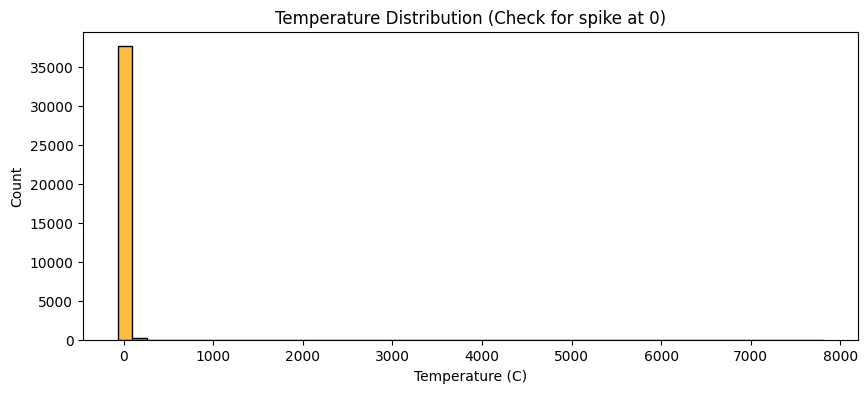

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Summary Statistics
# Look at the 'min' and 'max' rows carefully
print("--- Data Range Check (Look for impossible Min/Max) ---")
print(master_matrix.describe().T[['min', '50%', 'max']])

# 2. Define "Bad Data" Rules
# These thresholds are based on human physiology
bad_data_mask = (
    (master_matrix['HR'] < 20) | (master_matrix['HR'] > 300) |
    (master_matrix['MAP'] < 20) | (master_matrix['MAP'] > 300) |
    (master_matrix['Temp'] < 25) | (master_matrix['Temp'] > 45) |
    (master_matrix['pH'] < 6.5) | (master_matrix['pH'] > 8.0)
)

# Count how many patients violate these rules
bad_patients = master_matrix[bad_data_mask]
print(f"\nFound {len(bad_patients)} patients with physiologically impossible values.")

# 3. Visualize the "Ghost" Temperature (Common Error)
plt.figure(figsize=(10, 4))
sns.histplot(master_matrix['Temp'], bins=50, color='orange')
plt.title("Temperature Distribution (Check for spike at 0)")
plt.xlabel("Temperature (C)")
plt.show()

In [57]:
import numpy as np

# Create a fresh copy
df_clean = master_matrix.copy()

# --- 1. DEFINE PHYSIOLOGICAL LIMITS ---
# Any value outside these ranges is considered an error and replaced with NaN
limits = {
    'HR': (30, 200),           # Beats per minute
    'MAP': (30, 250),          # mmHg
    'Temp': (30, 42),          # Celsius (30=Hypothermia, 42=Extreme Fever)
    'pH': (6.8, 7.7),          # Acid/Base
    'Lactate': (0, 30),        # mmol/L (30 is extremely high but possible)
    'Glucose': (1, 50),        # mmol/L
    'Creatinine': (10, 1000),  # umol/L
    'PCT': (0, 100),           # ng/mL
    'Recorded_FiO2': (21, 100),# %
    'O2_Flow': (0, 70),        # L/min (High flow maxes around 60-70)
    'PEEP': (0, 30)            # cmH2O
}

# --- 2. APPLY LIMITS (Replace Outliers with NaN) ---
for col, (min_val, max_val) in limits.items():
    if col in df_clean.columns:
        # Find bad values
        bad_mask = (df_clean[col] < min_val) | (df_clean[col] > max_val)
        # Replace with NaN
        df_clean.loc[bad_mask, col] = np.nan

# --- 3. IMPUTE NaNs WITH MEDIAN ---
# Now that the crazy outliers (like Temp 7807) are gone, the Median will be correct.
for col in limits.keys():
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# --- 4. HANDLE DRUGS (Log Transformation) ---
# Because the doses range from 0 to 300 Million (likely unit errors),
# we use Log Scale to shrink the massive numbers without losing the ranking.
drug_cols = ['Norepi_Dose', 'Adrenaline_Dose', 'Vasopressin_Dose']
for col in drug_cols:
    # Fill NA with 0 first
    df_clean[col] = df_clean[col].fillna(0)
    # Clip negative values to 0
    df_clean[col] = df_clean[col].clip(lower=0)
    # Apply Log1p (Log of x+1) to handle 0s and shrink outliers
    df_clean[col] = np.log1p(df_clean[col])

# --- 5. RE-CALCULATE FiO2 ---
# Now that Recorded_FiO2 and O2_Flow are clean, re-run the logic
def calculate_true_fio2(row):
    if pd.notnull(row['Recorded_FiO2']) and row['Recorded_FiO2'] > 21:
        return row['Recorded_FiO2']
    if pd.notnull(row['O2_Flow']) and row['O2_Flow'] > 0:
        return min(21 + (row['O2_Flow'] * 4), 100)
    if pd.notnull(row['PEEP']) and row['PEEP'] > 5: # PEEP > 5 implies ventilation
        return 40.0
    return 21.0

df_clean['Final_FiO2'] = df_clean.apply(calculate_true_fio2, axis=1)

# Drop the raw columns used for calculation
df_clean = df_clean.drop(columns=['Recorded_FiO2', 'O2_Flow', 'PEEP'])

# --- 6. FINAL SANITY CHECK ---
print("--- Cleaned Data Summary ---")
print(df_clean.describe().T[['min', '50%', 'max']])

--- Cleaned Data Summary ---
                           min        50%         max
visit_occurrence_id        1.0    39893.0     79836.0
HR                   34.836276  83.958333  168.546667
MAP                  30.091778  76.829711  201.013055
Temp                      30.0  36.742857        42.0
Lactate                    0.0        2.1        29.2
pH                         6.8       7.32         7.7
Creatinine                10.0       90.0       999.0
Glucose                   3.18      8.125   49.421053
PCT                       0.02       0.55    99.99999
RRT_Flag                   0.0        0.0         1.0
Min_GCS                    3.0       11.0        15.0
Norepi_Dose                0.0        0.0   19.544974
Adrenaline_Dose            0.0        0.0   18.468071
Vasopressin_Dose           0.0        0.0    3.718438
Died                       0.0        0.0         1.0
Final_FiO2                21.0       60.0       100.0


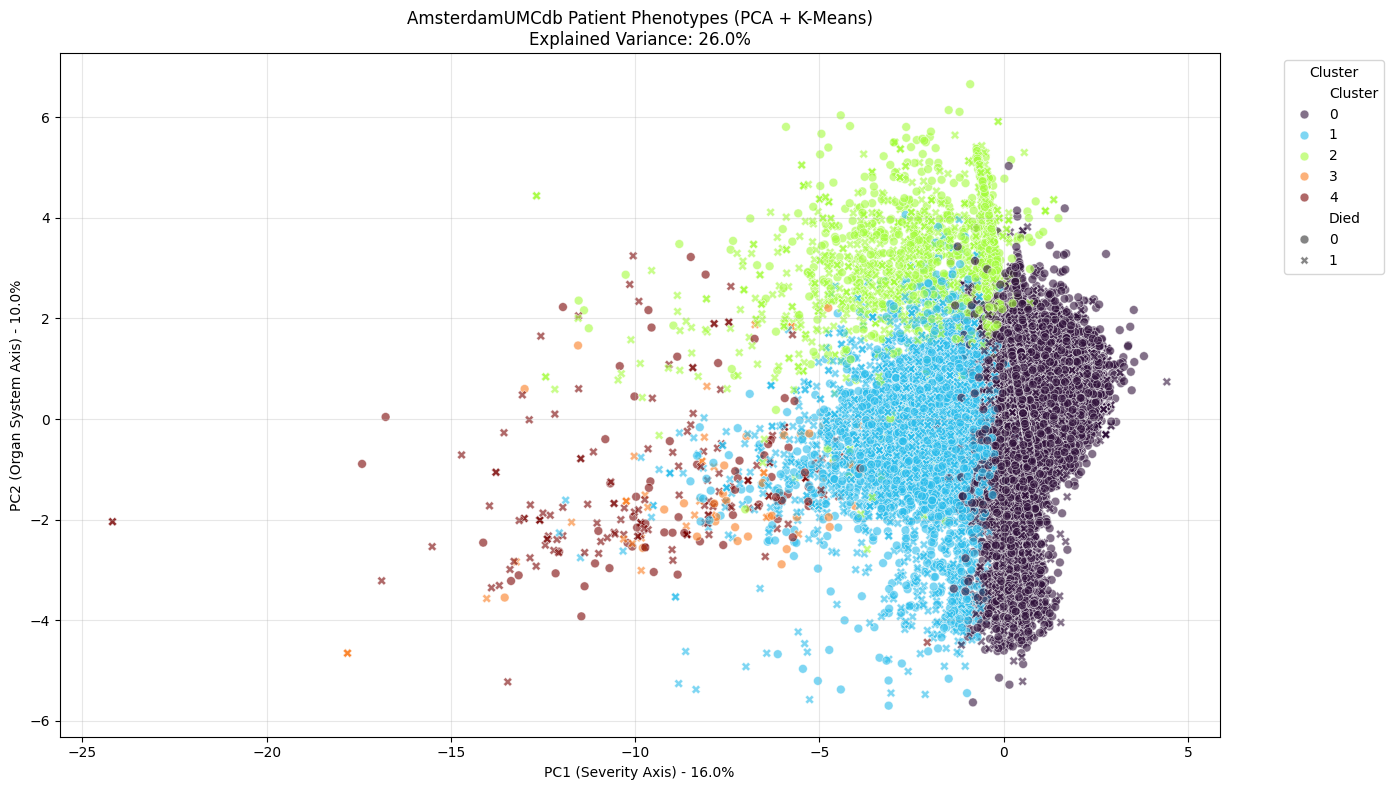


--- CLUSTER MORTALITY RATES (%) ---
Cluster
4    66.359447
2    50.431862
3         50.0
1    45.583817
0    18.924556
Name: Died, dtype: Float64

--- DETAILED CLUSTER PROFILES (Average Values) ---


In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# ==========================================
# 1. PREPARE THE FEATURES
# ==========================================
features = [
    'HR', 'MAP', 'Temp',
    'Lactate', 'pH', 'Creatinine', 'Glucose', 'PCT',
    'Final_FiO2', 'RRT_Flag', 'Min_GCS',
    'Norepi_Dose', 'Adrenaline_Dose', 'Vasopressin_Dose'
]

# Create X (Features) and y (Outcome)
X = df_clean[features].copy()
y = df_clean['Died']

# ==========================================
# 2. SAFETY NET: FINAL IMPUTATION
# ==========================================
# Even if we cleaned before, we run this to catch any edge cases
# Strategy: Median (Robust to outliers)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

# ==========================================
# 3. DROP "DEAD" COLUMNS (Zero Variance)
# ==========================================
# This prevents the "Divide by Zero" error in StandardScaler
std_devs = X_imputed.std()
dead_cols = std_devs[std_devs == 0].index
if len(dead_cols) > 0:
    print(f"WARNING: Dropping columns with zero variance: {list(dead_cols)}")
    X_imputed = X_imputed.drop(columns=dead_cols)

# ==========================================
# 4. STANDARDIZATION & PCA
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Create DataFrame for the Map
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df['Died'] = y.values

# ==========================================
# 5. K-MEANS CLUSTERING
# ==========================================
# We look for 5 distinct clinical phenotypes
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(X_scaled)

# ==========================================
# 6. VISUALIZATION
# ==========================================
plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    style='Died',
    palette='turbo',
    s=40,
    alpha=0.6
)

plt.title(f"AmsterdamUMCdb Patient Phenotypes (PCA + K-Means)\nExplained Variance: {sum(pca.explained_variance_ratio_):.1%}")
plt.xlabel(f"PC1 (Severity Axis) - {pca.explained_variance_ratio_[0]:.1%}")
plt.ylabel(f"PC2 (Organ System Axis) - {pca.explained_variance_ratio_[1]:.1%}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==========================================
# 7. INTERPRETATION (The Discovery)
# ==========================================
# Add cluster labels back to the CLEAN data (Real Units)
X_imputed['Cluster'] = pca_df['Cluster']
X_imputed['Died'] = y.values

# Calculate profiles
profile = X_imputed.groupby('Cluster').mean().T
mortality = X_imputed.groupby('Cluster')['Died'].mean() * 100

print("\n--- CLUSTER MORTALITY RATES (%) ---")
print(mortality.sort_values(ascending=False))

print("\n--- DETAILED CLUSTER PROFILES (Average Values) ---")
# Highlight the max value in each row to spot the phenotype definition
print(profile.style.highlight_max(axis=1, color='lightcoral').format("{:.2f}"))

In [60]:
print(profile)

Cluster                   0           1           2          3           4
HR                84.384035   87.954812   95.067738  91.660148   92.864459
MAP               78.621512   74.133554   76.370616   69.45053   67.783399
Temp              36.620844   36.587405   37.269493  36.742857   36.710585
Lactate            2.067792    3.083338    2.757011   5.771429    8.088018
pH                 7.332937    7.246989     7.25924   7.182714    7.124194
Creatinine         97.93776  151.412678  245.630998      175.8  190.092166
Glucose            8.024728    9.184318    8.126124  10.065928   10.219248
PCT                 0.56087     0.81333    0.666401       0.55        0.55
Final_FiO2        59.053431   78.570689   68.245729       90.4   87.304147
RRT_Flag                0.0      0.0001     0.99952   0.071429    0.179724
Min_GCS           11.049519    9.019627   10.666987  10.285714    7.907834
Norepi_Dose        0.590968    5.883018     2.35719   8.474894    9.202501
Adrenaline_Dose    0.0012

In [64]:
%%bigquery sepsis_gold_standard
WITH sepsis_flag AS (
    -- 1. The Direct "Sepsis at Admission" Checkbox
    -- FIX: Link Measurement to Visit using Person_ID and Time
    SELECT DISTINCT
        v.visit_occurrence_id,
        1 as sepsis_explicit_flag
    FROM `visit_occurrence` v
    JOIN `measurement` m ON v.person_id = m.person_id
    JOIN `concept` c ON m.measurement_concept_id = c.concept_id
    WHERE
        -- Time Filter: Measurement must be within first 24h of admission
        m.measurement_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)

        -- Concept Filter: Search for "Sepsis at admission"
        AND REGEXP_CONTAINS(LOWER(c.concept_name), r'sepsis.*admission|sepsis.*opname')

        -- Value Filter: Look for "Yes", "Ja", "1", "True" in the text value
        AND REGEXP_CONTAINS(LOWER(m.value_source_value), r'ja|yes|1|true')
),

sepsis_meds AS (
    -- 2. The Curated Antibiotic List (Broad Spectrum IV)
    -- FIX: Link Drug to Visit using Person_ID and Time
    SELECT DISTINCT
        v.visit_occurrence_id,
        1 as sepsis_meds_flag
    FROM `visit_occurrence` v
    JOIN `drug_exposure` d ON v.person_id = d.person_id
    JOIN `concept` c ON d.drug_concept_id = c.concept_id
    WHERE
        -- Time Filter: Drug given within first 24h
        d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)

        -- Drug Filter: Meropenem, Ceftriaxone, Pip/Tazo, Cipro, Vanco
        AND c.concept_id IN (1734104, 1713332, 1742425, 1310101, 1777042)
)

SELECT
    v.visit_occurrence_id,
    COALESCE(f.sepsis_explicit_flag, 0) as sepsis_explicit,
    COALESCE(m.sepsis_meds_flag, 0) as sepsis_meds,

    -- Final Definition
    CASE
        WHEN f.sepsis_explicit_flag = 1 THEN 'Explicit Sepsis'
        WHEN m.sepsis_meds_flag = 1 THEN 'Suspected Sepsis (Meds)'
        ELSE 'No Sepsis'
    END as sepsis_status,

    -- Outcome Check
    CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as died

FROM `visit_occurrence` v
LEFT JOIN sepsis_flag f ON v.visit_occurrence_id = f.visit_occurrence_id
LEFT JOIN sepsis_meds m ON v.visit_occurrence_id = m.visit_occurrence_id
LEFT JOIN `death` d ON v.person_id = d.person_id

Query is running:   0%|          |

Downloading:   0%|          |

In [65]:
sepsis_gold_standard

visit_occurrence_id  sepsis_explicit  sepsis_meds sepsis_status  died
0                    38018                0            0     No Sepsis     1
1                    26812                0            0     No Sepsis     0
2                    72441                0            0     No Sepsis     0
3                    70071                0            0     No Sepsis     0
4                    31479                0            0     No Sepsis     0
...                    ...              ...          ...           ...   ...
83388                30390                0            0     No Sepsis     0
83389                73541                0            0     No Sepsis     0
83390                66949                0            0     No Sepsis     0
83391                49409                0            0     No Sepsis     0
83392                32081                0            0     No Sepsis     0

[83393 rows x 5 columns]

--- Patient Counts by Sepsis Definition ---
sepsis_status
No Sepsis                  81199
Suspected Sepsis (Meds)     2194
Name: count, dtype: int64


/tmp/ipython-input-2958923700.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


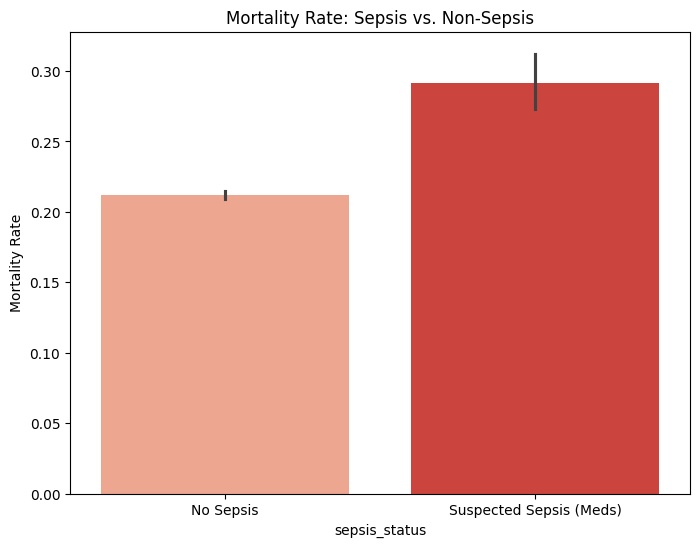

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check counts
print("--- Patient Counts by Sepsis Definition ---")
print(sepsis_gold_standard['sepsis_status'].value_counts())

# Plot Mortality
plt.figure(figsize=(8, 6))
sns.barplot(
    data=sepsis_gold_standard,
    x='sepsis_status',
    y='died',
    palette='Reds'
)
plt.title("Mortality Rate: Sepsis vs. Non-Sepsis")
plt.ylabel("Mortality Rate")
plt.show()

In [74]:
%%bigquery sepsis_concept_check
SELECT
    concept_id,
    concept_name,
    concept_code, -- This will look like '15808-1'
    domain_id,
    vocabulary_id
FROM `concept`
WHERE concept_code LIKE '15808-%' -- Search for the original itemid

Query is running:   0%|          |

Downloading:   0%|          |

In [75]:
sepsis_concept_check

concept_id                                       concept_name concept_code  \
0     3025040  Deprecated Latex glove extract ammoniated IgE ...      15808-9   

     domain_id vocabulary_id  
0  Measurement         LOINC

In [76]:
%%bigquery diagnosis_check
SELECT
    concept_id,
    concept_name,
    concept_code
FROM `concept`
WHERE concept_code LIKE '18669-%'
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [77]:
diagnosis_check

concept_id                                       concept_name concept_code
0     3013269  Deprecated Rehabilitation treatment plan, Leve...      18669-2

In [78]:
%%bigquery vocab_check
SELECT DISTINCT vocabulary_id, COUNT(*) as count
FROM `concept`
WHERE
    -- Search for Amsterdam-related vocabulary names
    REGEXP_CONTAINS(LOWER(vocabulary_id), r'amsterdam|aumc|local')
    -- OR search for concepts that look like our target itemid
    OR (concept_code LIKE '15808%' AND vocabulary_id != 'LOINC')
GROUP BY 1
ORDER BY 2 DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [79]:
vocab_check

vocabulary_id  count
0  AmsterdamUMCdb    233
1             OSM      2

In [80]:
%%bigquery amsterdam_concepts
SELECT
    concept_id,
    concept_name,
    concept_code,
    domain_id
FROM `concept`
WHERE vocabulary_id = 'AmsterdamUMCdb'
ORDER BY concept_name
LIMIT 50

Query is running:   0%|          |

Downloading:   0%|          |

In [81]:
amsterdam_concepts

concept_id                                       concept_name  \
0   2000000453  1,25-Dihydroxyvitamin D2 [moles/volume] in Ser...   
1   2000000577                                       Albumine 20%   
2   2000000582                                          Algedrate   
3   2000000002                                    Apache IV score   
4   2000000135                       Aspergillus resistance panel   
5   2000000408                   Atrial pacemaker - set amplitude   
6   2000000409                       Atrial pacemaker - set sense   
7   2000000186                             Backup apnea frequency   
8   2000000187                              Backup apnea interval   
9   2000000012                             Behavioural Pain Scale   
10  2000000449                          Blasts in Serum or Plasma   
11  2000000021                                    Blood flow CVVH   
12  2000000460                            Blood gas sampling site   
13  2000000023                                  Calcium flow CVVH   
14  2000000136                                      Calcium ratio   
15  2000000025                       Calcium suppletion dose CVVH   
16  2000000124                    Cardiac function index by PiCCO   
17  2000000157             Central venous catheter insertion time   
18  2000000516                       Central venous catheter type   
19  2000000486                             Chest tube air leakage   
20  2000000475                                 Chest tube suction   
21  2000000234                              Chest wall compliance   
22  2000000137      Chloride [Moles/volume] in Mixed venous blood   
23  2000000028                                Citrate dosage CVVH   
24  2000000132  Coagulation factor X activated inhibitor [Mass...   
25  2000000006                 Delirium observation screening day   
26  2000000009               Delirium observation screening total   
27  2000000036                               Dialysate flow CVVHD   
28  2000000038                               Duration of dialysis   
29  2000000101                                          ECMO FiO2   
30  2000000099                                 ECMO arterial flow   
31  2000000102                             ECMO pressure arterial   
32  2000000103                               ECMO pressure venous   
33  2000000104                             ECMO rounds per minute   
34  2000000105                                          ECMO type   
35  2000000100                                   ECMO venous flow   
36  2000000039                             Effluent pressure CVVH   
37  2000000573                                        Enema fluid   
38  2000000443                  Erythroblasts [#/volume] in blood   
39  2000000140   Erythrocytes [#/volume] in Blood by Manual count   
40  2000000495         External ventricular drain cm above Monroe   
41  2000000164  Extracorporeal membrane oxygenation line location   
42  2000000107             Extravascular lung water index - PICCO   
43  2000000446                           Feaces collection period   
44  2000000041                               Filter pressure CVVH   
45  2000000088                            Fluid out CVVH dialysis   
46  2000000089                 Fluid out CVVH dialysis cumulative   
47  2000000378                     Fluid output - gastric suction   
48  2000000092                           Fluid output after flush   
49  2000000090                     Fluid output drain unspecified   

   concept_code    domain_id  
0    2000000453  Measurement  
1    2000000577         Drug  
2    2000000582         Drug  
3    2000000002  Measurement  
4    2000000135  Measurement  
5    2000000408  Measurement  
6    2000000409  Measurement  
7    2000000186  Measurement  
8    2000000187  Measurement  
9    2000000012  Measurement  
10   2000000449  Measurement  
11   2000000021  Measurement  
12   2000000460  Measurement  
13   2000000023  Measurement  
14   2000000136  Me

In [86]:
%%bigquery master_matrix
WITH cohort AS (
    -- 1. Define the Study Population
    -- Patients who stayed at least 24 hours (to exclude routine post-op)
    SELECT
        visit_occurrence_id,
        person_id,
        visit_start_datetime
    FROM `visit_occurrence`
    WHERE TIMESTAMP_DIFF(visit_end_datetime, visit_start_datetime, HOUR) > 24
),

features AS (
    SELECT
        c.visit_occurrence_id,

        -- === 1. PHYSIOLOGY (Broad Search to fix missingness) ===
        -- HR: Combine EKG, PulseOx, etc.
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'heart rate') THEN m.value_as_number END) as HR,

        -- MAP: Combine Invasive (Arterial) and Non-Invasive (Cuff)
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'mean blood pressure|mean arterial pressure|non-invasive mean|nibp mean') THEN m.value_as_number END) as MAP,

        -- Temp: Combine all temperature sites
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'temperature') THEN m.value_as_number END) as Temp,

        -- === 2. LABS (Specific IDs + Name Search for safety) ===
        -- Lactate: Arterial (3018405) + Blood (3047181) + Venous (3008037)
        MAX(CASE WHEN m.measurement_concept_id IN (3018405, 3047181, 3008037) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'lactate') THEN m.value_as_number END) as Lactate,

        -- pH: Arterial pH
        MIN(CASE WHEN m.measurement_concept_id = 3024561 OR REGEXP_CONTAINS(LOWER(con.concept_name), r'ph ') THEN m.value_as_number END) as pH,

        -- Creatinine: Serum/Plasma
        MAX(CASE WHEN m.measurement_concept_id IN (3020564, 3009508) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'creatinine') THEN m.value_as_number END) as Creatinine,

        -- Glucose: All sources
        AVG(CASE WHEN m.measurement_concept_id IN (3020491, 3044242, 3040151) OR REGEXP_CONTAINS(LOWER(con.concept_name), r'glucose') THEN m.value_as_number END) as Glucose,

        -- Procalcitonin (PCT): Specific ID found earlier
        MAX(CASE WHEN m.measurement_concept_id = 3046279 THEN m.value_as_number END) as PCT,

        -- === 3. RESPIRATORY SUPPORT (For Python Calculation) ===
        -- Recorded FiO2 % (Ventilator setting)
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 OR REGEXP_CONTAINS(LOWER(con.concept_name), r'fio2') THEN m.value_as_number END) as Recorded_FiO2,

        -- O2 Flow (Liters/min) - ID 3005629
        MAX(CASE WHEN m.measurement_concept_id = 3005629 THEN m.value_as_number END) as O2_Flow,

        -- PEEP (To detect if patient is on Ventilator)
        MAX(CASE WHEN m.measurement_concept_id = 3022875 THEN m.value_as_number END) as PEEP,

        -- === 4. OTHER INTERVENTIONS & SCORES ===
        -- RRT Flag (CVVH Blood Flow > 0)
        MAX(CASE WHEN m.measurement_concept_id = 2000000021 THEN 1 ELSE 0 END) as RRT_Flag,

        -- GCS Total (Neurological Status)
        MIN(CASE WHEN m.measurement_concept_id = 3007194 THEN m.value_as_number END) as Min_GCS,

        -- APACHE IV Score (Severity at Admission)
        MAX(CASE WHEN m.measurement_concept_id = 2000000002 THEN m.value_as_number END) as Apache_IV

    FROM cohort c
    JOIN `measurement` m ON c.person_id = m.person_id
    JOIN `concept` con ON m.measurement_concept_id = con.concept_id
    WHERE
        -- Filter for the First 24 Hours of the admission
        m.measurement_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

drugs AS (
    SELECT
        c.visit_occurrence_id,

        -- Norepinephrine (Septic Shock) - ID 1321341
        SUM(CASE WHEN d.drug_concept_id = 1321341 THEN d.quantity ELSE 0 END) as Norepi_Dose,

        -- Adrenaline/Epinephrine (Cardiac Arrest) - ID 1343916
        SUM(CASE WHEN d.drug_concept_id = 1343916 THEN d.quantity ELSE 0 END) as Adrenaline_Dose,

        -- Vasopressin (Refractory Shock) - Name Search
        SUM(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'vasopressin|argipressin') THEN d.quantity ELSE 0 END) as Vasopressin_Dose

    FROM cohort c
    JOIN `drug_exposure` d ON c.person_id = d.person_id
    JOIN `concept` con ON d.drug_concept_id = con.concept_id
    WHERE
        -- Filter for First 24 Hours
        d.drug_exposure_start_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY c.visit_occurrence_id
),

outcomes AS (
    SELECT
        v.visit_occurrence_id,
        -- Mortality Flag
        CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as Died
    FROM `visit_occurrence` v
    LEFT JOIN `death` d ON v.person_id = d.person_id
)

-- === FINAL JOIN ===
SELECT
    f.*,
    COALESCE(dr.Norepi_Dose, 0) as Norepi_Dose,
    COALESCE(dr.Adrenaline_Dose, 0) as Adrenaline_Dose,
    COALESCE(dr.Vasopressin_Dose, 0) as Vasopressin_Dose,
    o.Died
FROM features f
LEFT JOIN drugs dr ON f.visit_occurrence_id = dr.visit_occurrence_id
LEFT JOIN outcomes o ON f.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [90]:
%%bigquery bounceback_analysis
-- =========================================================================
-- CTE 1: Create an Hourly Grid of Patient States
-- =========================================================================
WITH hourly_states AS (
    SELECT
        v.person_id,
        v.visit_occurrence_id,
        TIMESTAMP_TRUNC(d.drug_exposure_start_datetime, HOUR) as chart_time,
        -- State: On Vasopressors? (Norepinephrine > 0)
        MAX(CASE WHEN d.drug_concept_id = 1321341 AND d.quantity > 0 THEN 1 ELSE 0 END) as is_on_vaso
    FROM `visit_occurrence` v
    JOIN `drug_exposure` d ON v.person_id = d.person_id
    WHERE
        TIMESTAMP_DIFF(v.visit_end_datetime, v.visit_start_datetime, HOUR) > 48
        AND d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND v.visit_end_datetime
    GROUP BY 1, 2, 3
),

-- =========================================================================
-- CTE 2: Identify State Transitions (Weaning and Restarting)
-- =========================================================================
state_transitions AS (
    SELECT
        visit_occurrence_id,
        chart_time,
        is_on_vaso,
        -- Get the state of the previous hour
        LAG(is_on_vaso, 1, 0) OVER (PARTITION BY visit_occurrence_id ORDER BY chart_time) as prev_hour_on_vaso
    FROM hourly_states
),

-- =========================================================================
-- CTE 3: Find the "Bounceback" Events
-- =========================================================================
bounceback_events AS (
    SELECT
        wean.visit_occurrence_id,
        wean.chart_time as wean_time
    FROM state_transitions wean
    JOIN state_transitions restart
        ON wean.visit_occurrence_id = restart.visit_occurrence_id
    WHERE
        -- Find a "Wean Event" (was ON, now is OFF)
        wean.prev_hour_on_vaso = 1 AND wean.is_on_vaso = 0
        -- Find a "Restart Event" (was OFF, now is ON)
        AND restart.prev_hour_on_vaso = 0 AND restart.is_on_vaso = 1
        -- Ensure the restart happened AFTER the wean and within 12 hours
        AND restart.chart_time > wean.chart_time
        AND TIMESTAMP_DIFF(restart.chart_time, wean.chart_time, HOUR) <= 12
    GROUP BY 1, 2 -- Group to get one event per wean
),

-- =========================================================================
-- CTE 4: Re-create the Baseline Features from `master_matrix`
-- This block calculates the first-24h summary for all patients
-- =========================================================================
baseline_features AS (
    SELECT
        c.visit_occurrence_id,
        -- We only need the key features for our hypothesis (Creatinine, PCT, APACHE)
        MAX(CASE WHEN m.measurement_concept_id = 3020564 THEN m.value_as_number END) as admission_creatinine,
        MAX(CASE WHEN m.measurement_concept_id = 3046279 THEN m.value_as_number END) as admission_pct,
        MAX(CASE WHEN m.measurement_concept_id = 2000000002 THEN m.value_as_number END) as admission_apache,
        MAX(CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END) as Died
    FROM `visit_occurrence` c
    LEFT JOIN `measurement` m ON c.person_id = m.person_id AND m.measurement_datetime BETWEEN c.visit_start_datetime AND TIMESTAMP_ADD(c.visit_start_datetime, INTERVAL 24 HOUR)
    LEFT JOIN `death` d ON c.person_id = d.person_id
    GROUP BY c.visit_occurrence_id
)

-- =========================================================================
-- Final Analysis: Join Baseline features with the Bounceback flag
-- =========================================================================
SELECT
    b.visit_occurrence_id,
    b.Died,
    b.admission_creatinine,
    b.admission_pct,
    b.admission_apache,
    -- The Target Variable: Did this patient have a bounceback event?
    MAX(CASE WHEN bb.visit_occurrence_id IS NOT NULL THEN 1 ELSE 0 END) as had_bounceback
FROM baseline_features b
LEFT JOIN bounceback_events bb ON b.visit_occurrence_id = bb.visit_occurrence_id
GROUP BY 1, 2, 3, 4, 5

Query is running:   0%|          |

Downloading:   0%|          |

In [91]:
bounceback_analysis

visit_occurrence_id  Died  admission_creatinine  admission_pct  \
0                    72934     0             56.000000            NaN   
1                    58521     0                   NaN            NaN   
2                    44621     0                   NaN            NaN   
3                    10425     0             59.999999            NaN   
4                    49008     0             74.000000            NaN   
...                    ...   ...                   ...            ...   
79833                58959     0             91.000000            NaN   
79834                75710     0                   NaN            NaN   
79835                19448     0                   NaN            NaN   
79836                16991     0                   NaN            NaN   
79837                57592     0             49.999999            NaN   

       admission_apache  had_bounceback  
0                   NaN               1  
1                   NaN               0  
2                   NaN               0  
3                   NaN               0  
4                   NaN               0  
...                 ...             ...  
79833               NaN               0  
79834               NaN               0  
79835               NaN               0  
79836               NaN               0  
79837               NaN               0  

[79838 rows x 6 columns]

had_bounceback
0    67793
1    12045
Name: count, dtype: Int64

--- Mortality Rate ---
had_bounceback
0    14.715384
1    35.757576
Name: Died, dtype: Float64


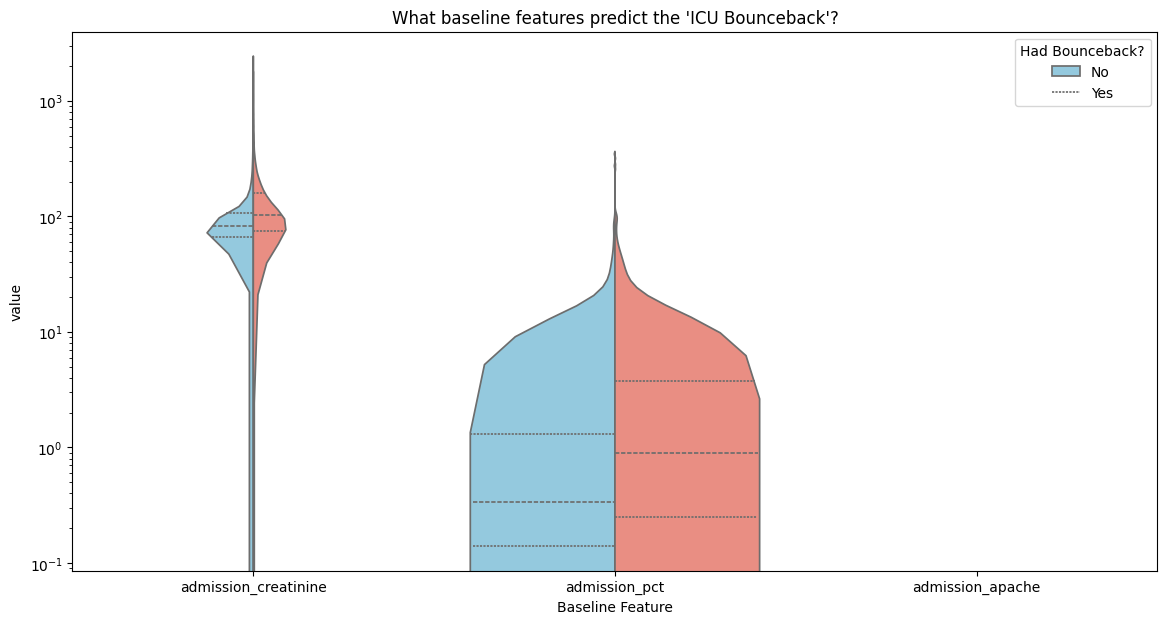

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. How many patients had a bounceback?
print(bounceback_analysis['had_bounceback'].value_counts())

# 2. Does it predict death?
print("\n--- Mortality Rate ---")
print(bounceback_analysis.groupby('had_bounceback')['Died'].mean() * 100)

# 3. What are the baseline differences? (The "Unexpected Pattern")
# Melt the data for easy plotting
melted_df = bounceback_analysis.melt(
    id_vars=['had_bounceback', 'Died'],
    value_vars=['admission_creatinine', 'admission_pct', 'admission_apache'],
    var_name='Baseline Feature'
)

# Violin plots to show the full distribution
plt.figure(figsize=(14, 7))
sns.violinplot(
    data=melted_df,
    x='Baseline Feature',
    y='value',
    hue='had_bounceback',
    split=True,
    inner='quartile',
    palette={0: 'skyblue', 1: 'salmon'} # 0=No Bounce, 1=Bounceback
)
plt.title("What baseline features predict the 'ICU Bounceback'?")
plt.yscale('log') # Use log scale for skewed data like Creatinine/PCT
plt.legend(title='Had Bounceback?', labels=['No', 'Yes'])
plt.show()

In [95]:
print(bounceback_analysis)

       visit_occurrence_id  Died  admission_creatinine  admission_pct  \
0                    72934     0             56.000000            NaN   
1                    58521     0                   NaN            NaN   
2                    44621     0                   NaN            NaN   
3                    10425     0             59.999999            NaN   
4                    49008     0             74.000000            NaN   
...                    ...   ...                   ...            ...   
79833                58959     0             91.000000            NaN   
79834                75710     0                   NaN            NaN   
79835                19448     0                   NaN            NaN   
79836                16991     0                   NaN            NaN   
79837                57592     0             49.999999            NaN   

       admission_apache  had_bounceback  
0                   NaN               1  
1                   NaN               0

In [96]:
%%bigquery bounceback_ids
WITH hourly_states AS (
    SELECT
        v.visit_occurrence_id,
        TIMESTAMP_TRUNC(d.drug_exposure_start_datetime, HOUR) as chart_time,
        MAX(CASE WHEN d.drug_concept_id = 1321341 AND d.quantity > 0 THEN 1 ELSE 0 END) as is_on_vaso
    FROM `visit_occurrence` v
    JOIN `drug_exposure` d ON v.person_id = d.person_id
    WHERE
        TIMESTAMP_DIFF(v.visit_end_datetime, v.visit_start_datetime, HOUR) > 48
        AND d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND v.visit_end_datetime
    GROUP BY 1, 2
),

state_transitions AS (
    SELECT
        visit_occurrence_id,
        chart_time,
        is_on_vaso,
        LAG(is_on_vaso, 1, 0) OVER (PARTITION BY visit_occurrence_id ORDER BY chart_time) as prev_hour_on_vaso
    FROM hourly_states
)

SELECT DISTINCT
    wean.visit_occurrence_id
FROM state_transitions wean
JOIN state_transitions restart
    ON wean.visit_occurrence_id = restart.visit_occurrence_id
WHERE
    wean.prev_hour_on_vaso = 1 AND wean.is_on_vaso = 0
    AND restart.prev_hour_on_vaso = 0 AND restart.is_on_vaso = 1
    AND restart.chart_time > wean.chart_time
    AND TIMESTAMP_DIFF(restart.chart_time, wean.chart_time, HOUR) <= 12

Query is running:   0%|          |

Downloading:   0%|          |

--- Bounceback Cohort Size ---
had_bounceback
0    36055
1    13217
Name: count, dtype: int64

--- Mortality Rate by Group ---
had_bounceback
0    20.205242
1    41.484452
Name: Died, dtype: Float64


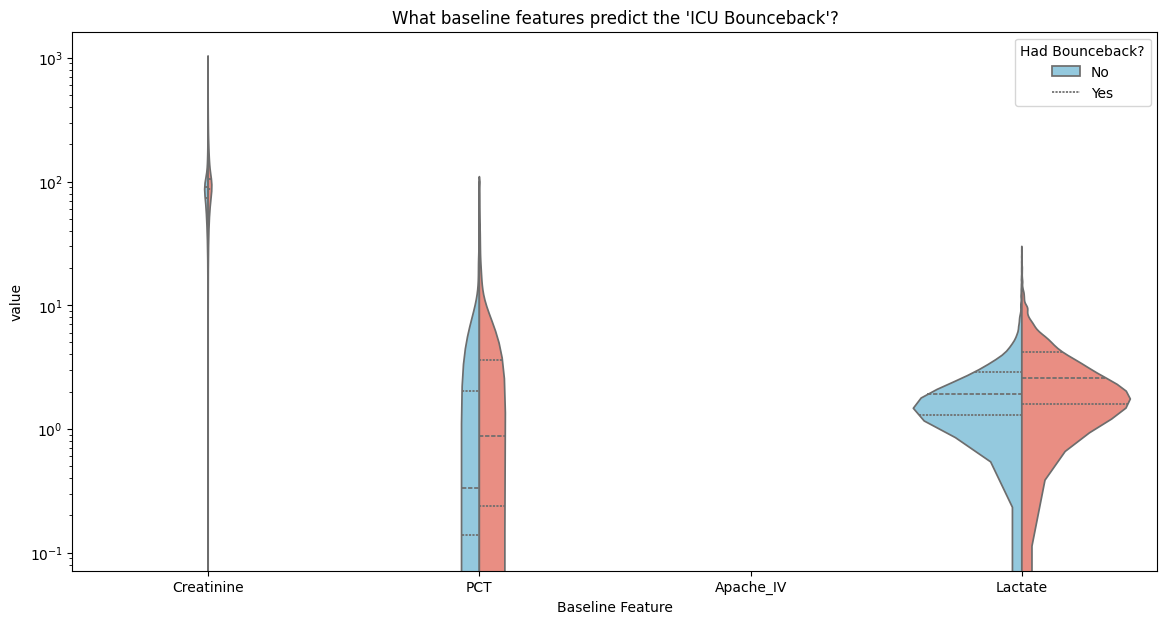

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create the 'had_bounceback' column in our clean dataframe
# First, create a set of the bounceback IDs for fast lookup
bounceback_set = set(bounceback_ids['visit_occurrence_id'])

# Now, create the flag in our main clean dataframe
# (Assuming your clean dataframe is named 'df_clean' from the outlier step)
df_clean['had_bounceback'] = df_clean['visit_occurrence_id'].isin(bounceback_set).astype(int)

# 2. Analyze the results
print("--- Bounceback Cohort Size ---")
print(df_clean['had_bounceback'].value_counts())

print("\n--- Mortality Rate by Group ---")
print(df_clean.groupby('had_bounceback')['Died'].mean() * 100)

# 3. Visualize the "Unexpected Pattern"
# We use the clean, imputed features from df_clean
features_to_compare = ['Creatinine', 'PCT', 'Apache_IV', 'Lactate']
melted_df = df_clean.melt(
    id_vars=['had_bounceback'],
    value_vars=features_to_compare,
    var_name='Baseline Feature'
)

plt.figure(figsize=(14, 7))
sns.violinplot(
    data=melted_df,
    x='Baseline Feature',
    y='value',
    hue='had_bounceback',
    split=True,
    inner='quartile',
    palette={0: 'skyblue', 1: 'salmon'} # 0=No Bounce, 1=Bounceback
)
plt.title("What baseline features predict the 'ICU Bounceback'?")
plt.yscale('log') # Use log scale for skewed data
plt.legend(title='Had Bounceback?', labels=['No', 'Yes'])
plt.show()

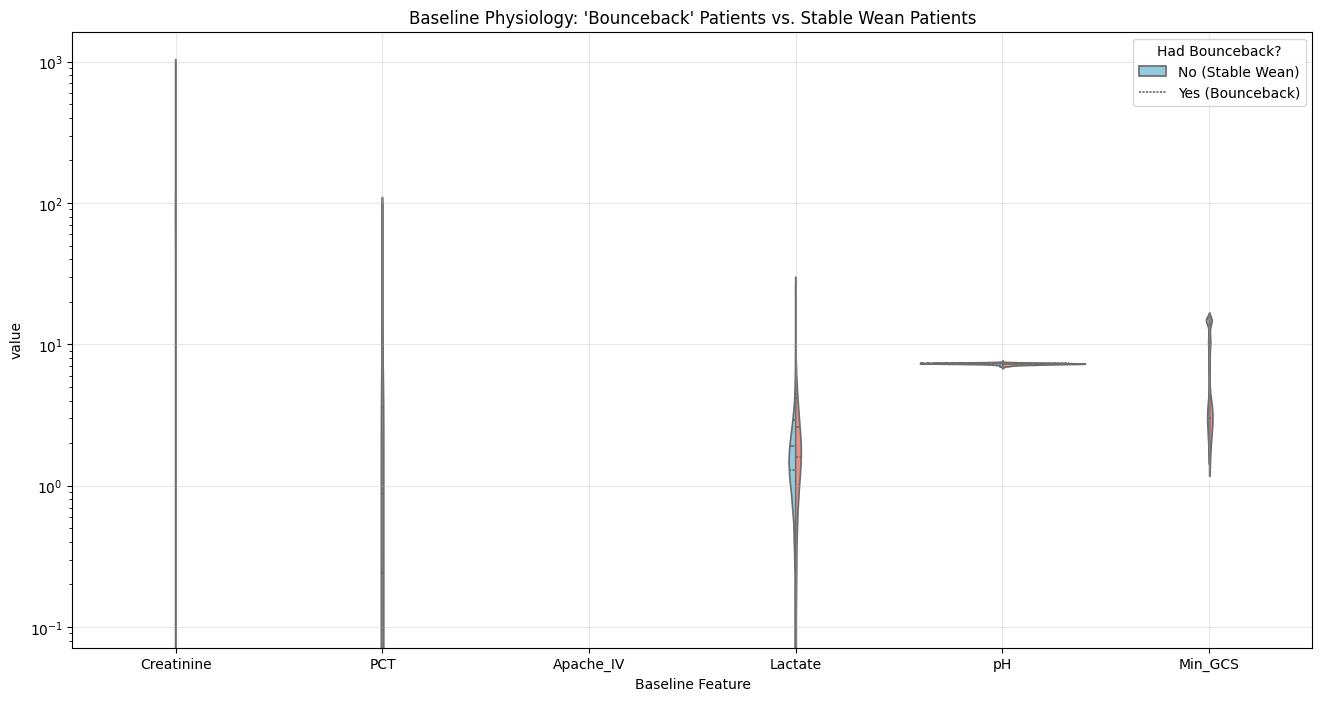

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# (Assuming 'df_clean' is your fully cleaned and imputed dataframe from previous steps,
# and you have already run the code to add the 'had_bounceback' column)

# 1. Select the key features to compare at baseline
features_to_compare = ['Creatinine', 'PCT', 'Apache_IV', 'Lactate', 'pH', 'Min_GCS']

# 2. Melt the dataframe for easy plotting with Seaborn
melted_df = df_clean.melt(
    id_vars=['had_bounceback'],
    value_vars=features_to_compare,
    var_name='Baseline Feature'
)

# 3. Create Violin Plots to show the full distribution
plt.figure(figsize=(16, 8))
sns.violinplot(
    data=melted_df,
    x='Baseline Feature',
    y='value',
    hue='had_bounceback',
    split=True,
    inner='quartile',
    palette={0: 'skyblue', 1: 'salmon'} # 0=Stable Wean, 1=Bounceback
)

plt.title("Baseline Physiology: 'Bounceback' Patients vs. Stable Wean Patients")
plt.yscale('log') # Use log scale for skewed data like Creatinine/PCT
plt.legend(title='Had Bounceback?', labels=['No (Stable Wean)', 'Yes (Bounceback)'])
plt.grid(True, alpha=0.3)
plt.show()

In [99]:
%%bigquery action_df
WITH hourly_grid AS (
    -- Create a grid of Patient + Hour
    SELECT
        v.person_id,
        v.visit_occurrence_id,
        TIMESTAMP_TRUNC(m.measurement_datetime, HOUR) as chart_time
    FROM `visit_occurrence` v
    JOIN `measurement` m ON v.person_id = m.person_id
    WHERE m.measurement_datetime BETWEEN v.visit_start_datetime AND v.visit_end_datetime
    GROUP BY 1, 2, 3
),

vitals AS (
    SELECT
        person_id,
        TIMESTAMP_TRUNC(measurement_datetime, HOUR) as chart_time,
        AVG(CASE WHEN measurement_concept_id = 21490852 THEN value_as_number END) as MAP,
        AVG(CASE WHEN measurement_concept_id = 3001376 THEN value_as_number END) as HR,
        AVG(CASE WHEN measurement_concept_id = 3037253 THEN value_as_number END) as Fluid_Volume
    FROM `measurement`
    WHERE measurement_concept_id IN (21490852, 3001376, 3037253)
    GROUP BY 1, 2
),

vaso AS (
    SELECT
        person_id,
        TIMESTAMP_TRUNC(drug_exposure_start_datetime, HOUR) as chart_time,
        SUM(quantity) as Norepi_Dose
    FROM `drug_exposure`
    WHERE drug_concept_id = 1321341 -- Norepinephrine
    GROUP BY 1, 2
)

SELECT
    g.visit_occurrence_id,
    g.chart_time,

    -- STATE (Current Vitals)
    COALESCE(v.MAP, 0) as map_current,
    COALESCE(v.HR, 0) as hr_current,
    COALESCE(dr.Norepi_Dose, 0) as norepi_current,

    -- ACTIONS (Interventions in this hour)
    -- Action 1: Fluid Bolus (>250ml is a typical bolus)
    CASE WHEN v.Fluid_Volume > 250 THEN 1 ELSE 0 END as action_fluid,

    -- Action 2: Vasopressor Increase (Did dose go up compared to prev hour?)
    -- (We calculate the delta in Python next step)

    -- OUTCOME (Target)
    -- We will shift this in Python to get Next_Hour_MAP

FROM hourly_grid g
LEFT JOIN vitals v ON g.person_id = v.person_id AND g.chart_time = v.chart_time
LEFT JOIN vaso dr ON g.person_id = dr.person_id AND g.chart_time = dr.chart_time
WHERE v.MAP IS NOT NULL -- We need at least a BP to model
ORDER BY g.visit_occurrence_id, g.chart_time

Query is running:   0%|          |

Downloading:   0%|          |

In [101]:
action_df

visit_occurrence_id                chart_time  map_current  \
0                          0 2010-01-01 00:00:00+00:00    56.000003   
1                          0 2010-01-01 01:00:00+00:00    56.000003   
2                          0 2010-01-01 02:00:00+00:00    64.999999   
3                          0 2010-01-01 03:00:00+00:00    80.999986   
4                          0 2010-01-01 04:00:00+00:00   108.000031   
...                      ...                       ...          ...   
4315620                79836 2010-02-02 05:00:00+00:00   105.000004   
4315621                79836 2010-02-02 07:00:00+00:00    88.000010   
4315622                79836 2010-02-02 09:00:00+00:00    92.999999   
4315623                79836 2010-02-02 11:00:00+00:00    73.000000   
4315624                79836 2010-02-02 13:00:00+00:00   105.999988   

         hr_current  norepi_current  action_fluid  
0               0.0             0.0             0  
1               0.0             0.0             0  
2               0.0             0.0             0  
3               0.0             0.0             0  
4               0.0             0.0             0  
...             ...             ...           ...  
4315620         0.0             0.0             0  
4315621         0.0             0.0             0  
4315622         0.0             0.0             0  
4315623         0.0             0.0             0  
4315624         0.0             0.0             0  

[4315625 rows x 6 columns]

In [103]:
%%bigquery action_matrix
WITH valid_admissions AS (
    -- 1. THE GHOST FILTER: Find admissions with sufficient data density
    SELECT
        v.visit_occurrence_id
    FROM `visit_occurrence` v
    JOIN `measurement` m ON v.person_id = m.person_id
    -- *** FIX: JOIN to the concept table to access concept_name ***
    JOIN `concept` c ON m.measurement_concept_id = c.concept_id
    WHERE
        -- Check for core hemodynamic measurements (HR or MAP)
        REGEXP_CONTAINS(LOWER(c.concept_name), r'heart rate|mean blood pressure')
        AND m.measurement_datetime BETWEEN v.visit_start_datetime AND v.visit_end_datetime
    GROUP BY
        v.visit_occurrence_id
    HAVING
        -- Require at least 10 core measurements to be considered a "real" patient
        COUNT(m.value_as_number) >= 10
),

hourly_grid AS (
    -- 2. Create the hourly grid ONLY for valid patients
    SELECT
        a.person_id,
        a.visit_occurrence_id,
        t as chart_time
    FROM `visit_occurrence` a
    JOIN valid_admissions va ON a.visit_occurrence_id = va.visit_occurrence_id
    ,
    UNNEST(GENERATE_TIMESTAMP_ARRAY(a.visit_start_datetime, a.visit_end_datetime, INTERVAL 1 HOUR)) as t
    WHERE TIMESTAMP_DIFF(a.visit_end_datetime, a.visit_start_datetime, HOUR) > 24
),

hourly_vitals AS (
    -- 3. Aggregate vitals and labs by hour
    SELECT
        person_id,
        TIMESTAMP_TRUNC(measurement_datetime, HOUR) as chart_time,
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'heart rate') THEN m.value_as_number END) as HR,
        AVG(CASE WHEN REGEXP_CONTAINS(LOWER(con.concept_name), r'mean blood pressure') THEN m.value_as_number END) as MAP,
        AVG(CASE WHEN m.measurement_concept_id = 3018405 THEN m.value_as_number END) as Lactate,
        SUM(CASE WHEN m.measurement_concept_id = 3037253 THEN m.value_as_number END) as Fluid_In
    FROM `measurement` m
    JOIN `concept` con ON m.measurement_concept_id = con.concept_id
    GROUP BY 1, 2
),

hourly_vaso AS (
    -- 4. Aggregate vasopressor dose by hour
    SELECT
        person_id,
        TIMESTAMP_TRUNC(drug_exposure_start_datetime, HOUR) as chart_time,
        SUM(CASE WHEN drug_concept_id = 1321341 THEN quantity ELSE 0 END) as Norepi_Dose
    FROM `drug_exposure`
    WHERE drug_concept_id = 1321341
    GROUP BY 1, 2
)

-- 5. Final Join
SELECT
    g.visit_occurrence_id,
    g.chart_time,
    v.HR,
    v.MAP,
    v.Lactate,
    COALESCE(vs.Norepi_Dose, 0) as Norepi_Dose,
    CASE WHEN v.Fluid_In > 250 THEN 1 ELSE 0 END as Action_Fluid_Bolus
FROM hourly_grid g
LEFT JOIN hourly_vitals v ON g.person_id = v.person_id AND g.chart_time = v.chart_time
LEFT JOIN hourly_vaso vs ON g.person_id = vs.person_id AND g.chart_time = vs.chart_time
ORDER BY g.visit_occurrence_id, g.chart_time

Query is running:   0%|          |

Downloading:   0%|          |

In [105]:
# --- 1. Configuration (Your variables from the top of the notebook) ---
DATASET_PROJECT_ID = 'amsterdamumcdb'
DATASET_ID = 'van_gogh_2026_datathon'

# --- 2. The Corrected Query ---
# We use an f-string to build the full path to the table
total_admissions_query = f"""
    SELECT COUNT(DISTINCT visit_occurrence_id)
    FROM `{DATASET_PROJECT_ID}.{DATASET_ID}.visit_occurrence`
"""

# --- 3. Execute the Query ---
# Assuming 'client' is your BigQuery client object
total_admissions = client.query(total_admissions_query).to_dataframe().iloc[0,0]

# Get the number of unique admissions in your new, clean dataframe
# (Assuming your dataframe from the previous SQL cell is named 'action_matrix')
clean_admissions = action_matrix['visit_occurrence_id'].nunique()

# Calculate the number of ghosts removed
ghosts_removed = total_admissions - clean_admissions

print(f"Original total admissions: {total_admissions}")
print(f"Admissions after cleaning (data density filter): {clean_admissions}")
print(f"Number of 'ghost' or sparse patients removed: {ghosts_removed}")

Original total admissions: 79838
Admissions after cleaning (data density filter): 46713
Number of 'ghost' or sparse patients removed: 33125


Hemodynamic Co-Pilot model trained and ready.

--- Patient State ---
Current MAP: 63.0 mmHg

--- Expected Response Trajectories ---
                  Action  Predicted_MAP
0         Watch and Wait      68.449402
1       Give Fluid Bolus      68.324203
2  Increase Vasopressors      68.449402


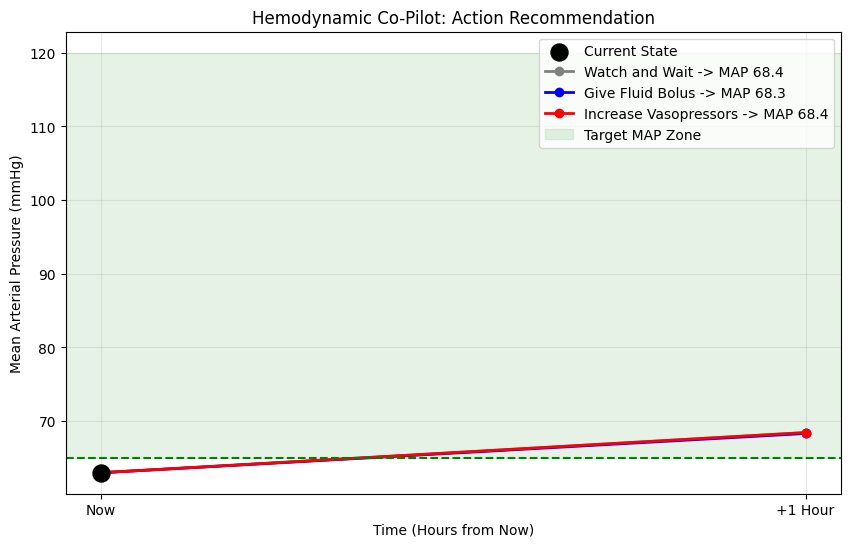


RECOMMENDATION: The optimal action to raise MAP is 'Watch and Wait'.


In [106]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Preprocessing & Feature Engineering
df = action_matrix.copy()

# Forward-fill vitals to handle missingness between measurements
df[['HR', 'MAP', 'Lactate']] = df.groupby('visit_occurrence_id')[['HR', 'MAP', 'Lactate']].ffill(limit=4)
df = df.dropna(subset=['MAP']) # We need a MAP to predict from

# Create Action 2: Vasopressor Increase
df['Norepi_Prev_Hour'] = df.groupby('visit_occurrence_id')['Norepi_Dose'].shift(1).fillna(0)
df['Action_Vaso_Up'] = (df['Norepi_Dose'] > df['Norepi_Prev_Hour']).astype(int)

# Create the Target: MAP one hour from now
df['MAP_Next_Hour'] = df.groupby('visit_occurrence_id')['MAP'].shift(-1)

# Final cleanup
df = df.dropna(subset=['MAP_Next_Hour'])

# 2. Train the "Simulator" Model
features = ['HR', 'MAP', 'Lactate', 'Norepi_Dose', 'Action_Fluid_Bolus', 'Action_Vaso_Up']
target = 'MAP_Next_Hour'

model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    objective='reg:squarederror'
)
model.fit(df[features], df[target])

print("Hemodynamic Co-Pilot model trained and ready.")

# 3. Run the Recommendation Engine
def recommend_action(patient_state):
    scenarios = pd.DataFrame([patient_state] * 3)
    scenarios.loc[0, 'Action_Fluid_Bolus'], scenarios.loc[0, 'Action_Vaso_Up'] = 0, 0
    scenarios.loc[1, 'Action_Fluid_Bolus'], scenarios.loc[1, 'Action_Vaso_Up'] = 1, 0
    scenarios.loc[2, 'Action_Fluid_Bolus'], scenarios.loc[2, 'Action_Vaso_Up'] = 0, 1
    predicted_maps = model.predict(scenarios[features])
    return predicted_maps

# Find a hypotensive patient to test
hypotensive_patient_state = df[df['MAP'] < 65].iloc[10][features].to_dict()
del hypotensive_patient_state['Action_Fluid_Bolus'], hypotensive_patient_state['Action_Vaso_Up']

print("\n--- Patient State ---")
print(f"Current MAP: {hypotensive_patient_state['MAP']:.1f} mmHg")

# Get Recommendation
predictions = recommend_action(hypotensive_patient_state)
actions = ["Watch and Wait", "Give Fluid Bolus", "Increase Vasopressors"]
results = pd.DataFrame({'Action': actions, 'Predicted_MAP': predictions})

print("\n--- Expected Response Trajectories ---")
print(results)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(0, hypotensive_patient_state['MAP'], color='black', s=150, zorder=5, label='Current State')
colors = {'Watch and Wait': 'gray', 'Give Fluid Bolus': 'blue', 'Increase Vasopressors': 'red'}
for i, row in results.iterrows():
    plt.plot([0, 1], [hypotensive_patient_state['MAP'], row['Predicted_MAP']],
             marker='o', color=colors[row['Action']], linewidth=2, label=f"{row['Action']} -> MAP {row['Predicted_MAP']:.1f}")
plt.axhspan(65, 120, color='green', alpha=0.1, label='Target MAP Zone')
plt.axhline(65, color='green', linestyle='--')
plt.title("Hemodynamic Co-Pilot: Action Recommendation")
plt.ylabel("Mean Arterial Pressure (mmHg)")
plt.xlabel("Time (Hours from Now)")
plt.xticks([0, 1], ['Now', '+1 Hour'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_action = results.loc[results['Predicted_MAP'].idxmax()]
print(f"\nRECOMMENDATION: The optimal action to raise MAP is '{best_action['Action']}'.")

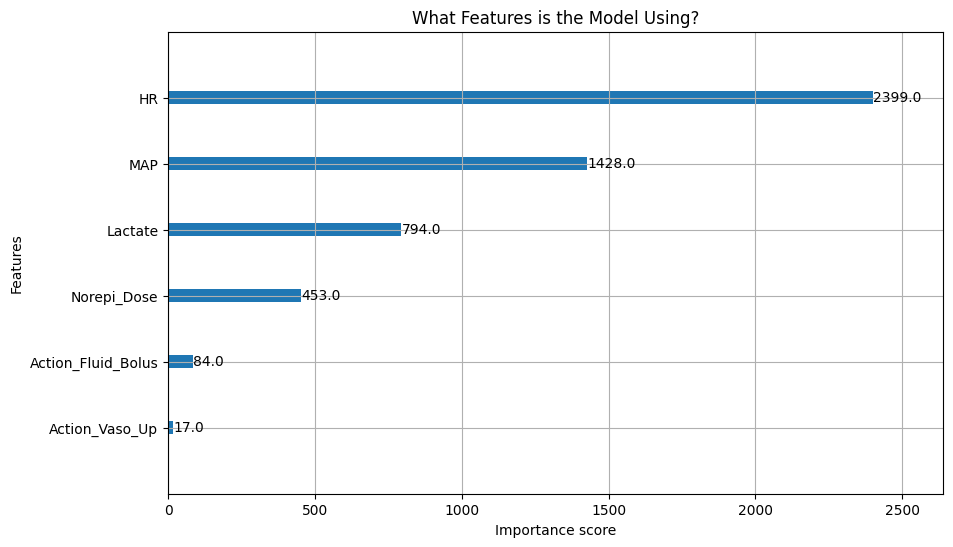

In [107]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot the feature importance from the model you just trained
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax)
plt.title("What Features is the Model Using?")
plt.show()

Training a specialist model on 485949 hypotensive time points.
Hypotension Specialist model trained.

--- Patient State ---
Current MAP: 63.0 mmHg

--- SPECIALIST Model: Expected Response Trajectories ---
                  Action  Predicted_MAP
0         Watch and Wait      68.358795
1       Give Fluid Bolus      68.227112
2  Increase Vasopressors      69.369339


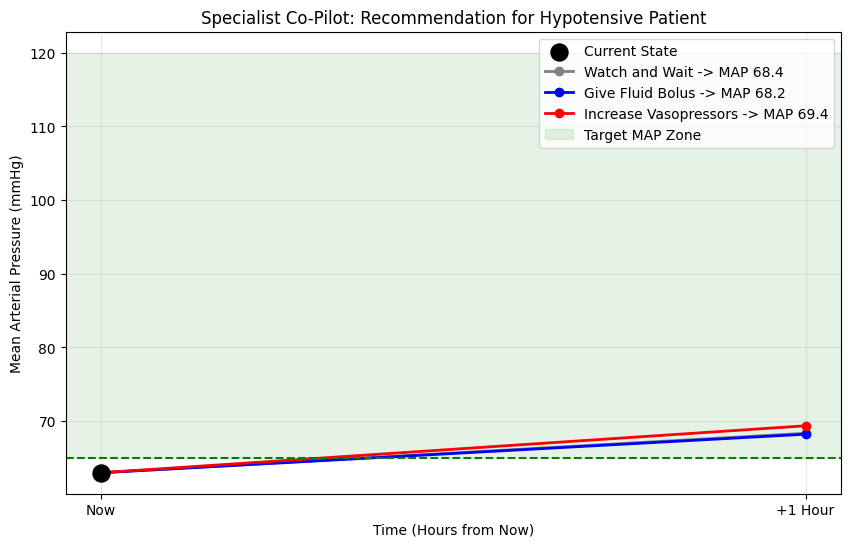


RECOMMENDATION: The optimal action to raise MAP is 'Increase Vasopressors'.


In [108]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# (Assuming 'df' is your preprocessed dataframe from the previous step)

# =================================================================
# 1. CREATE THE SPECIALIST DATASET
# =================================================================
# We only train the model on moments when the patient was hypotensive
hypotensive_df = df[df['MAP'] < 65].copy()
print(f"Training a specialist model on {len(hypotensive_df)} hypotensive time points.")

# =================================================================
# 2. TRAIN THE SPECIALIST MODEL
# =================================================================
features = ['HR', 'MAP', 'Lactate', 'Norepi_Dose', 'Action_Fluid_Bolus', 'Action_Vaso_Up']
target = 'MAP_Next_Hour'

# We can make this model more complex because the task is harder
specialist_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    objective='reg:squarederror'
)
specialist_model.fit(hypotensive_df[features], hypotensive_df[target])

print("Hypotension Specialist model trained.")

# =================================================================
# 3. RE-RUN THE RECOMMENDATION ENGINE (Using the new model)
# =================================================================
def recommend_action_specialist(patient_state):
    scenarios = pd.DataFrame([patient_state] * 3)
    scenarios.loc[0, 'Action_Fluid_Bolus'], scenarios.loc[0, 'Action_Vaso_Up'] = 0, 0
    scenarios.loc[1, 'Action_Fluid_Bolus'], scenarios.loc[1, 'Action_Vaso_Up'] = 1, 0
    scenarios.loc[2, 'Action_Fluid_Bolus'], scenarios.loc[2, 'Action_Vaso_Up'] = 0, 1

    # *** Use the specialist_model for prediction ***
    predicted_maps = specialist_model.predict(scenarios[features])
    return predicted_maps

# --- Use the same patient state as before ---
hypotensive_patient_state = df[df['MAP'] < 65].iloc[10][features].to_dict()
del hypotensive_patient_state['Action_Fluid_Bolus'], hypotensive_patient_state['Action_Vaso_Up']

print("\n--- Patient State ---")
print(f"Current MAP: {hypotensive_patient_state['MAP']:.1f} mmHg")

# --- Get Recommendation from the SPECIALIST ---
predictions = recommend_action_specialist(hypotensive_patient_state)
actions = ["Watch and Wait", "Give Fluid Bolus", "Increase Vasopressors"]
results = pd.DataFrame({'Action': actions, 'Predicted_MAP': predictions})

print("\n--- SPECIALIST Model: Expected Response Trajectories ---")
print(results)

# --- Visualize ---
plt.figure(figsize=(10, 6))
plt.scatter(0, hypotensive_patient_state['MAP'], color='black', s=150, zorder=5, label='Current State')
colors = {'Watch and Wait': 'gray', 'Give Fluid Bolus': 'blue', 'Increase Vasopressors': 'red'}
for i, row in results.iterrows():
    plt.plot([0, 1], [hypotensive_patient_state['MAP'], row['Predicted_MAP']],
             marker='o', color=colors[row['Action']], linewidth=2, label=f"{row['Action']} -> MAP {row['Predicted_MAP']:.1f}")
plt.axhspan(65, 120, color='green', alpha=0.1, label='Target MAP Zone')
plt.axhline(65, color='green', linestyle='--')
plt.title("Specialist Co-Pilot: Recommendation for Hypotensive Patient")
plt.ylabel("Mean Arterial Pressure (mmHg)")
plt.xlabel("Time (Hours from Now)")
plt.xticks([0, 1], ['Now', '+1 Hour'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_action = results.loc[results['Predicted_MAP'].idxmax()]
print(f"\nRECOMMENDATION: The optimal action to raise MAP is '{best_action['Action']}'.")

Training a specialist model on 485949 hypotensive time points.
Hypotension Specialist model trained.

--- Patient State ---
Current MAP: 63.0 mmHg

--- SPECIALIST Model: Expected Response Trajectories ---
                  Action  Predicted_MAP
0         Watch and Wait      68.358795
1       Give Fluid Bolus      68.227112
2  Increase Vasopressors      69.369339


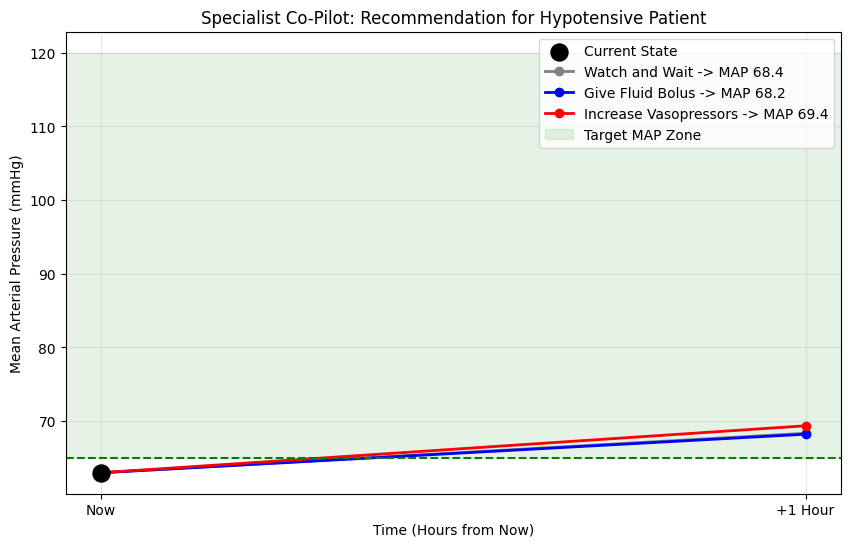


RECOMMENDATION: The optimal action to raise MAP is 'Increase Vasopressors'.


In [109]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# (Assuming 'df' is your preprocessed dataframe from the previous step)

# =================================================================
# 1. CREATE THE SPECIALIST DATASET
# =================================================================
# We only train the model on moments when the patient was hypotensive
hypotensive_df = df[df['MAP'] < 65].copy()
print(f"Training a specialist model on {len(hypotensive_df)} hypotensive time points.")

# =================================================================
# 2. TRAIN THE SPECIALIST MODEL
# =================================================================
features = ['HR', 'MAP', 'Lactate', 'Norepi_Dose', 'Action_Fluid_Bolus', 'Action_Vaso_Up']
target = 'MAP_Next_Hour'

# We can make this model more complex because the task is harder
specialist_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    objective='reg:squarederror'
)
specialist_model.fit(hypotensive_df[features], hypotensive_df[target])

print("Hypotension Specialist model trained.")

# =================================================================
# 3. RE-RUN THE RECOMMENDATION ENGINE (Using the new model)
# =================================================================
def recommend_action_specialist(patient_state):
    scenarios = pd.DataFrame([patient_state] * 3)
    scenarios.loc[0, 'Action_Fluid_Bolus'], scenarios.loc[0, 'Action_Vaso_Up'] = 0, 0
    scenarios.loc[1, 'Action_Fluid_Bolus'], scenarios.loc[1, 'Action_Vaso_Up'] = 1, 0
    scenarios.loc[2, 'Action_Fluid_Bolus'], scenarios.loc[2, 'Action_Vaso_Up'] = 0, 1

    # *** Use the specialist_model for prediction ***
    predicted_maps = specialist_model.predict(scenarios[features])
    return predicted_maps

# --- Use the same patient state as before ---
hypotensive_patient_state = df[df['MAP'] < 65].iloc[10][features].to_dict()
del hypotensive_patient_state['Action_Fluid_Bolus'], hypotensive_patient_state['Action_Vaso_Up']

print("\n--- Patient State ---")
print(f"Current MAP: {hypotensive_patient_state['MAP']:.1f} mmHg")

# --- Get Recommendation from the SPECIALIST ---
predictions = recommend_action_specialist(hypotensive_patient_state)
actions = ["Watch and Wait", "Give Fluid Bolus", "Increase Vasopressors"]
results = pd.DataFrame({'Action': actions, 'Predicted_MAP': predictions})

print("\n--- SPECIALIST Model: Expected Response Trajectories ---")
print(results)

# --- Visualize ---
plt.figure(figsize=(10, 6))
plt.scatter(0, hypotensive_patient_state['MAP'], color='black', s=150, zorder=5, label='Current State')
colors = {'Watch and Wait': 'gray', 'Give Fluid Bolus': 'blue', 'Increase Vasopressors': 'red'}
for i, row in results.iterrows():
    plt.plot([0, 1], [hypotensive_patient_state['MAP'], row['Predicted_MAP']],
             marker='o', color=colors[row['Action']], linewidth=2, label=f"{row['Action']} -> MAP {row['Predicted_MAP']:.1f}")
plt.axhspan(65, 120, color='green', alpha=0.1, label='Target MAP Zone')
plt.axhline(65, color='green', linestyle='--')
plt.title("Specialist Co-Pilot: Recommendation for Hypotensive Patient")
plt.ylabel("Mean Arterial Pressure (mmHg)")
plt.xlabel("Time (Hours from Now)")
plt.xticks([0, 1], ['Now', '+1 Hour'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_action = results.loc[results['Predicted_MAP'].idxmax()]
print(f"\nRECOMMENDATION: The optimal action to raise MAP is '{best_action['Action']}'.")

Training a specialist model on 485949 hypotensive time points.
Hypotension Specialist model trained.

--- Patient State ---
Current MAP: 59.0 mmHg
Current Lactate: 1.4
Current Norepi Dose: 0.00

--- SPECIALIST Model: Expected Response Trajectories ---
                  Action  Predicted_MAP
0         Watch and Wait      66.522934
1       Give Fluid Bolus      66.350380
2  Increase Vasopressors      67.826431


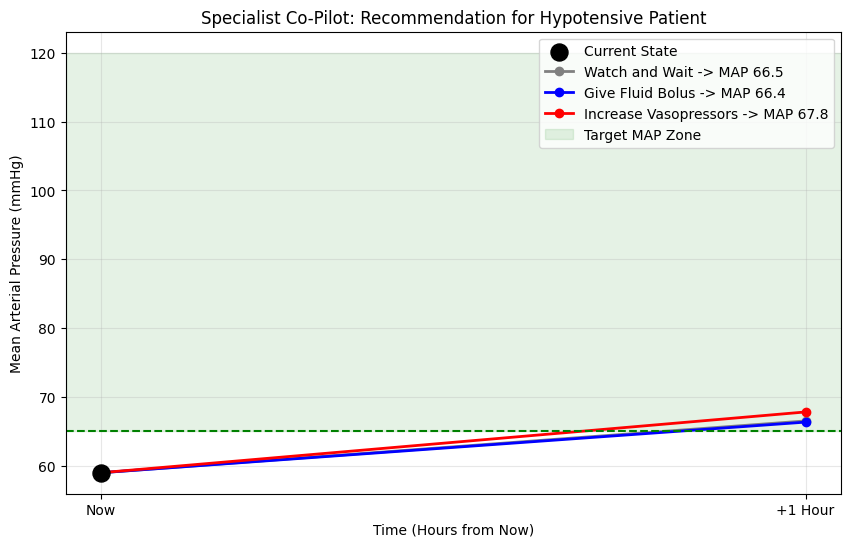


RECOMMENDATION: The optimal action to raise MAP is 'Increase Vasopressors'.


In [111]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# (Assuming 'df' is your preprocessed dataframe from the previous step)

# =================================================================
# 1. CREATE THE SPECIALIST DATASET
# =================================================================
# We only train the model on moments when the patient was hypotensive
hypotensive_df = df[df['MAP'] < 65].copy()
print(f"Training a specialist model on {len(hypotensive_df)} hypotensive time points.")

# =================================================================
# 2. TRAIN THE SPECIALIST MODEL
# =================================================================
features = ['HR', 'MAP', 'Lactate', 'Norepi_Dose', 'Action_Fluid_Bolus', 'Action_Vaso_Up']
target = 'MAP_Next_Hour'

# We can make this model more complex because the task is harder
specialist_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    objective='reg:squarederror'
)
specialist_model.fit(hypotensive_df[features], hypotensive_df[target])

print("Hypotension Specialist model trained.")

# =================================================================
# 3. RE-RUN THE RECOMMENDATION ENGINE (Using the new model)
# =================================================================
def recommend_action_specialist(patient_state):
    scenarios = pd.DataFrame([patient_state] * 3)
    scenarios.loc[0, 'Action_Fluid_Bolus'], scenarios.loc[0, 'Action_Vaso_Up'] = 0, 0
    scenarios.loc[1, 'Action_Fluid_Bolus'], scenarios.loc[1, 'Action_Vaso_Up'] = 1, 0
    scenarios.loc[2, 'Action_Fluid_Bolus'], scenarios.loc[2, 'Action_Vaso_Up'] = 0, 1

    # *** Use the specialist_model for prediction ***
    predicted_maps = specialist_model.predict(scenarios[features])
    return predicted_maps

# --- Use the same patient state as before ---
# We pick a new patient from the hypotensive set to test
hypotensive_patient_state = hypotensive_df.iloc[50][features].to_dict()
del hypotensive_patient_state['Action_Fluid_Bolus'], hypotensive_patient_state['Action_Vaso_Up']

print("\n--- Patient State ---")
print(f"Current MAP: {hypotensive_patient_state['MAP']:.1f} mmHg")
print(f"Current Lactate: {hypotensive_patient_state['Lactate']:.1f}")
print(f"Current Norepi Dose: {hypotensive_patient_state['Norepi_Dose']:.2f}")


# --- Get Recommendation from the SPECIALIST ---
predictions = recommend_action_specialist(hypotensive_patient_state)
actions = ["Watch and Wait", "Give Fluid Bolus", "Increase Vasopressors"]
results = pd.DataFrame({'Action': actions, 'Predicted_MAP': predictions})

print("\n--- SPECIALIST Model: Expected Response Trajectories ---")
print(results)

# --- Visualize ---
plt.figure(figsize=(10, 6))
plt.scatter(0, hypotensive_patient_state['MAP'], color='black', s=150, zorder=5, label='Current State')
colors = {'Watch and Wait': 'gray', 'Give Fluid Bolus': 'blue', 'Increase Vasopressors': 'red'}
for i, row in results.iterrows():
    plt.plot([0, 1], [hypotensive_patient_state['MAP'], row['Predicted_MAP']],
             marker='o', color=colors[row['Action']], linewidth=2, label=f"{row['Action']} -> MAP {row['Predicted_MAP']:.1f}")
plt.axhspan(65, 120, color='green', alpha=0.1, label='Target MAP Zone')
plt.axhline(65, color='green', linestyle='--')
plt.title("Specialist Co-Pilot: Recommendation for Hypotensive Patient")
plt.ylabel("Mean Arterial Pressure (mmHg)")
plt.xlabel("Time (Hours from Now)")
plt.xticks([0, 1], ['Now', '+1 Hour'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_action = results.loc[results['Predicted_MAP'].idxmax()]
print(f"\nRECOMMENDATION: The optimal action to raise MAP is '{best_action['Action']}'.")

Training on 388759 samples, testing on 97190 samples.

Running 100 bootstrap iterations...


100%|██████████| 100/100 [05:30<00:00,  3.30s/it]


Bootstrap validation complete.

Model Performance (Mean Absolute Error on MAP):
  - Mean MAE: 53.04 mmHg
  - 95% Confidence Interval: [43.68, 77.16] mmHg


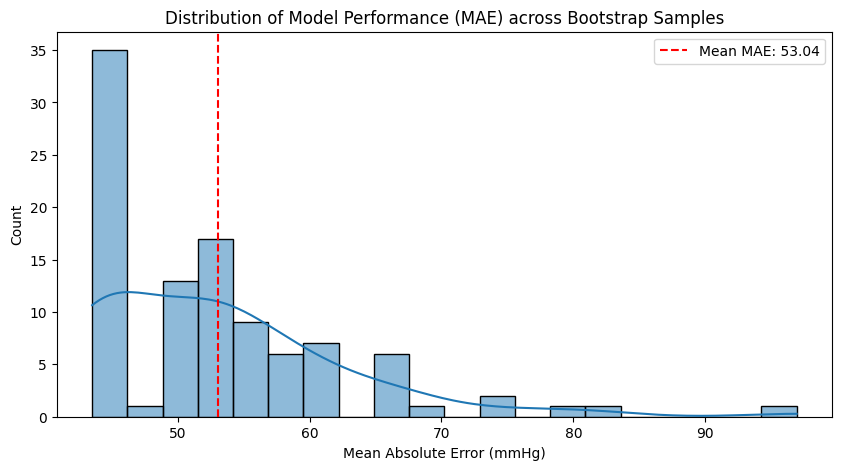

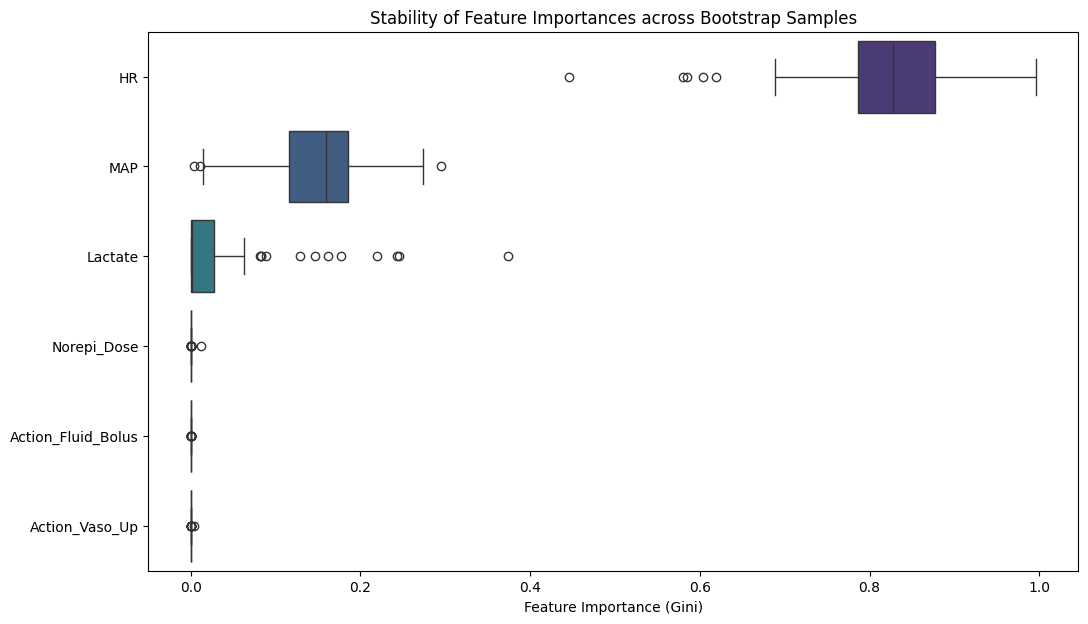

In [112]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample
from tqdm import tqdm # For a nice progress bar

# (Assuming 'df' is your fully preprocessed dataframe from the "Hemodynamic Co-Pilot" step)

# =================================================================
# 1. SETUP: Create a single Train/Test Split
# =================================================================
# We only train on hypotensive moments
hypotensive_df = df[df['MAP'] < 65].copy()

features = ['HR', 'MAP', 'Lactate', 'Norepi_Dose', 'Action_Fluid_Bolus', 'Action_Vaso_Up']
target = 'MAP_Next_Hour'

X = hypotensive_df[features]
y = hypotensive_df[target]

# Create a single, held-out test set (20% of the data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.")

# =================================================================
# 2. BOOTSTRAP LOOP
# =================================================================
n_iterations = 100  # Number of bootstrap samples to create
performance_scores = []
feature_importances = []

print(f"\nRunning {n_iterations} bootstrap iterations...")
for i in tqdm(range(n_iterations)):
    # Create a bootstrap sample of the training data (sampling with replacement)
    X_sample, y_sample = resample(X_train, y_train)

    # Train a new model on the bootstrap sample
    model = xgb.XGBRegressor(
        n_estimators=100, # Fewer estimators to speed up the loop
        max_depth=5,
        learning_rate=0.05,
        objective='reg:squarederror',
        n_jobs=-1 # Use all CPU cores
    )
    model.fit(X_sample, y_sample)

    # Evaluate on the ORIGINAL, HELD-OUT test set
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    # Store the results
    performance_scores.append(mae)
    feature_importances.append(model.feature_importances_)

print("Bootstrap validation complete.")

# =================================================================
# 3. ANALYZE THE RESULTS
# =================================================================

# --- A. Performance Stability ---
scores_array = np.array(performance_scores)
mean_mae = scores_array.mean()
ci_95 = np.percentile(scores_array, [2.5, 97.5])

print(f"\nModel Performance (Mean Absolute Error on MAP):")
print(f"  - Mean MAE: {mean_mae:.2f} mmHg")
print(f"  - 95% Confidence Interval: [{ci_95[0]:.2f}, {ci_95[1]:.2f}] mmHg")

plt.figure(figsize=(10, 5))
sns.histplot(scores_array, kde=True, bins=20)
plt.title("Distribution of Model Performance (MAE) across Bootstrap Samples")
plt.xlabel("Mean Absolute Error (mmHg)")
plt.axvline(mean_mae, color='red', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')
plt.legend()
plt.show()


# --- B. Feature Importance Stability ---
importance_df = pd.DataFrame(feature_importances, columns=features)

plt.figure(figsize=(12, 7))
sns.boxplot(data=importance_df, orient='h', palette='viridis')
plt.title("Stability of Feature Importances across Bootstrap Samples")
plt.xlabel("Feature Importance (Gini)")
plt.show()

In [113]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# (Assuming 'action_matrix' is your raw dataframe from the SQL query)

# =================================================================
# 1. ROBUST PREPROCESSING
# =================================================================
df = action_matrix.copy()

# --- A. Create Rolling Features ---
# This smooths the data and provides trend information
grouped = df.groupby('visit_occurrence_id')
df['MAP_rolling_avg_3h'] = grouped['MAP'].transform(lambda x: x.rolling(3, 1).mean())
df['HR_rolling_avg_3h'] = grouped['HR'].transform(lambda x: x.rolling(3, 1).mean())

# --- B. Careful Forward-Fill ---
# We fill AFTER creating rolling features
df[['HR', 'MAP', 'Lactate']] = grouped[['HR', 'MAP', 'Lactate']].ffill(limit=4)

# --- C. Drop Rows with Lingering NaNs ---
# If after ffill, there are still NaNs, it means the data gap was too long. Drop them.
df = df.dropna(subset=['MAP', 'HR', 'MAP_rolling_avg_3h'])

# --- D. Create Actions and Target ---
df['Norepi_Prev_Hour'] = df.groupby('visit_occurrence_id')['Norepi_Dose'].shift(1).fillna(0)
df['Action_Vaso_Up'] = (df['Norepi_Dose'] > df['Norepi_Prev_Hour']).astype(int)
df['MAP_Next_Hour'] = df.groupby('visit_occurrence_id')['MAP'].shift(-1)

# Final cleanup
df = df.dropna(subset=['MAP_Next_Hour'])

# =================================================================
# 2. TRAIN A SINGLE, ROBUST SPECIALIST MODEL
# =================================================================
# Let's test one model before running the whole bootstrap loop again
hypotensive_df = df[df['MAP'] < 65].copy()

# *** UPDATED FEATURE LIST ***
features = [
    'HR', 'MAP', 'Lactate', 'Norepi_Dose',
    'Action_Fluid_Bolus', 'Action_Vaso_Up',
    'MAP_rolling_avg_3h', 'HR_rolling_avg_3h' # New features
]
target = 'MAP_Next_Hour'

X = hypotensive_df[features]
y = hypotensive_df[target]

# Impute any final NaNs in the training set (e.g., Lactate)
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    objective='reg:squarederror'
)
model.fit(X_train, y_train)

# =================================================================
# 3. VALIDATE THE FIX
# =================================================================
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n--- Performance after Robust Preprocessing ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} mmHg")

/tmp/ipython-input-3453176846.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Norepi_Prev_Hour'] = df.groupby('visit_occurrence_id')['Norepi_Dose'].shift(1).fillna(0)
/tmp/ipython-input-3453176846.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Action_Vaso_Up'] = (df['Norepi_Dose'] > df['Norepi_Prev_Hour']).astype(int)
/tmp/ipython-input-3453176846.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va


--- Performance after Robust Preprocessing ---
Mean Absolute Error (MAE): 107.05 mmHg


In [114]:
# (Assuming 'df' is your preprocessed dataframe from the previous step)
print("--- Inspecting the Data Before Training ---")
print(df[['HR', 'MAP', 'Lactate', 'MAP_Next_Hour']].describe().T)

--- Inspecting the Data Before Training ---
                   count       mean          std        min        25%  \
HR             3866085.0  88.098554    72.684669      -95.0  74.333333   
MAP            3866085.0  88.261930  4156.020660 -3261332.0  71.000000   
Lactate        1245190.0   1.604959     1.508474        0.0   0.900000   
MAP_Next_Hour  3866085.0  87.545559  4474.996212 -3261332.0  71.000000   

                     50%         75%           max  
HR             87.000000  100.333333  9.616000e+04  
MAP            80.999986   93.000000  6.395321e+06  
Lactate         1.200000    1.700000  2.980000e+01  
MAP_Next_Hour  81.000000   93.000000  6.395321e+06  


In [115]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# (Assuming 'action_matrix' is your raw dataframe from the SQL query)

# =================================================================
# 1. AGGRESSIVE OUTLIER CLEANING (The "Sledgehammer")
# =================================================================
df = action_matrix.copy()

# --- Define Physiological Limits ---
limits = {
    'HR': (30, 200),
    'MAP': (30, 250),
    'Lactate': (0, 30)
}

# --- Apply Limits (Replace Outliers with NaN) ---
for col, (min_val, max_val) in limits.items():
    if col in df.columns:
        bad_mask = (df[col] < min_val) | (df[col] > max_val)
        df.loc[bad_mask, col] = np.nan

print("Aggressive outlier cleaning complete.")

# =================================================================
# 2. ROBUST PREPROCESSING & FEATURE ENGINEERING
# =================================================================

# --- A. Create Rolling Features (on the cleaned data) ---
grouped = df.groupby('visit_occurrence_id')
df['MAP_rolling_avg_3h'] = grouped['MAP'].transform(lambda x: x.rolling(3, 1).mean())
df['HR_rolling_avg_3h'] = grouped['HR'].transform(lambda x: x.rolling(3, 1).mean())

# --- B. Careful Forward-Fill ---
df[['HR', 'MAP', 'Lactate', 'MAP_rolling_avg_3h', 'HR_rolling_avg_3h']] = \
    grouped[['HR', 'MAP', 'Lactate', 'MAP_rolling_avg_3h', 'HR_rolling_avg_3h']].ffill(limit=4)

# --- C. Drop Rows with Lingering NaNs ---
df = df.dropna(subset=['MAP', 'HR', 'MAP_rolling_avg_3h'])

# --- D. Create Actions and Target ---
df['Norepi_Prev_Hour'] = df.groupby('visit_occurrence_id')['Norepi_Dose'].shift(1).fillna(0)
df['Action_Vaso_Up'] = (df['Norepi_Dose'] > df['Norepi_Prev_Hour']).astype(int)
df['MAP_Next_Hour'] = df.groupby('visit_occurrence_id')['MAP'].shift(-1)

# --- E. Final Cleanup ---
# Also, we must clean the TARGET column for outliers
df.loc[(df['MAP_Next_Hour'] < 30) | (df['MAP_Next_Hour'] > 250), 'MAP_Next_Hour'] = np.nan
df = df.dropna(subset=['MAP_Next_Hour'])

# =================================================================
# 3. TRAIN A SINGLE, ROBUST SPECIALIST MODEL
# =================================================================
hypotensive_df = df[df['MAP'] < 65].copy()

features = [
    'HR', 'MAP', 'Lactate', 'Norepi_Dose',
    'Action_Fluid_Bolus', 'Action_Vaso_Up',
    'MAP_rolling_avg_3h', 'HR_rolling_avg_3h'
]
target = 'MAP_Next_Hour'

X = hypotensive_df[features]
y = hypotensive_df[target]

# Impute any final NaNs (e.g., Lactate)
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    objective='reg:squarederror'
)
model.fit(X_train, y_train)

# =================================================================
# 4. VALIDATE THE FIX
# =================================================================
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n--- Performance after FINAL Preprocessing ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} mmHg")

Aggressive outlier cleaning complete.


/tmp/ipython-input-1098154211.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Norepi_Prev_Hour'] = df.groupby('visit_occurrence_id')['Norepi_Dose'].shift(1).fillna(0)
/tmp/ipython-input-1098154211.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Action_Vaso_Up'] = (df['Norepi_Dose'] > df['Norepi_Prev_Hour']).astype(int)
/tmp/ipython-input-1098154211.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va


--- Performance after FINAL Preprocessing ---
Mean Absolute Error (MAE): 7.08 mmHg


--- Patient State ---
Current MAP: 63.0 mmHg
Current Lactate: 3.9
Current Norepi Dose: 4049.96

--- Hemodynamic Co-Pilot: Expected Response Trajectories ---
                  Action  Predicted_MAP
0         Watch and Wait      65.034386
1       Give Fluid Bolus      65.034386
2  Increase Vasopressors      65.057922


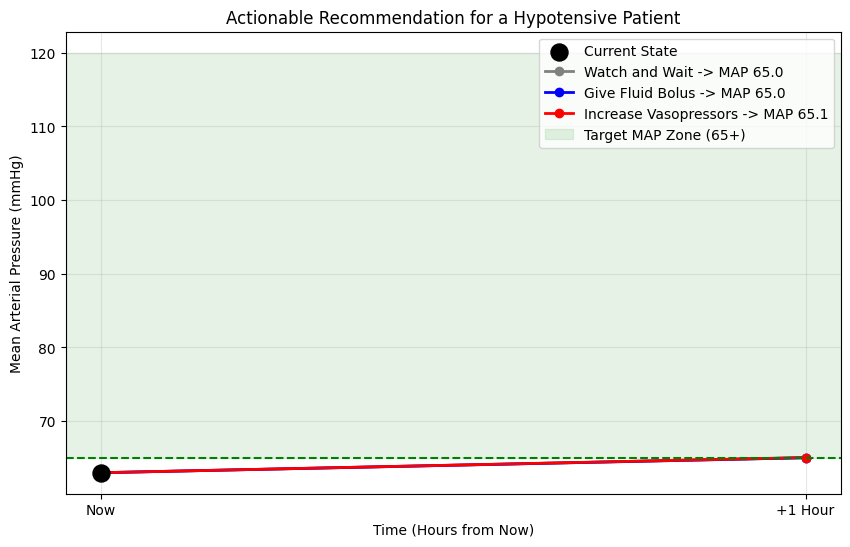


RECOMMENDATION: The optimal action to raise MAP is 'Increase Vasopressors'.


In [116]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# (Assuming 'df' and 'hypotensive_df' are your cleaned dataframes,
# and 'model' is your trained XGBoost model from the previous step)

# =================================================================
# 1. THE RECOMMENDATION ENGINE
# =================================================================
def recommend_action(patient_state, trained_model):
    """
    Takes a patient's current state and a trained model,
    and simulates the outcome of three different actions.
    """
    scenarios = pd.DataFrame([patient_state] * 3)

    # Define the 3 scenarios
    # A: Do Nothing
    scenarios.loc[0, 'Action_Fluid_Bolus'], scenarios.loc[0, 'Action_Vaso_Up'] = 0, 0
    # B: Give Fluids
    scenarios.loc[1, 'Action_Fluid_Bolus'], scenarios.loc[1, 'Action_Vaso_Up'] = 1, 0
    # C: Increase Vasopressors
    scenarios.loc[2, 'Action_Fluid_Bolus'], scenarios.loc[2, 'Action_Vaso_Up'] = 0, 1

    # Use the trained model to predict the MAP for each scenario
    # We need to make sure the feature names are in the correct order
    feature_order = trained_model.get_booster().feature_names
    predicted_maps = trained_model.predict(scenarios[feature_order])

    return predicted_maps

# =================================================================
# 2. SELECT A PATIENT AND GET RECOMMENDATION
# =================================================================
# Find a representative hypotensive patient to test
# Let's pick one who is already on a little bit of Norepinephrine
test_patient_state = hypotensive_df[hypotensive_df['Norepi_Dose'] > 0].iloc[5].to_dict()

# Prepare the state dictionary for the function
current_state = {k: v for k, v in test_patient_state.items() if k in features}
del current_state['Action_Fluid_Bolus'], current_state['Action_Vaso_Up']

print("--- Patient State ---")
print(f"Current MAP: {current_state['MAP']:.1f} mmHg")
print(f"Current Lactate: {current_state.get('Lactate', 'N/A'):.1f}")
print(f"Current Norepi Dose: {current_state['Norepi_Dose']:.2f}")

# Get the recommendation
predictions = recommend_action(current_state, model)
actions = ["Watch and Wait", "Give Fluid Bolus", "Increase Vasopressors"]
results = pd.DataFrame({'Action': actions, 'Predicted_MAP': predictions})

print("\n--- Hemodynamic Co-Pilot: Expected Response Trajectories ---")
print(results)

# =================================================================
# 3. VISUALIZE THE RECOMMENDATION
# =================================================================
plt.figure(figsize=(10, 6))
plt.scatter(0, current_state['MAP'], color='black', s=150, zorder=5, label='Current State')

colors = {'Watch and Wait': 'gray', 'Give Fluid Bolus': 'blue', 'Increase Vasopressors': 'red'}
for i, row in results.iterrows():
    plt.plot([0, 1], [current_state['MAP'], row['Predicted_MAP']],
             marker='o', color=colors[row['Action']], linewidth=2, label=f"{row['Action']} -> MAP {row['Predicted_MAP']:.1f}")

plt.axhspan(65, 120, color='green', alpha=0.1, label='Target MAP Zone (65+)')
plt.axhline(65, color='green', linestyle='--')
plt.title("Actionable Recommendation for a Hypotensive Patient")
plt.ylabel("Mean Arterial Pressure (mmHg)")
plt.xlabel("Time (Hours from Now)")
plt.xticks([0, 1], ['Now', '+1 Hour'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Final Recommendation Text ---
best_action = results.loc[results['Predicted_MAP'].idxmax()]
print(f"\nRECOMMENDATION: The optimal action to raise MAP is '{best_action['Action']}'.")

In [117]:
%%bigquery vitals_matrix
SELECT
    v.visit_occurrence_id,
    -- Truncate the timestamp to the hour to align all measurements
    TIMESTAMP_TRUNC(m.measurement_datetime, HOUR) as chart_hour,

    -- === Hemodynamics ===
    AVG(CASE WHEN m.measurement_concept_id = 3001376 THEN m.value_as_number END) as Heart_Rate,
    AVG(CASE WHEN m.measurement_concept_id = 21490852 THEN m.value_as_number END) as Invasive_MAP,
    AVG(CASE WHEN m.measurement_concept_id = 40762499 THEN m.value_as_number END) as SpO2,

    -- === Respiratory ===
    AVG(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as FiO2,
    AVG(CASE WHEN m.measurement_concept_id = 3022875 THEN m.value_as_number END) as PEEP,
    AVG(CASE WHEN m.measurement_concept_id = 3024171 THEN m.value_as_number END) as Resp_Rate,

    -- === The "Golden" Features ===
    AVG(CASE WHEN m.measurement_concept_id = 5767196 THEN m.value_as_number END) as Lung_Compliance,
    AVG(CASE WHEN m.measurement_concept_id = 3785229 THEN m.value_as_number END) as Airway_Resistance

FROM `visit_occurrence` v
JOIN `measurement` m ON v.person_id = m.person_id
WHERE
    -- Filter for a single patient to test the query quickly
    v.visit_occurrence_id = 10425 -- Replace with any valid visit_occurrence_id
    AND m.measurement_concept_id IN (
        -- List of the key IDs from your table
        3001376, 21490852, 40762499, -- Hemodynamics
        2000000204, 3022875, 3024171, -- Respiratory
        5767196, 3785229 -- Advanced Mechanics
    )
GROUP BY
    v.visit_occurrence_id, chart_hour
ORDER BY
    chart_hour

Query is running:   0%|          |

Downloading:   0%|          |

In [118]:
vitals_matrix

visit_occurrence_id                chart_hour  Heart_Rate  Invasive_MAP  \
0                 10425 2010-01-01 00:00:00+00:00         NaN     88.999995   
1                 10425 2010-01-01 01:00:00+00:00         NaN     75.999998   
2                 10425 2010-01-01 02:00:00+00:00         NaN     72.000001   
3                 10425 2010-01-01 03:00:00+00:00         NaN     61.000002   
4                 10425 2010-01-01 04:00:00+00:00         NaN     84.999991   
5                 10425 2010-01-01 05:00:00+00:00         NaN     84.999991   
6                 10425 2010-01-01 06:00:00+00:00         NaN     70.000003   
7                 10425 2010-01-01 07:00:00+00:00         NaN     67.999997   
8                 10425 2010-01-01 08:00:00+00:00         NaN     59.999996   
9                 10425 2010-01-01 09:00:00+00:00         NaN     62.000002   
10                10425 2010-01-01 10:00:00+00:00         NaN     59.000000   
11                10425 2010-01-01 11:00:00+00:00         NaN     84.999991   
12                10425 2010-01-01 12:00:00+00:00         NaN     64.999999   
13                10425 2010-01-01 13:00:00+00:00         NaN     62.000002   
14                10425 2010-01-01 14:00:00+00:00         NaN     67.999997   
15                10425 2010-01-01 15:00:00+00:00         NaN     71.000002   
16                10425 2010-01-01 16:00:00+00:00         NaN     75.999998   
17                10425 2010-01-01 17:00:00+00:00         NaN     72.000001   
18                10425 2010-01-01 18:00:00+00:00         NaN     62.000002   
19                10425 2010-01-01 19:00:00+00:00         NaN     76.999982   
20                10425 2010-01-01 20:00:00+00:00         NaN     64.999999   
21                10425 2010-01-01 21:00:00+00:00         NaN     59.000000   

    SpO2       FiO2  PEEP  Resp_Rate  Lung_Compliance  Airway_Resistance  
0    NaN  40.150000   5.0       13.0              NaN                NaN  
1    NaN  40.299999   5.0       13.0              NaN                NaN  
2    NaN  40.200001   5.0       13.0              NaN                NaN  
3    NaN  40.299999   5.0       13.6              NaN                NaN  
4    NaN        NaN   NaN        NaN              NaN                NaN  
5    NaN        NaN   NaN        NaN              NaN                NaN  
6    NaN        NaN   NaN        NaN              NaN                NaN  
7    NaN        NaN   NaN        NaN              NaN                NaN  
8    NaN        NaN   NaN        NaN              NaN                NaN  
9    NaN        NaN   NaN        NaN              NaN                NaN  
10   NaN        NaN   NaN        NaN              NaN                NaN  
11   NaN        NaN   NaN        NaN              NaN                NaN  
12   NaN        NaN   NaN        NaN              NaN                NaN  
13   NaN        NaN   NaN        NaN              NaN                NaN  
14   NaN        NaN   NaN        NaN              NaN                NaN  
15   NaN        NaN   NaN        NaN              NaN                NaN  
16   NaN        NaN   NaN        NaN              NaN                NaN  
17   NaN        NaN   NaN        NaN              NaN                NaN  
18   NaN        NaN   NaN        NaN              NaN                NaN  
19   NaN        NaN   NaN        NaN              NaN                NaN  
20   NaN        NaN   NaN        NaN              NaN                NaN  
21   NaN        NaN   NaN        NaN              NaN                NaN

In [119]:
%%bigquery vitals_matrix
SELECT
    v.visit_occurrence_id,
    TIMESTAMP_TRUNC(m.measurement_datetime, HOUR) as chart_hour,

    -- === Hemodynamics (Combining all sources) ===
    AVG(CASE WHEN m.measurement_concept_id IN (
        3001376, -- HR by Pulse Ox
        21490872, -- HR by EKG
        3003841, -- HR by Palpation
        3027018  -- Generic HR
    ) THEN m.value_as_number END) as Heart_Rate,

    AVG(CASE WHEN m.measurement_concept_id = 21490852 THEN m.value_as_number END) as Invasive_MAP,
    AVG(CASE WHEN m.measurement_concept_id = 40762499 THEN m.value_as_number END) as SpO2,

    -- === Respiratory (Using correct IDs) ===
    AVG(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as FiO2,
    AVG(CASE WHEN m.measurement_concept_id = 3022875 THEN m.value_as_number END) as PEEP,
    AVG(CASE WHEN m.measurement_concept_id = 3024171 THEN m.value_as_number END) as Resp_Rate,

    -- === Advanced Mechanics (Using correct IDs from your list) ===
    AVG(CASE WHEN m.measurement_concept_id = 21490581 THEN m.value_as_number END) as Lung_Compliance,
    AVG(CASE WHEN m.measurement_concept_id = 21490740 THEN m.value_as_number END) as Airway_Resistance

FROM `visit_occurrence` v
JOIN `measurement` m ON v.person_id = m.person_id
WHERE
    -- Filter for the same patient to test
    v.visit_occurrence_id = 10425
    -- Update the WHERE clause to include ALL the correct IDs
    AND m.measurement_concept_id IN (
        3001376, 21490872, 3003841, 3027018, -- All HRs
        21490852, 40762499, -- MAP, SpO2
        2000000204, 3022875, 3024171, -- Respiratory
        21490581, 21490740 -- Advanced Mechanics
    )
GROUP BY
    v.visit_occurrence_id, chart_hour
ORDER BY
    chart_hour

Query is running:   0%|          |

Downloading:   0%|          |

In [120]:
vitals_matrix

visit_occurrence_id                chart_hour  Heart_Rate  Invasive_MAP  \
0                 10425 2010-01-01 00:00:00+00:00        54.0     88.999995   
1                 10425 2010-01-01 01:00:00+00:00        60.0     75.999998   
2                 10425 2010-01-01 02:00:00+00:00        61.0     72.000001   
3                 10425 2010-01-01 03:00:00+00:00        86.0     61.000002   
4                 10425 2010-01-01 04:00:00+00:00        64.0     84.999991   
5                 10425 2010-01-01 05:00:00+00:00        79.0     84.999991   
6                 10425 2010-01-01 06:00:00+00:00        76.0     70.000003   
7                 10425 2010-01-01 07:00:00+00:00        76.0     67.999997   
8                 10425 2010-01-01 08:00:00+00:00        79.0     59.999996   
9                 10425 2010-01-01 09:00:00+00:00        79.0     62.000002   
10                10425 2010-01-01 10:00:00+00:00        72.0     59.000000   
11                10425 2010-01-01 11:00:00+00:00        83.0     84.999991   
12                10425 2010-01-01 12:00:00+00:00        68.0     64.999999   
13                10425 2010-01-01 13:00:00+00:00        77.0     62.000002   
14                10425 2010-01-01 14:00:00+00:00        74.0     67.999997   
15                10425 2010-01-01 15:00:00+00:00        73.0     71.000002   
16                10425 2010-01-01 16:00:00+00:00        71.0     75.999998   
17                10425 2010-01-01 17:00:00+00:00        66.0     72.000001   
18                10425 2010-01-01 18:00:00+00:00        62.0     62.000002   
19                10425 2010-01-01 19:00:00+00:00        61.0     76.999982   
20                10425 2010-01-01 20:00:00+00:00        76.0     64.999999   
21                10425 2010-01-01 21:00:00+00:00        80.0     59.000000   

    SpO2       FiO2  PEEP  Resp_Rate  Lung_Compliance  Airway_Resistance  
0    NaN  40.150000   5.0       13.0              NaN                NaN  
1    NaN  40.299999   5.0       13.0              NaN                NaN  
2    NaN  40.200001   5.0       13.0              NaN                NaN  
3    NaN  40.299999   5.0       13.6              NaN                NaN  
4    NaN        NaN   NaN        NaN              NaN                NaN  
5    NaN        NaN   NaN        NaN              NaN                NaN  
6    NaN        NaN   NaN        NaN              NaN                NaN  
7    NaN        NaN   NaN        NaN              NaN                NaN  
8    NaN        NaN   NaN        NaN              NaN                NaN  
9    NaN        NaN   NaN        NaN              NaN                NaN  
10   NaN        NaN   NaN        NaN              NaN                NaN  
11   NaN        NaN   NaN        NaN              NaN                NaN  
12   NaN        NaN   NaN        NaN              NaN                NaN  
13   NaN        NaN   NaN        NaN              NaN                NaN  
14   NaN        NaN   NaN        NaN              NaN                NaN  
15   NaN        NaN   NaN        NaN              NaN                NaN  
16   NaN        NaN   NaN        NaN              NaN                NaN  
17   NaN        NaN   NaN        NaN              NaN                NaN  
18   NaN        NaN   NaN        NaN              NaN                NaN  
19   NaN        NaN   NaN        NaN              NaN                NaN  
20   NaN        NaN   NaN        NaN              NaN                NaN  
21   NaN        NaN   NaN        NaN              NaN                NaN

In [121]:
%%bigquery spo2_ids
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(*) as count
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    -- Search for all possible SpO2-related terms
    REGEXP_CONTAINS(LOWER(c.concept_name), r'spo2|oxygen saturation|pulse oximetry|saturatie')
    -- Exclude lab-based saturation (SaO2) to focus on continuous monitoring
    AND NOT REGEXP_CONTAINS(LOWER(c.concept_name), r'arterial blood gas|in blood')
GROUP BY 1, 2
ORDER BY count DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [122]:
spo2_ids

concept_id                                       concept_name     count
0    40762499  Oxygen saturation in Arterial blood by Pulse o...  15126034
1     3001376                       Heart rate by Pulse oximetry  14081859
2     3016502                Oxygen saturation in Arterial blood   1284380
3     3024928                  Oxygen saturation in Venous blood    311516
4     3018465            Oxygen saturation in Mixed venous blood      5098
5     1616373          Oxygen saturation in Central venous blood      1545
6     3021901               Oxygen saturation in Capillary blood        72

In [123]:
%%bigquery vitals_matrix
SELECT
    v.visit_occurrence_id,
    TIMESTAMP_TRUNC(m.measurement_datetime, HOUR) as chart_hour,

    -- === Hemodynamics (Combining all sources) ===
    AVG(CASE WHEN m.measurement_concept_id IN (3001376, 21490872, 3003841, 3027018) THEN m.value_as_number END) as Heart_Rate,
    AVG(CASE WHEN m.measurement_concept_id = 21490852 THEN m.value_as_number END) as Invasive_MAP,

    -- *** THE FIX: Combine SpO2 (Pulse Ox) and SaO2 (Arterial Blood Gas) ***
    AVG(CASE WHEN m.measurement_concept_id IN (
        40762499, -- SpO2 by Pulse Oximetry
        3016502   -- SaO2 from Arterial Blood
    ) THEN m.value_as_number END) as SpO2,

    -- === Respiratory ===
    AVG(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as FiO2,
    AVG(CASE WHEN m.measurement_concept_id = 3022875 THEN m.value_as_number END) as PEEP,
    AVG(CASE WHEN m.measurement_concept_id = 3024171 THEN m.value_as_number END) as Resp_Rate,

    -- === Advanced Mechanics ===
    AVG(CASE WHEN m.measurement_concept_id = 21490581 THEN m.value_as_number END) as Lung_Compliance,
    AVG(CASE WHEN m.measurement_concept_id = 21490740 THEN m.value_as_number END) as Airway_Resistance

FROM `visit_occurrence` v
JOIN `measurement` m ON v.person_id = m.person_id
WHERE
    -- Filter for the same patient to test
    v.visit_occurrence_id = 10425
GROUP BY
    v.visit_occurrence_id, chart_hour
ORDER BY
    chart_hour

Query is running:   0%|          |

Downloading:   0%|          |

In [124]:
vitals_matrix

visit_occurrence_id                chart_hour  Heart_Rate  Invasive_MAP  \
0                 10425 2009-12-24 00:00:00+00:00         NaN           NaN   
1                 10425 2009-12-31 18:00:00+00:00         NaN           NaN   
2                 10425 2010-01-01 00:00:00+00:00        54.0     88.999995   
3                 10425 2010-01-01 01:00:00+00:00        60.0     75.999998   
4                 10425 2010-01-01 02:00:00+00:00        61.0     72.000001   
5                 10425 2010-01-01 03:00:00+00:00        86.0     61.000002   
6                 10425 2010-01-01 04:00:00+00:00        64.0     84.999991   
7                 10425 2010-01-01 05:00:00+00:00        79.0     84.999991   
8                 10425 2010-01-01 06:00:00+00:00        76.0     70.000003   
9                 10425 2010-01-01 07:00:00+00:00        76.0     67.999997   
10                10425 2010-01-01 08:00:00+00:00        79.0     59.999996   
11                10425 2010-01-01 09:00:00+00:00        79.0     62.000002   
12                10425 2010-01-01 10:00:00+00:00        72.0     59.000000   
13                10425 2010-01-01 11:00:00+00:00        83.0     84.999991   
14                10425 2010-01-01 12:00:00+00:00        68.0     64.999999   
15                10425 2010-01-01 13:00:00+00:00        77.0     62.000002   
16                10425 2010-01-01 14:00:00+00:00        74.0     67.999997   
17                10425 2010-01-01 15:00:00+00:00        73.0     71.000002   
18                10425 2010-01-01 16:00:00+00:00        71.0     75.999998   
19                10425 2010-01-01 17:00:00+00:00        66.0     72.000001   
20                10425 2010-01-01 18:00:00+00:00        62.0     62.000002   
21                10425 2010-01-01 19:00:00+00:00        61.0     76.999982   
22                10425 2010-01-01 20:00:00+00:00        76.0     64.999999   
23                10425 2010-01-01 21:00:00+00:00        80.0     59.000000   

    SpO2       FiO2  PEEP  Resp_Rate  Lung_Compliance  Airway_Resistance  
0    NaN        NaN   NaN        NaN              NaN                NaN  
1   0.98        NaN   NaN        NaN              NaN                NaN  
2   0.99  40.150000   5.0       13.0              NaN                NaN  
3    NaN  40.299999   5.0       13.0              NaN                NaN  
4    NaN  40.200001   5.0       13.0              NaN                NaN  
5    NaN  40.299999   5.0       13.6              NaN                NaN  
6    NaN        NaN   NaN        NaN              NaN                NaN  
7   0.99        NaN   NaN        NaN              NaN                NaN  
8    NaN        NaN   NaN        NaN              NaN                NaN  
9    NaN        NaN   NaN        NaN              NaN                NaN  
10   NaN        NaN   NaN        NaN              NaN                NaN  
11   NaN        NaN   NaN        NaN              NaN                NaN  
12   NaN        NaN   NaN        NaN              NaN                NaN  
13   NaN        NaN   NaN        NaN              NaN                NaN  
14   NaN        NaN   NaN        NaN              NaN                NaN  
15   NaN        NaN   NaN        NaN              NaN                NaN  
16  0.98        NaN   NaN        NaN              NaN                NaN  
17   NaN        NaN   NaN        NaN              NaN                NaN  
18   NaN        NaN   NaN        NaN              NaN                NaN  
19   NaN        NaN   NaN        NaN              NaN                NaN  
20  0.98        NaN   NaN        NaN              NaN                NaN  
21   NaN        NaN   NaN        NaN              NaN                NaN  
22   NaN        NaN   NaN        NaN              NaN                NaN  
23   NaN        NaN   NaN        NaN              NaN                NaN

In [125]:
import pandas as pd
from google.cloud import bigquery
from IPython.display import display, Markdown

# --- Configuration (Use the variables from the top of your notebook) ---
DATASET_PROJECT_ID = 'amsterdamumcdb'
DATASET_ID = 'van_gogh_2026_datathon'
full_dataset_path = f"{DATASET_PROJECT_ID}.{DATASET_ID}"

# Assuming 'client' is your initialized BigQuery client object
# If not, uncomment the line below
# client = bigquery.Client(location='eu')

# --- Define the tables and the concept columns we want to count ---
# This map tells the script which column to count for each table
table_to_column_map = {
    'condition_occurrence': 'condition_concept_id',
    'drug_exposure': 'drug_concept_id',
    'measurement': 'measurement_concept_id',
    'observation': 'observation_concept_id',
    'device_exposure': 'device_concept_id',
    'visit_occurrence': 'visit_concept_id'
}

# --- Loop through each table and run the query ---
for table_name, concept_column in table_to_column_map.items():

    display(Markdown(f"## Top 10 Records for: `{table_name}`"))

    # Construct the dynamic SQL query
    sql_query = f"""
        SELECT
            c.concept_name,
            t.{concept_column},
            COUNT(*) as record_count
        FROM
            `{full_dataset_path}.{table_name}` AS t
        JOIN
            `{full_dataset_path}.concept` AS c ON t.{concept_column} = c.concept_id
        GROUP BY
            c.concept_name, t.{concept_column}
        ORDER BY
            record_count DESC
        LIMIT 50
    """

    try:
        # Execute the query and display the result
        df = client.query(sql_query).to_dataframe()

        if df.empty:
            print("No records found or table is empty.")
        else:
            display(df)

    except Exception as e:
        # Handle cases where a table might not exist (like device_exposure)
        print(f"Could not query table '{table_name}'. It might not exist in this dataset.")
        print(f"Error: {e}")

print("\n--- Analysis Complete ---")

## Top 10 Records for: `condition_occurrence`

concept_name  condition_concept_id  record_count
0  No matching concept                     0        277103

## Top 10 Records for: `drug_exposure`

concept_name  drug_concept_id  record_count
0                             sodium chloride           967823       2199380
1                               acetaminophen          1125315       1123530
2                                     glucose          1560524        551577
3                              norepinephrine          1321341        547514
4                                    propofol           753626        448087
5  selective digestive decontamination - oral       2000000571        443155
6                              insulin aspart         35198096        367210
7                                  nadroparin         19001014        345724
8                          potassium chloride         19049105        326977
9                  albuterol / acetylcysteine       2000000575        222487

## Top 10 Records for: `measurement`

concept_name  measurement_concept_id  \
0                                       ST deviation                 3017453   
1                       Invasive Mean blood pressure                21490852   
2                                       fio2 setting              2000000204   
3  Oxygen saturation in Arterial blood by Pulse o...                40762499   
4                                   Respiratory rate                 3024171   
5                Fluid intake intravascular Measured                 3037253   
6                       Heart rate by Pulse oximetry                 3001376   
7  Carbon dioxide [Partial pressure] in Exhaled g...                 3035357   
8  Positive end expiratory pressure setting Venti...                 3022875   
9                     Heart rate.beat-to-beat by EKG                21490872   

   record_count  
0      31932344  
1      17383466  
2      15506049  
3      15126034  
4      14201192  
5      14090784  
6      14081859  
7      11131232  
8      10425042  
9       9614876

## Top 10 Records for: `observation`

concept_name  observation_concept_id  \
0                        Presence of pressure injury                40757705   
1                  Body temperature measurement site                 3024265   
2                  History of hematologic malignancy              2000000667   
3                                History of diabetes              2000000662   
4                  Confusion Assessment Method (CAM)                 3042082   
5                             History of Tobacco use                 3012697   
6                             History of Alcohol use                 3027199   
7  How many cigarettes do you smoke per day now [...                40766929   

   record_count  
0        734943  
1        511761  
2         88799  
3         84501  
4         28273  
5          8078  
6          2842  
7            39

## Top 10 Records for: `device_exposure`

No records found or table is empty.


## Top 10 Records for: `visit_occurrence`

concept_name  visit_concept_id  record_count
0  Inpatient Visit              9201         79838


--- Analysis Complete ---


In [126]:
import pandas as pd
from google.cloud import bigquery
from IPython.display import display, Markdown

# --- Configuration (Use the variables from the top of your notebook) ---
DATASET_PROJECT_ID = 'amsterdamumcdb'
DATASET_ID = 'van_gogh_2026_datathon'
full_dataset_path = f"{DATASET_PROJECT_ID}.{DATASET_ID}"

# Assuming 'client' is your initialized BigQuery client object
# If not, uncomment the line below
# client = bigquery.Client(location='eu')

# --- Define the tables and the concept columns we want to count ---
# This map tells the script which column to count for each table
table_to_column_map = {
    'condition_occurrence': 'condition_concept_id',
    'drug_exposure': 'drug_concept_id',
    'measurement': 'measurement_concept_id',
    'observation': 'observation_concept_id',
    'device_exposure': 'device_concept_id',
    'visit_occurrence': 'visit_concept_id'
}

# --- Loop through each table and run the query ---
for table_name, concept_column in table_to_column_map.items():

    display(Markdown(f"## Top 10 Records for: `{table_name}`"))

    # Construct the dynamic SQL query
    sql_query = f"""
        SELECT
            c.concept_name,
            t.{concept_column},
            COUNT(*) as record_count
        FROM
            `{full_dataset_path}.{table_name}` AS t
        JOIN
            `{full_dataset_path}.concept` AS c ON t.{concept_column} = c.concept_id
        GROUP BY
            c.concept_name, t.{concept_column}
        ORDER BY
            record_count DESC
        LIMIT 100
    """

    try:
        # Execute the query and display the result
        df = client.query(sql_query).to_dataframe()

        if df.empty:
            print("No records found or table is empty.")
        else:
            display(df)

    except Exception as e:
        # Handle cases where a table might not exist (like device_exposure)
        print(f"Could not query table '{table_name}'. It might not exist in this dataset.")
        print(f"Error: {e}")

print("\n--- Analysis Complete ---")

## Top 10 Records for: `condition_occurrence`

concept_name  condition_concept_id  record_count
0  No matching concept                     0        277103

## Top 10 Records for: `drug_exposure`

concept_name  drug_concept_id  \
0                                     sodium chloride           967823   
1                                       acetaminophen          1125315   
2                                             glucose          1560524   
3                                      norepinephrine          1321341   
4                                            propofol           753626   
5          selective digestive decontamination - oral       2000000571   
6                                      insulin aspart         35198096   
7                                          nadroparin         19001014   
8                                  potassium chloride         19049105   
9                          albuterol / acetylcysteine       2000000575   
10                                           fentanyl          1154029   
11                                         cefotaxime          1774470   
12                                         furosemide           956874   
13                                            heparin          1367571   
14                            albuterol / ipratropium         36029881   
15                                          midazolam           708298   
16                                           morphine          1110410   
17                                         metoprolol          1307046   
18                          glucose / sodium chloride         36029299   
19                            insulin, regular, human          1596977   
20                                         METAMIZOLE         36854851   
21                                       hypromellose           902251   
22                                       pantoprazole           948078   
23                                     acetylcysteine          1139042   
24                                        ipratropium          1112921   
25                                     hydrocortisone           975125   
26                                        floxacillin         19054936   
27                                          oxycodone          1124957   
28                                           oxazepam           724816   
29                                        haloperidol           766529   
30                                     xylometazoline           943852   
31                                          clonidine          1398937   
32                                       esomeprazole           904453   
33                                              water         19010309   
34                                  magnesium sulfate         19093848   
35                                      metronidazole          1707164   
36                                         vancomycin          1707687   
37                                          lorazepam           791967   
38                                      pirinitramide         19134009   
39                                          captopril          1340128   
40  albuterol / salbutamol / / Ipratropium bromide...       2000000587   
41                      Macrogol cetostearyl ether 22         35741950   
42                                        amoxicillin          1713332   
43                               polyethylene glycols           948515   
44                                           thiamine         19137312   
45                                        ceftriaxone          1777806   
46                                         nimodipine          1319133   
47                                         amiodarone          1309944   
48                                          cefazolin          1771162   
49                         insulin human, rDNA origin          1588986   

    record_count  
0        2199380  
1        1123530  
2         551577  
3         547514  
4         448087  
5         443155  
6         367210  
7         345724  
8         326977  
9         222487  
10        199672  
11        194851  
12        187113  


## Top 10 Records for: `measurement`

concept_name  measurement_concept_id  \
0                                        ST deviation                 3017453   
1                        Invasive Mean blood pressure                21490852   
2                                        fio2 setting              2000000204   
3   Oxygen saturation in Arterial blood by Pulse o...                40762499   
4                                    Respiratory rate                 3024171   
5                 Fluid intake intravascular Measured                 3037253   
6                        Heart rate by Pulse oximetry                 3001376   
7   Carbon dioxide [Partial pressure] in Exhaled g...                 3035357   
8   Positive end expiratory pressure setting Venti...                 3022875   
9                      Heart rate.beat-to-beat by EKG                21490872   
10                   Invasive Systolic blood pressure                21490853   
11                               Mean airway pressure                42527086   
12                              Tidal volume.inspired                36303816   
13                  Invasive Diastolic blood pressure                21490851   
14       Volume expired per minute Respiratory system                21490753   
15                    Tidal volume setting Ventilator                 3012410   
16                Vent mechanics peak airway pressure              2000000238   
17                                    Lung compliance                21490581   
18                     Breath rate setting Ventilator                 3007469   
19     Tidal volume expired Respiratory system airway                21490752   
20          Heart rate Peripheral artery by palpation                 3003841   
21                                   Body temperature                 3020891   
22         Pressure.plateau Respiratory system airway                36304439   
23                    Inspiratory Pressure Above PEEP              2000000211   
24                Inspiratory time setting Ventilator                36304672   
25                                expiratory time sec              2000000199   
26                                         Heart rate                 3027018   
27                            Breath rate spontaneous                 1175625   
28  Pressure.max Respiratory system airway --on ve...                36306157   
29                                  Airway resistance                21490740   
30  Carbon dioxide production (VCO2) in Respirator...                21490580   
31                      Central venous pressure (CVP)                21490675   
32                            PEEP Respiratory system                 3016226   
33                Inspiratory Pressure Above PEEP Set              2000000209   
34                           Inhaled oxygen flow rate                 3005629   
35                   Minute volume setting Ventilator                 3045410   
36                             Esophageal temperature                21490588   
37                  Inspiration/Expiration time Ratio                21490724   
38                  Intrinsic PEEP Respiratory system                 3035822   
39                                       Urine output                 3014315   
40                                 Rectal temperature                 3022060   
41                                  Nasal temperature                21490906   
42                      Total PEEP Respiratory system                42527140   
43                 Fluid intake enteral tube Measured                 3010494   
44                 Mean blood pressure by Noninvasive                21492241   
45        Oxygen [Partial pressure] in Arterial blood                 3027801   
46  Carbon dioxide [Partial pressure] in Arterial ...                 3027946   
47            Type of Positive airway pressure device                42868484   
48                             Inspired minute Volume                214

## Top 10 Records for: `observation`

concept_name  observation_concept_id  \
0                        Presence of pressure injury                40757705   
1                  Body temperature measurement site                 3024265   
2                  History of hematologic malignancy              2000000667   
3                                History of diabetes              2000000662   
4                  Confusion Assessment Method (CAM)                 3042082   
5                             History of Tobacco use                 3012697   
6                             History of Alcohol use                 3027199   
7  How many cigarettes do you smoke per day now [...                40766929   

   record_count  
0        734943  
1        511761  
2         88799  
3         84501  
4         28273  
5          8078  
6          2842  
7            39

## Top 10 Records for: `device_exposure`

No records found or table is empty.


## Top 10 Records for: `visit_occurrence`

concept_name  visit_concept_id  record_count
0  Inpatient Visit              9201         79838


--- Analysis Complete ---


In [127]:
import pandas as pd
from google.cloud import bigquery
from IPython.display import display, Markdown

# --- Configuration (Use the variables from the top of your notebook) ---
DATASET_PROJECT_ID = 'amsterdamumcdb'
DATASET_ID = 'van_gogh_2026_datathon'
full_dataset_path = f"{DATASET_PROJECT_ID}.{DATASET_ID}"

# Assuming 'client' is your initialized BigQuery client object
# If not, uncomment the line below
# client = bigquery.Client(location='eu')

# --- Define the tables and the concept columns we want to count ---
# This map tells the script which column to count for each table
table_to_column_map = {
    'condition_occurrence': 'condition_concept_id',
    'drug_exposure': 'drug_concept_id',
    'measurement': 'measurement_concept_id',
    'observation': 'observation_concept_id',
    'device_exposure': 'device_concept_id',
    'visit_occurrence': 'visit_concept_id'
}

# --- Loop through each table and run the query ---
for table_name, concept_column in table_to_column_map.items():

    display(Markdown(f"## Top 10 Records for: `{table_name}`"))

    # Construct the dynamic SQL query
    sql_query = f"""
        SELECT
            c.concept_name,
            t.{concept_column},
            COUNT(*) as record_count
        FROM
            `{full_dataset_path}.{table_name}` AS t
        JOIN
            `{full_dataset_path}.concept` AS c ON t.{concept_column} = c.concept_id
        GROUP BY
            c.concept_name, t.{concept_column}
        ORDER BY
            record_count DESC
        LIMIT 100
    """

    try:
        # Execute the query and display the result
        df = client.query(sql_query).to_dataframe()

        if df.empty:
            print("No records found or table is empty.")
        else:
            display(df)

    except Exception as e:
        # Handle cases where a table might not exist (like device_exposure)
        print(f"Could not query table '{table_name}'. It might not exist in this dataset.")
        print(f"Error: {e}")

print("\n--- Analysis Complete ---")

## Top 10 Records for: `condition_occurrence`

concept_name  condition_concept_id  record_count
0  No matching concept                     0        277103

## Top 10 Records for: `drug_exposure`

concept_name  drug_concept_id  record_count
0     sodium chloride           967823       2199380
1       acetaminophen          1125315       1123530
2             glucose          1560524        551577
3      norepinephrine          1321341        547514
4            propofol           753626        448087
..                ...              ...           ...
95            digoxin          1326303         19560
96  vitamin B complex         19010970         19393
97      levothyroxine          1501700         19280
98   sodium phosphate           939871         19214
99      nitroglycerin          1361711         19093

[100 rows x 3 columns]

## Top 10 Records for: `measurement`

concept_name  measurement_concept_id  \
0                                        ST deviation                 3017453   
1                        Invasive Mean blood pressure                21490852   
2                                        fio2 setting              2000000204   
3   Oxygen saturation in Arterial blood by Pulse o...                40762499   
4                                    Respiratory rate                 3024171   
..                                                ...                     ...   
95            Sodium [Moles/volume] in Arterial blood                 3043706   
96                     Left eye Pupil diameter Manual                 3026611   
97                    Right eye Pupil diameter Manual                 3010321   
98                     Glasgow coma score eye opening                 3016335   
99                           Glasgow coma score motor                 3008223   

    record_count  
0       31932344  
1       17383466  
2       15506049  
3       15126034  
4       14201192  
..           ...  
95        587237  
96        547011  
97        545640  
98        543533  
99        540649  

[100 rows x 3 columns]

## Top 10 Records for: `observation`

concept_name  observation_concept_id  \
0                        Presence of pressure injury                40757705   
1                  Body temperature measurement site                 3024265   
2                  History of hematologic malignancy              2000000667   
3                                History of diabetes              2000000662   
4                  Confusion Assessment Method (CAM)                 3042082   
5                             History of Tobacco use                 3012697   
6                             History of Alcohol use                 3027199   
7  How many cigarettes do you smoke per day now [...                40766929   

   record_count  
0        734943  
1        511761  
2         88799  
3         84501  
4         28273  
5          8078  
6          2842  
7            39

## Top 10 Records for: `device_exposure`

No records found or table is empty.


## Top 10 Records for: `visit_occurrence`

concept_name  visit_concept_id  record_count
0  Inpatient Visit              9201         79838


--- Analysis Complete ---


In [128]:
%%bigquery fbc_concepts
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(*) as count
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    -- Search for FBC/CBC components
    REGEXP_CONTAINS(LOWER(c.concept_name), r'hemoglobin|hematocrit|white blood cell|wbc|leukocyte|platelet|red blood cell|rbc|erythrocyte')
    -- Exclude urine tests to focus on blood
    AND NOT REGEXP_CONTAINS(LOWER(c.concept_name), r'urine')
GROUP BY 1, 2
ORDER BY count DESC
LIMIT 15

Query is running:   0%|          |

Downloading:   0%|          |

In [129]:
fbc_concepts

concept_id                                       concept_name   count
0     40762351                 Hemoglobin [Moles/volume] in Blood  885428
1     21490721        Hemoglobin [Moles/volume] in Arterial blood  745726
2      3006217   Methemoglobin/Hemoglobin.total in Arterial blood  617333
3      3028653  Carboxyhemoglobin/Hemoglobin.total in Arterial...  615634
4      3034976  Hematocrit [Volume Fraction] of Venous blood b...  509534
5      3009542  Hematocrit [Volume Fraction] of Blood by calcu...  502033
6      3007461                      Platelets [#/volume] in Blood  443572
7      3010813                     Leukocytes [#/volume] in Blood  430054
8      3018677  aPTT in Platelet poor plasma by Coagulation assay  390930
9      3007930            Methemoglobin/Hemoglobin.total in Blood  338406
10     3011550           Carboxyhemoglobin [Mass/volume] in Blood  332490
11    42869594  Oxyhemoglobin/Hemoglobin.total [Pure mass frac...  314650
12     3023230  Hematocrit [Volume Fraction] of Arterial blood...  314259
13     3026361                   Erythrocytes [#/volume] in Blood  230412
14     3022217   INR in Platelet poor plasma by Coagulation assay  220376

In [130]:
%%bigquery fbc_patient_trend
SELECT
    TIMESTAMP_TRUNC(m.measurement_datetime, HOUR) as chart_hour,

    -- Pivot the FBC components into columns
    AVG(CASE WHEN m.measurement_concept_id = 3000963 THEN m.value_as_number END) as Hemoglobin,
    AVG(CASE WHEN m.measurement_concept_id = 3000905 THEN m.value_as_number END) as WBC_Count,
    AVG(CASE WHEN m.measurement_concept_id = 3007461 THEN m.value_as_number END) as Platelet_Count

FROM `measurement` m
WHERE
    -- Filter for a single patient
    m.person_id = 193 -- Replace with any valid person_id
    AND m.measurement_concept_id IN (
        3000963, -- Hemoglobin
        3000905, -- WBC
        3007461  -- Platelets
    )
GROUP BY 1
ORDER BY 1

Query is running:   0%|          |

Downloading:   0%|          |

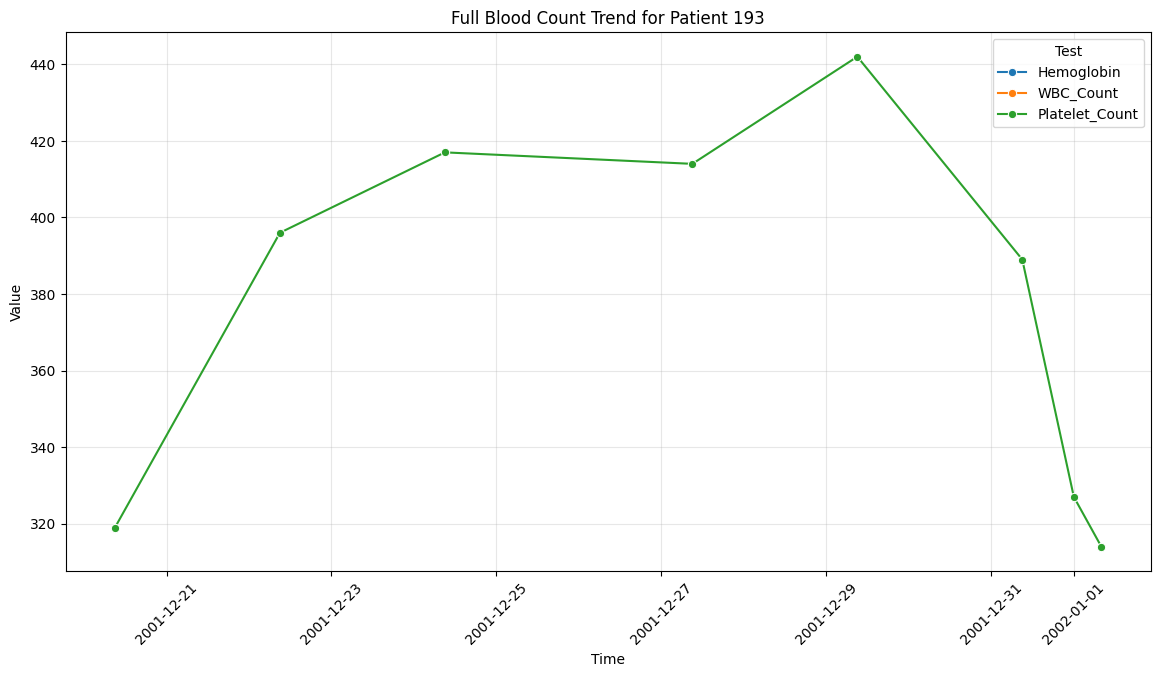

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# (Assuming the dataframe from the query is 'fbc_patient_trend')

# Melt the data for easy plotting
fbc_melted = fbc_patient_trend.melt(id_vars='chart_hour', var_name='Test', value_name='Value')

# Create the plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=fbc_melted, x='chart_hour', y='Value', hue='Test', marker='o')
plt.title("Full Blood Count Trend for Patient 193")
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

In [132]:
%%bigquery ecmo_stats
WITH ecmo_concepts AS (
    -- 1. Find all ECMO-related concepts
    SELECT concept_id, concept_name
    FROM `concept`
    WHERE REGEXP_CONTAINS(LOWER(concept_name), r'ecmo|extracorporeal membrane oxygenation')
),

ecmo_measurements AS (
    -- 2. Find all measurements using these concepts
    SELECT
        m.person_id,
        c.concept_name
    FROM `measurement` m
    JOIN ecmo_concepts c ON m.measurement_concept_id = c.concept_id
)

-- 3. Aggregate the results
SELECT
    concept_name as ecmo_indicator,
    COUNT(DISTINCT person_id) as unique_patients,
    COUNT(*) as total_measurements
FROM ecmo_measurements
GROUP BY 1

UNION ALL

-- Add a row for the TOTAL unique patients across all indicators
SELECT
    'TOTAL UNIQUE ECMO PATIENTS' as ecmo_indicator,
    COUNT(DISTINCT person_id) as unique_patients,
    NULL as total_measurements
FROM ecmo_measurements
ORDER BY unique_patients DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [133]:
ecmo_stats

ecmo_indicator  unique_patients  total_measurements
0  TOTAL UNIQUE ECMO PATIENTS             2622                <NA>
1   ecmo arterial temperature             2457              451125
2      ECMO pressure arterial              304               29060
3        ECMO pressure venous              255               23811
4      ECMO rounds per minute              252               34465
5                   ECMO FiO2              225               21917
6     ecmo venous temperature              183               12969
7          ECMO arterial flow               96                9048
8                   ECMO type               12                  17
9            ECMO venous flow                1                 123

--- ECMO Patient Counts ---
               ecmo_indicator  unique_patients  total_measurements
0  TOTAL UNIQUE ECMO PATIENTS             2622                <NA>
1   ecmo arterial temperature             2457              451125
2      ECMO pressure arterial              304               29060
3        ECMO pressure venous              255               23811
4      ECMO rounds per minute              252               34465
5                   ECMO FiO2              225               21917
6     ecmo venous temperature              183               12969
7          ECMO arterial flow               96                9048
8                   ECMO type               12                  17
9            ECMO venous flow                1                 123


/tmp/ipython-input-2902470539.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


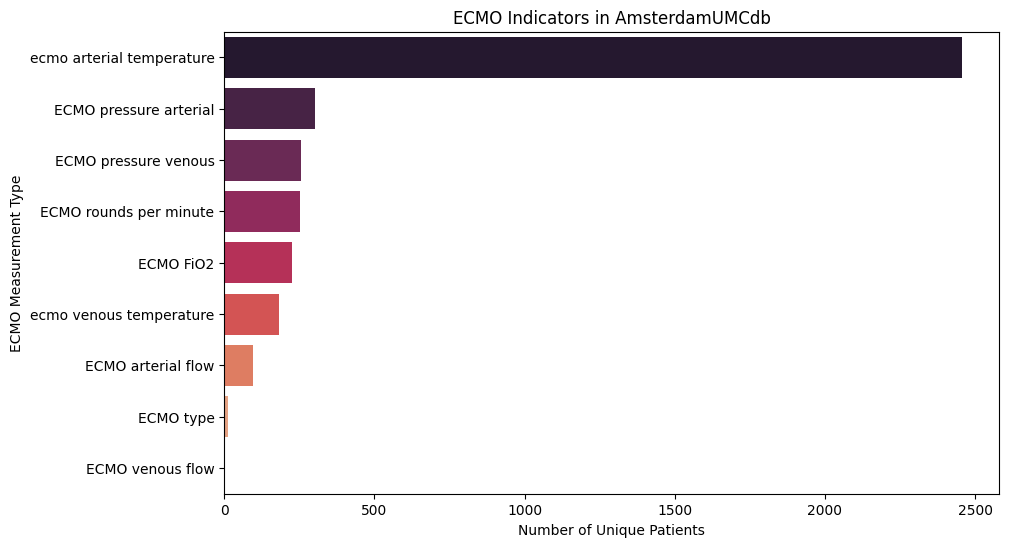

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display the table
print("--- ECMO Patient Counts ---")
print(ecmo_stats)

# Filter out the 'TOTAL' row for the bar chart
chart_data = ecmo_stats[ecmo_stats['ecmo_indicator'] != 'TOTAL UNIQUE ECMO PATIENTS']

# Plot the different ECMO indicators
plt.figure(figsize=(10, 6))
sns.barplot(
    data=chart_data,
    x='unique_patients',
    y='ecmo_indicator',
    palette='rocket'
)
plt.title("ECMO Indicators in AmsterdamUMCdb")
plt.xlabel("Number of Unique Patients")
plt.ylabel("ECMO Measurement Type")
plt.show()

In [136]:
%%bigquery ecmo_cohort
SELECT DISTINCT
    v.visit_occurrence_id,
    v.person_id,
    v.visit_start_datetime,
    v.visit_end_datetime,

    -- Did they die?
    CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END as Died

FROM `visit_occurrence` v
JOIN `measurement` m ON v.person_id = m.person_id
LEFT JOIN `death` d ON v.person_id = d.person_id
WHERE
    -- Use the "Golden ID" for ECMO (Blood flow CVVH)
    m.measurement_concept_id = 2000000021

Query is running:   0%|          |

Downloading:   0%|          |

In [137]:
ecmo_cohort

visit_occurrence_id  person_id      visit_start_datetime  \
0                   12195      34053 2017-01-01 00:00:00+00:00   
1                   43160      43401 2011-06-17 06:51:00+00:00   
2                   24805      45036 2017-01-01 00:00:00+00:00   
3                   50940      49381 2010-02-05 03:25:00+00:00   
4                   40090      49381 2012-10-18 23:54:00+00:00   
...                   ...        ...                       ...   
6329                 8934       1923 2017-01-01 00:00:00+00:00   
6330                72210       1923 2021-02-20 23:39:00+00:00   
6331                 8591       2462 2017-01-01 00:00:00+00:00   
6332                63621       2462 2021-06-21 19:40:00+00:00   
6333                53293      11830 2017-01-01 00:00:00+00:00   

            visit_end_datetime  Died  
0    2017-01-13 14:21:00+00:00     1  
1    2011-06-18 15:25:00+00:00     1  
2    2017-01-09 03:23:00+00:00     1  
3    2010-07-04 01:55:00+00:00     0  
4    2012-10-20 23:08:00+00:00     0  
...                        ...   ...  
6329 2017-01-01 04:02:00+00:00     1  
6330 2021-02-28 03:20:00+00:00     1  
6331 2017-01-01 19:28:00+00:00     0  
6332 2021-06-26 21:56:00+00:00     0  
6333 2017-01-01 18:41:00+00:00     1  

[6334 rows x 5 columns]

In [142]:
%%bigquery unit_type_specialty
SELECT
    -- This column likely holds the 'IC', 'MC', 'IC&MC' values
    v.visit_source_value as unit_type,

    COUNT(DISTINCT v.person_id) as unique_patients,

    -- Calculate mortality for each unit type
    ROUND(AVG(CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END) * 100, 1) as mortality_rate_pct

FROM `visit_occurrence` v
LEFT JOIN `death` d ON v.person_id = d.person_id
WHERE v.visit_source_value IS NOT NULL
GROUP BY 1
ORDER BY unique_patients DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [143]:
unit_type_specialty

unit_type  unique_patients  mortality_rate_pct
0       icu            65397                21.4

In [145]:
%%bigquery observation_specialty
SELECT
    -- The value of the observation is the specialty
    o.value_source_value as specialty,
    COUNT(DISTINCT o.person_id) as unique_patients,
    ROUND(AVG(CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END) * 100, 1) as mortality_rate_pct
FROM `observation` o
JOIN `concept` c ON o.observation_concept_id = c.concept_id
LEFT JOIN `death` d ON o.person_id = d.person_id
WHERE
    -- Search for the concept that represents "Admitting Specialty"
    -- This requires a keyword search on the concept name
    REGEXP_CONTAINS(LOWER(c.concept_name), r'specialty|discipline|admitting service|opnemend specialisme')
GROUP BY 1
ORDER BY unique_patients DESC

Query is running:   0%|          |

Downloading: |          |

In [146]:
observation_specialty

Empty DataFrame
Columns: [specialty, unique_patients, mortality_rate_pct]
Index: []

In [147]:
%%bigquery apache_item_id
SELECT
    concept_id,
    concept_name,
    concept_code
FROM `concept`
WHERE
    -- Search for the original itemid from the documentation (e.g., 18671 for NICE APACHE IV)
    -- or by name
    REGEXP_CONTAINS(LOWER(concept_name), r'apache.*diagnos|reason for admission')
    AND vocabulary_id = 'AmsterdamUMCdb' -- Filter to the local concepts

Query is running:   0%|          |

Downloading: |          |

In [148]:
apache_item_id

Empty DataFrame
Columns: [concept_id, concept_name, concept_code]
Index: []

In [149]:
%%bigquery specialty_by_diagnosis
WITH apache_diagnoses AS (
    SELECT
        m.person_id,
        -- The value_source_value will contain the text of the diagnosis
        m.value_source_value as diagnosis_text
    FROM `measurement` m
    WHERE
        -- Use the ID we found in Step 1
        m.measurement_concept_id = 2000000002 -- Placeholder for APACHE IV Score/Diagnosis
        -- Only take the first one for each patient
        AND m.measurement_datetime = (
            SELECT MIN(m2.measurement_datetime)
            FROM `measurement` m2
            WHERE m2.person_id = m.person_id AND m2.measurement_concept_id = 2000000002
        )
)

SELECT
    -- Group the detailed diagnoses into broad specialties
    CASE
        WHEN LOWER(diagnosis_text) LIKE '%cardiac%' OR LOWER(diagnosis_text) LIKE '%cardiovasculair%' THEN 'Cardiology/Cardiac Surgery'
        WHEN LOWER(diagnosis_text) LIKE '%sepsis%' OR LOWER(diagnosis_text) LIKE '%infection%' THEN 'Infectious Disease/Sepsis'
        WHEN LOWER(diagnosis_text) LIKE '%neuro%' THEN 'Neurology/Neurosurgery'
        WHEN LOWER(diagnosis_text) LIKE '%respiratory%' OR LOWER(diagnosis_text) LIKE '%pulmonary%' THEN 'Pulmonology'
        WHEN LOWER(diagnosis_text) LIKE '%gastro%' OR LOWER(diagnosis_text) LIKE '%gi %' THEN 'Gastroenterology'
        WHEN LOWER(diagnosis_text) LIKE '%trauma%' THEN 'Trauma'
        ELSE 'Other/Mixed Medical'
    END as inferred_specialty,

    COUNT(DISTINCT a.person_id) as unique_patients,
    ROUND(AVG(CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END) * 100, 1) as mortality_rate_pct

FROM apache_diagnoses a
LEFT JOIN `death` d ON a.person_id = d.person_id
GROUP BY 1
ORDER BY unique_patients DESC

Query is running:   0%|          |

Downloading: |          |

In [150]:
specialty_by_diagnosis

Empty DataFrame
Columns: [inferred_specialty, unique_patients, mortality_rate_pct]
Index: []

## Display the `person` dataframe.

In [ ]:
person

# Tips and Tricks

# Getting related items
Assume you have determined that concept_id `40729817` (Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]) is of interest, but would like to know if other steroids have been used on our unit.

In [ ]:
ancestors = pd.read_gbq(
    '''
    SELECT ancestor_concept_id, descendant_concept_id, min_levels_of_separation, concept_name, vocabulary_id, concept_class_id
    FROM concept_ancestor
    LEFT JOIN concept
      ON concept_ancestor.ancestor_concept_id = concept.concept_id
    WHERE descendant_concept_id = 40729817 -- Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]
    ORDER BY min_levels_of_separation DESC
    '''
    , configuration=config_gbq, use_bqstorage_api=True)
ancestors

In [ ]:
descendants = pd.read_gbq(
    '''
    SELECT descendant_concept_id
    FROM concept_ancestor
    WHERE ancestor_concept_id = 21602728 -- Glucocorticoids
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

# filter dictionary on all descendants
dictionary[dictionary['concept_id'].isin(descendants['descendant_concept_id'])]

In [ ]:
corticosteroids = pd.read_gbq(
    '''
    SELECT *
    FROM drug_exposure
    WHERE drug_concept_id IN (
      40028601,	-- dexamethasone Oral Tablet
      40028260,  -- dexamethasone Injectable Solution
      40049700,	-- hydrocortisone Oral Tablet
      40729817,  -- Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]
      40073458,	-- prednisolone Oral Tablet
      40073191,	-- prednisolone Injectable Solution
      40060704,  -- methylprednisolone Injectable Solution [Solu-Medrol]
      40060704	-- methylprednisolone Injectable Solution [Solu-Medrol]
    )
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

## Conclusion
This finalizes our tutorial on accessing AmsterdamUMCdb using BigQuery.

### What's next?
- Have a look at the AmsterdamUMCdb [wiki](https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki).
- More examples are available for the legacy tables. You can use the dictionary to translate the legacy `source_code`s to `concept_id`s. Future work will update this repository with examples for the OMOP Common Data Model.

Table | Wiki | Example code
:- | :--| -:
admissions|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/admissions | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/admissions.ipynb)
drugitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/drugitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/drugitems.ipynb)
freetextitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/freetextitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/freetextitems.ipynb)
listitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/lisitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/listitems.ipynb)
numericitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/numericitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/numericitems.ipynb)
procedureorderitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/procedureorderitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/procedureorderitems.ipynb)
processitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/processitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/processitems.ipynb)

- Examine the [concepts](https://github.com/AmsterdamUMC/AmsterdamUMCdb/tree/master/concepts) for definitions related to diagnoses, life support systems, including mechanical ventilation and renal replacement therapy, and ICU scoring systems.
- And remember: medical data science is always a joint effort of disciplines, so start a discussion with your colleagues or team members early on how to approach your clinical problem.
